PCE A380
===

In [1]:
#Import libraries
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
xlsx_files = os.listdir('../01_data/')
xlsx_files = [file for file in xlsx_files if file.startswith('export_A380') == True]
count = 0
for file in xlsx_files:
    print(file)
    if count<1:
        df = pandas.read_excel('../01_data/'+file)
        cols = df.columns.tolist() #Names of columns
        columns = []
        for col in cols:
            tempo = col.replace('.', '_')
            tempo = tempo.replace(' ', '_')
            columns.append(tempo.lower()) #Rename columns
        df.columns = columns
    else:
        df2 = pandas.read_excel('../01_data/'+file)
        cols = df2.columns.tolist() #Names of columns
        columns = []
        for col in cols:
            tempo = col.replace('.', '_')
            tempo = tempo.replace(' ', '_')
            columns.append(tempo.lower()) #Rename columns
        df2.columns = columns
        df = pandas.concat([df, df2])
    count+=1 
df = df.drop(["item"],axis = 1) #Delete some useless columns
df = df.convert_objects(convert_numeric=True)
#df = df.infer_objects()
#df.dtypes
print(df.shape)
df.head()

export_A380__TBR361J0_20180210-20180215.xlsx
export_A380__TBR361J0_20180216-20180222.xlsx
export_A380__TBR361J0_20180329-20180405.xlsx
export_A380__TBR361J0_20180126-20180202.xlsx
export_A380__TBR361J0_20180302-20180315.xlsx
export_A380__TBR361J0_20180316-20180322.xlsx
export_A380__TBR361J0_20180223-20180301.xlsx
export_A380__TBR361J0_20180413-20180419.xlsx
export_A380__TBR361J0_20180323-20180329.xlsx
export_A380__TBR361J0_20180427-20180503.xlsx
export_A380__TBR361J0_20180203-20180209.xlsx
export_A380__TBR361J0_20180420-20180426.xlsx
export_A380__TBR361J0_20180504-20180510.xlsx
export_A380__TBR361J0_20180406-20180412.xlsx


/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


(428306, 62)


acms_fp    alt    apubldp  apubvcl  apubvop     apudmd  apuivcl  apuivop  \
0     10.0 -149.0  26.329273      NaN      1.0   0.000000      NaN      NaN   
1     10.0 -149.0  37.827248      NaN      1.0   6.227414      NaN      NaN   
2     10.0 -149.0  40.922474      NaN      1.0   7.894113      NaN      NaN   
3     10.0 -149.0  38.303436      NaN      1.0   9.560811      NaN      NaN   
4     10.0 -149.0  32.569330      NaN      1.0  11.227510      NaN      NaN   

    blddp_1   blddp_2     ...       sav_3  sav_4  tailnb        tat  \
0 -0.012409  0.038074     ...         NaN    NaN  A6-EEQ  23.557760   
1 -0.017427  0.009259     ...         NaN    NaN  A6-EEQ  23.489216   
2 -0.059099  0.058121     ...         NaN    NaN  A6-EEQ  23.521930   
3  0.054075 -0.002017     ...         NaN    NaN  A6-EEQ  23.486046   
4 -0.033734 -0.055893     ...         NaN    NaN  A6-EEQ  23.489180   

   unnamed:_51  unnamed:_52  unnamed:_53  unnamed:_54  unnamed:_55  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   unnamed:_56  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 62 columns]

In [3]:
#Check conditions
df = df[df["acms_fp"] == 10] #ACMS FP = 10 (eq. FWSFP = 1)
df = df[df["apubvop"] == 1] #APU Bleed Valve Open (1 mean OPEN)
df = df[df["lcbvcl"] == 0] #Xbleed Valves Open (1 mean CLOSE)
df = df[df["cfvcl"] == 0] #Xbleed Valves Open (1 mean CLOSE)
df = df[df["rcbvcl"] == 0] #Xbleed Valves Open (1 mean CLOSE)
print(df.shape)
df = df[(df["hpv_1"] == 1) & (df["hpv_2"] == 1) & (df["hpv_3"] == 1) & (df["hpv_4"] == 1)] #HPV Close (1 mean CLOSE, see ICD20221-002_digital icd p28)
df = df[(df["prv_1"] == 1) & (df["prv_2"] == 1) & (df["prv_3"] == 1) & (df["prv_4"] == 1)] #PRV Close (1 mean CLOSE, see ICD20221-002_digital icd p28)
print(df.shape) 
df = df[(df["sav_1"] == 0) & (df["sav_2"] == 0) & (df["sav_3"] == 0) & (df["sav_4"] == 0)] #SAV Close (1 mean OPEN according to Temperature)
print(df.shape) 
df = df[(df["fcvcl_1"] == 0) & (df["fcvcl_2"] == 0) & (df["fcvcl_3"] == 0) & (df["fcvcl_4"] == 0)] #FCV Open (1 mean CLOSE, see ICD20221-002_digital icd_PADS; $$5.3.3)
df = df[(df["n2act_1"] == 0) & (df["n2act_2"] == 0) & (df["n2act_3"] == 0) & (df["n2act_4"] == 0)] #N2 = 0
print(df.shape)

(264158, 62)
(263002, 62)
(25870, 62)
(22822, 62)


In [4]:
#Compute for each precoolers the difference between the bleed temperature and the median of the 3 others
df["PCE_1"] = df["bldt_1"] - df[["bldt_2","bldt_3","bldt_4"]].median(axis=1)
df["PCE_2"] = df["bldt_2"] - df[["bldt_1","bldt_3","bldt_4"]].median(axis=1)
df["PCE_3"] = df["bldt_3"] - df[["bldt_1","bldt_2","bldt_4"]].median(axis=1)
df["PCE_4"] = df["bldt_4"] - df[["bldt_1","bldt_2","bldt_3"]].median(axis=1)
df.head()

acms_fp    alt    apubldp  apubvcl  apubvop        apudmd  apuivcl  \
305     10.0 -153.0  38.174470      NaN      1.0  4.633817e-10      NaN   
306     10.0 -153.0  38.194313      NaN      1.0  2.379383e-10      NaN   
307     10.0 -153.0  38.075260      NaN      1.0  1.221771e-10      NaN   
308     10.0 -153.0  37.985977      NaN      1.0  6.273573e-11      NaN   
309     10.0 -153.0  38.015740      NaN      1.0  3.330535e-11      NaN   

     apuivop   blddp_1   blddp_2    ...      unnamed:_51  unnamed:_52  \
305      NaN  0.066890  0.021787    ...              NaN          NaN   
306      NaN  0.075660 -0.002972    ...              NaN          NaN   
307      NaN -0.004526  0.027109    ...              NaN          NaN   
308      NaN  0.066890  0.020842    ...              NaN          NaN   
309      NaN  0.078166  0.044657    ...              NaN          NaN   

     unnamed:_53  unnamed:_54  unnamed:_55  unnamed:_56      PCE_1      PCE_2  \
305          NaN          NaN          NaN          NaN -38.226109  57.019347   
306          NaN          NaN          NaN          NaN -38.381110  58.239720   
307          NaN          NaN          NaN          NaN -39.566391  57.316970   
308          NaN          NaN          NaN          NaN -39.413090  58.084710   
309          NaN          NaN          NaN          NaN -39.429756  57.784321   

         PCE_3      PCE_4  
305  36.628891 -36.628891  
306  37.091100 -37.091100  
307  38.307616 -38.307616  
308  38.153815 -38.153815  
309  38.323879 -38.323879  

[5 rows x 66 columns]

A6-EOS 1 / 89


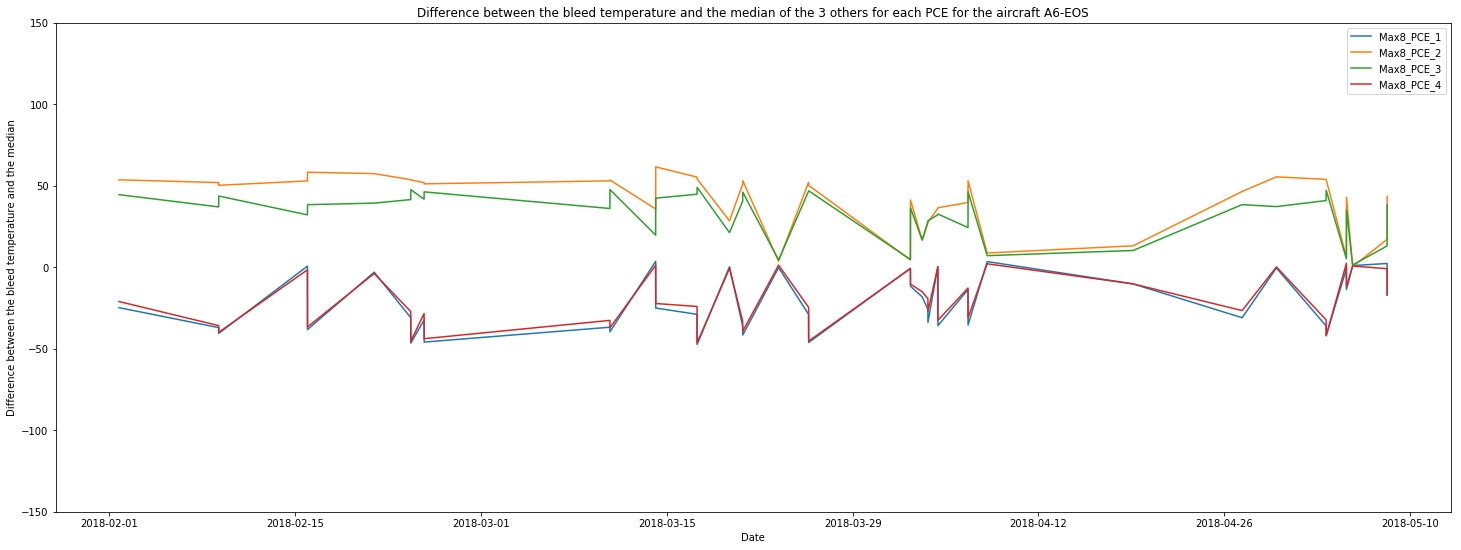

A6-EUJ 2 / 89


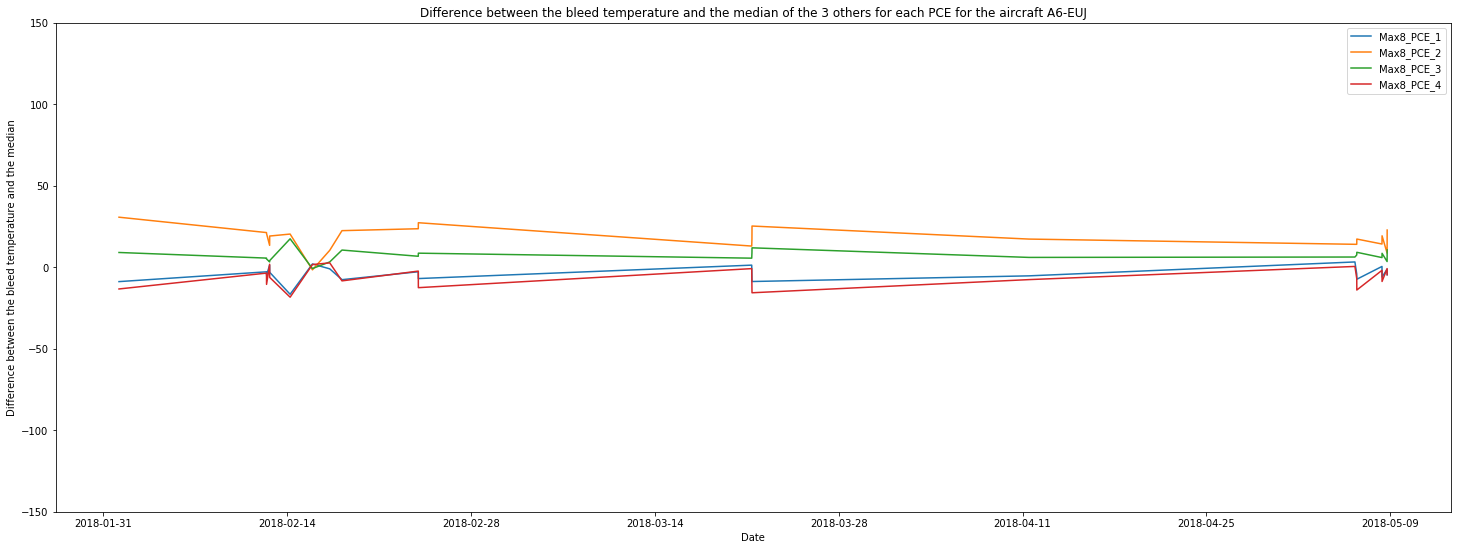

A6-EOU 3 / 89


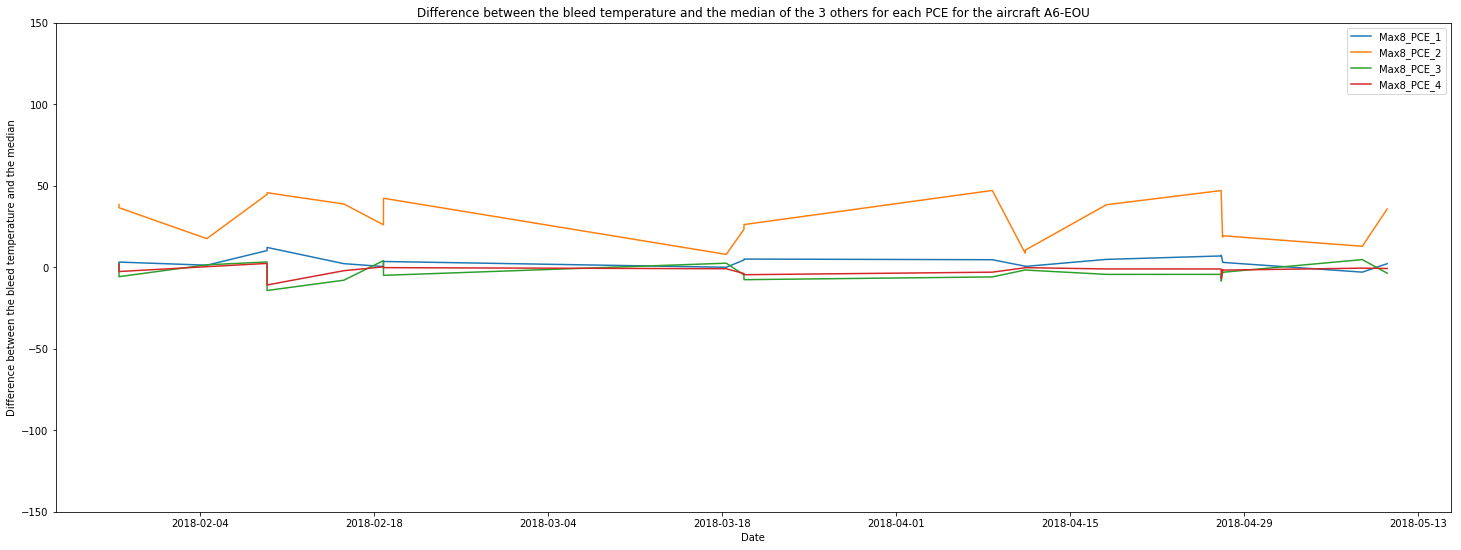

A6-EEX 4 / 89


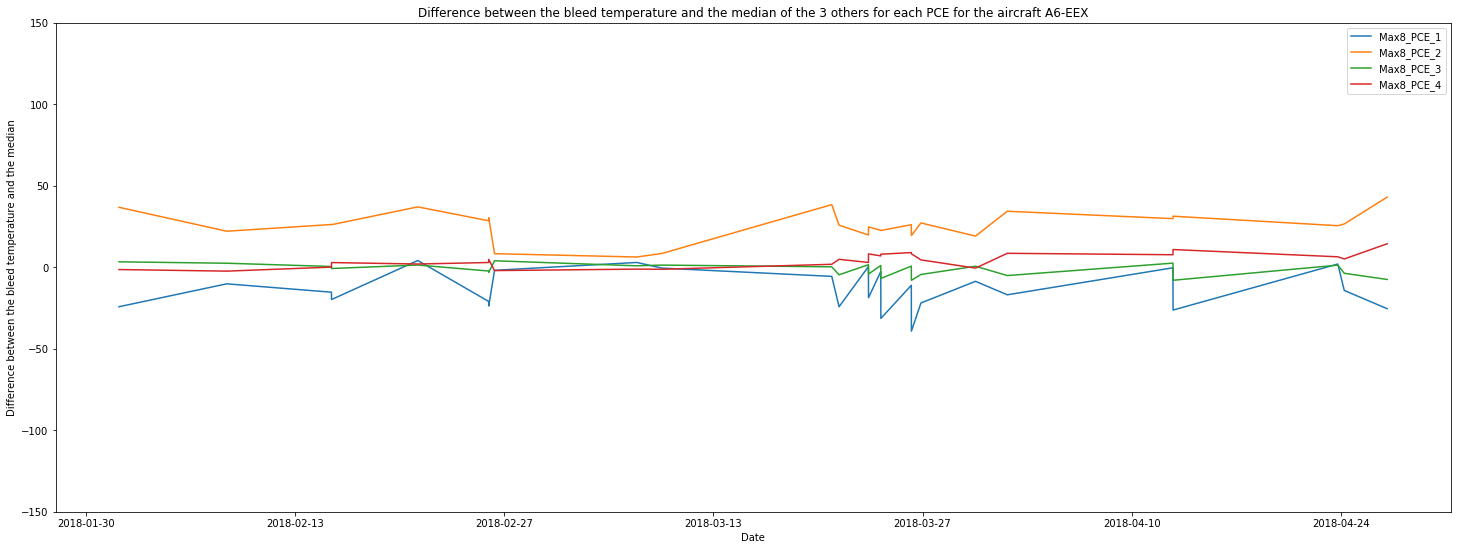

A6-EEW 5 / 89


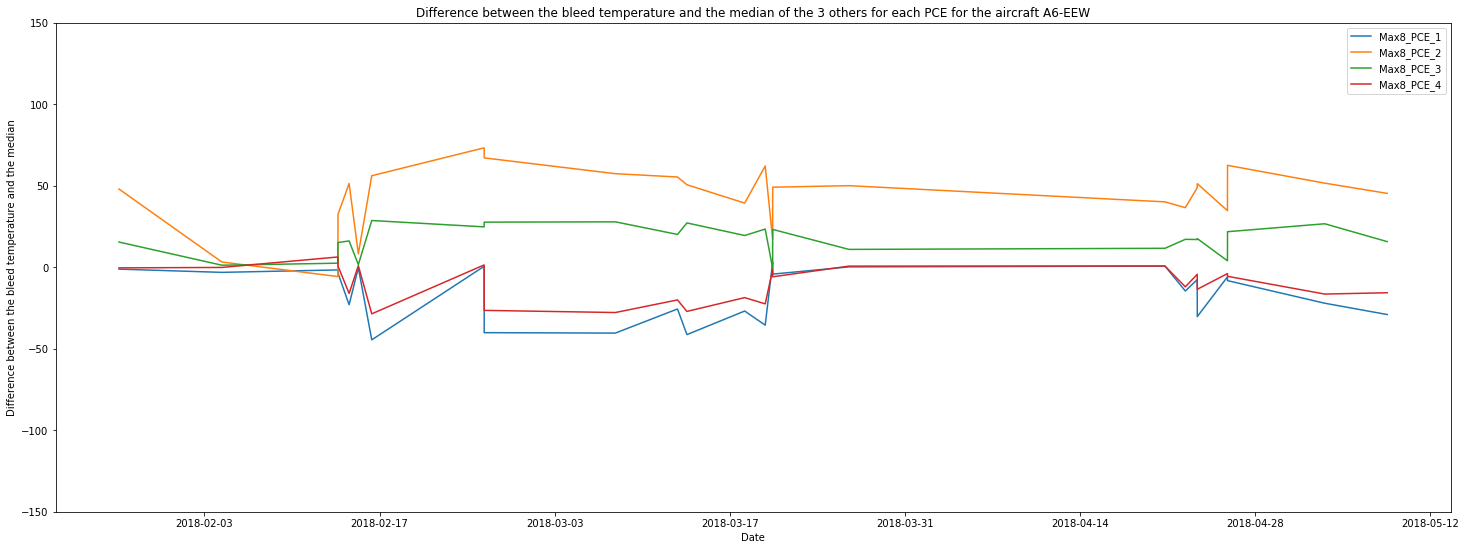

A6-EEB 6 / 89


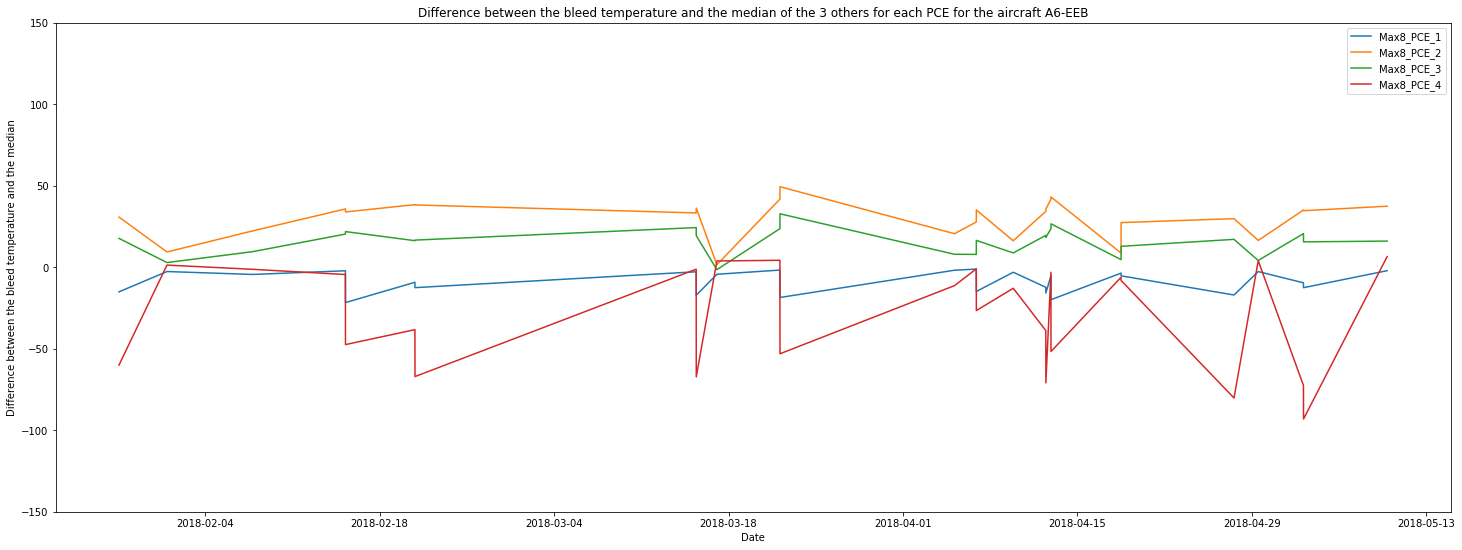

A6-EDR 7 / 89


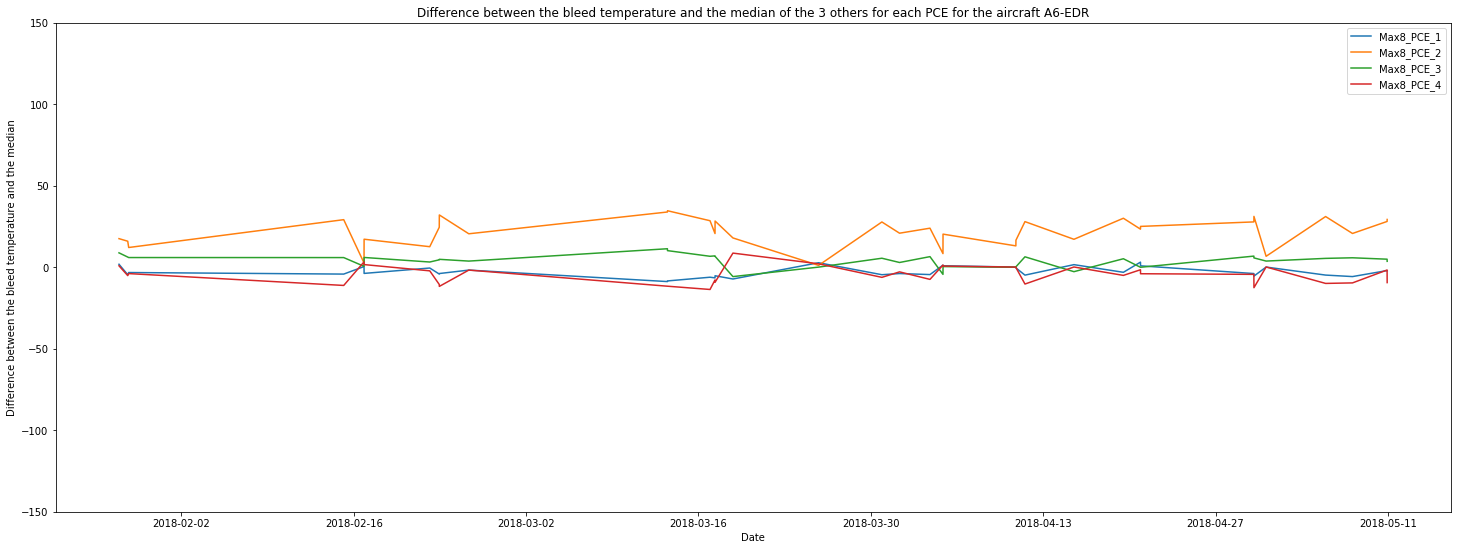

A6-EOG 8 / 89


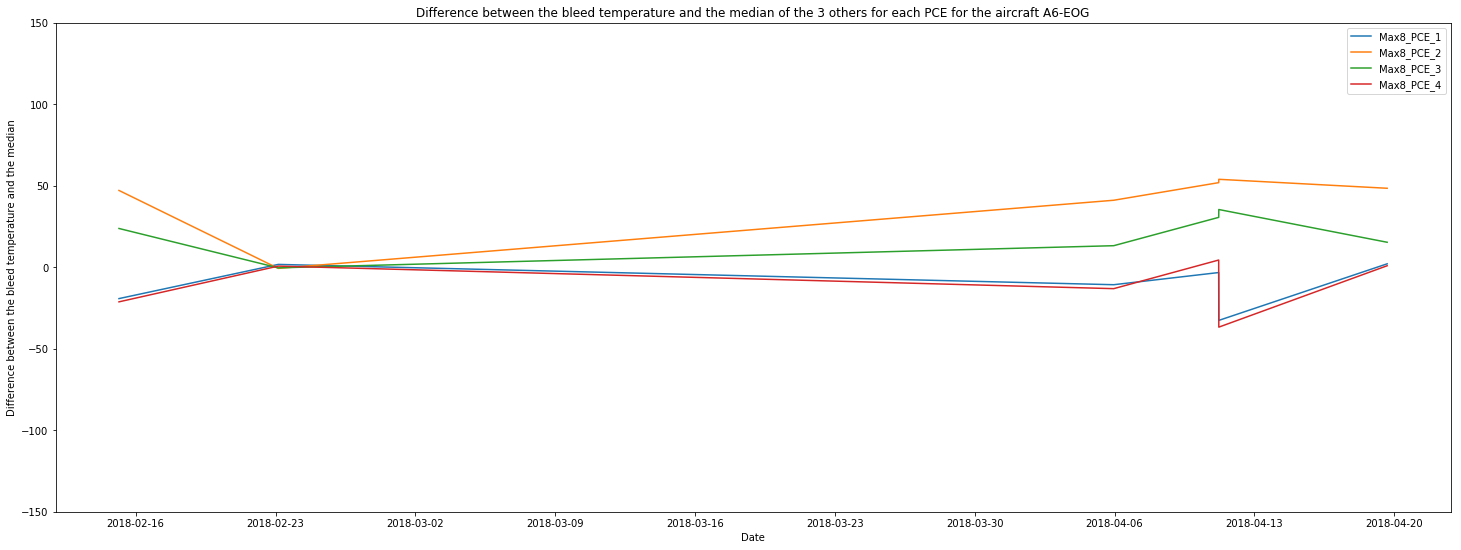

A6-EDO 9 / 89


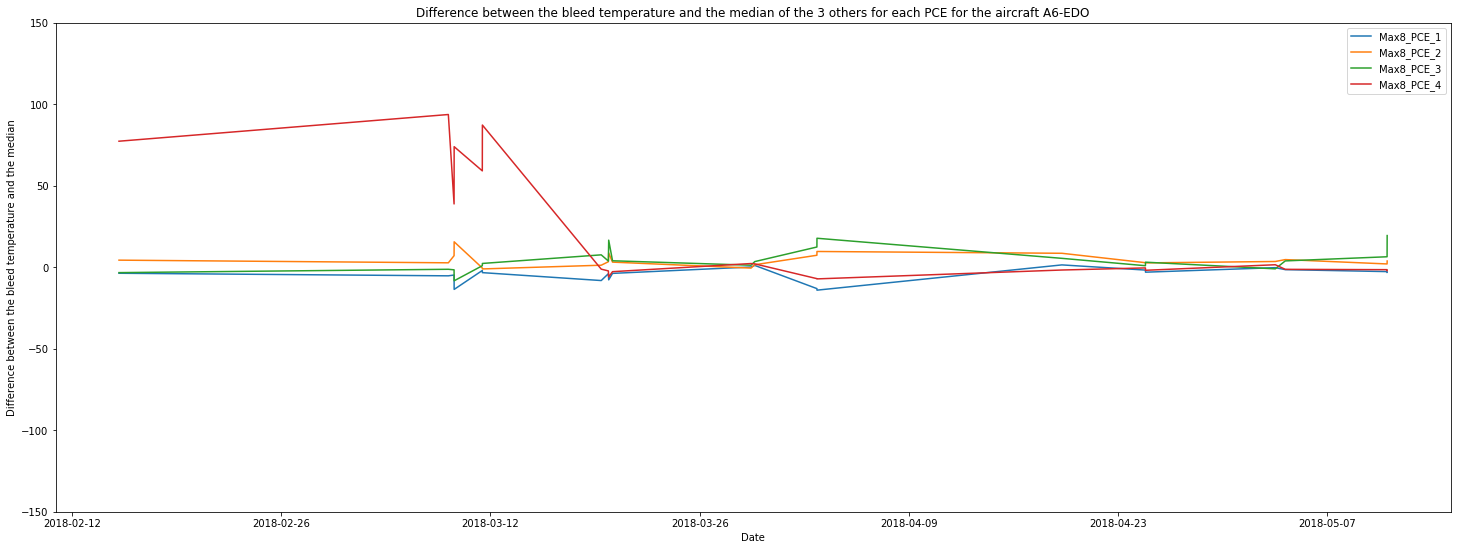

A6-EOB 10 / 89


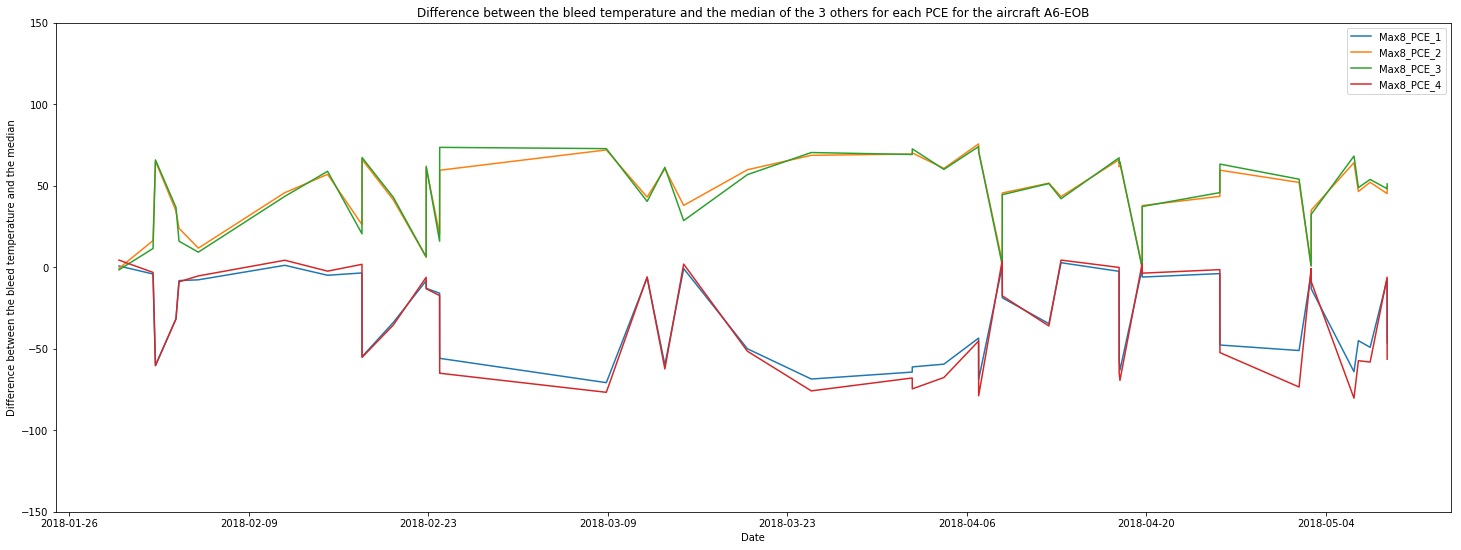

A6-EDX 11 / 89


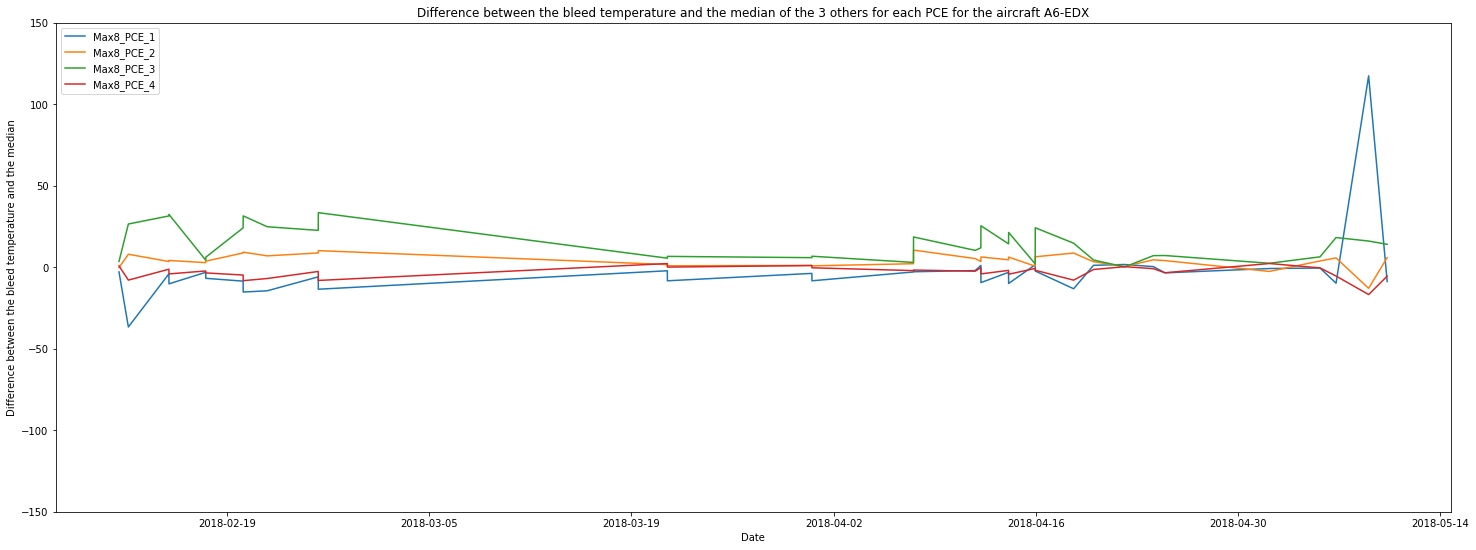

A6-EDL 12 / 89


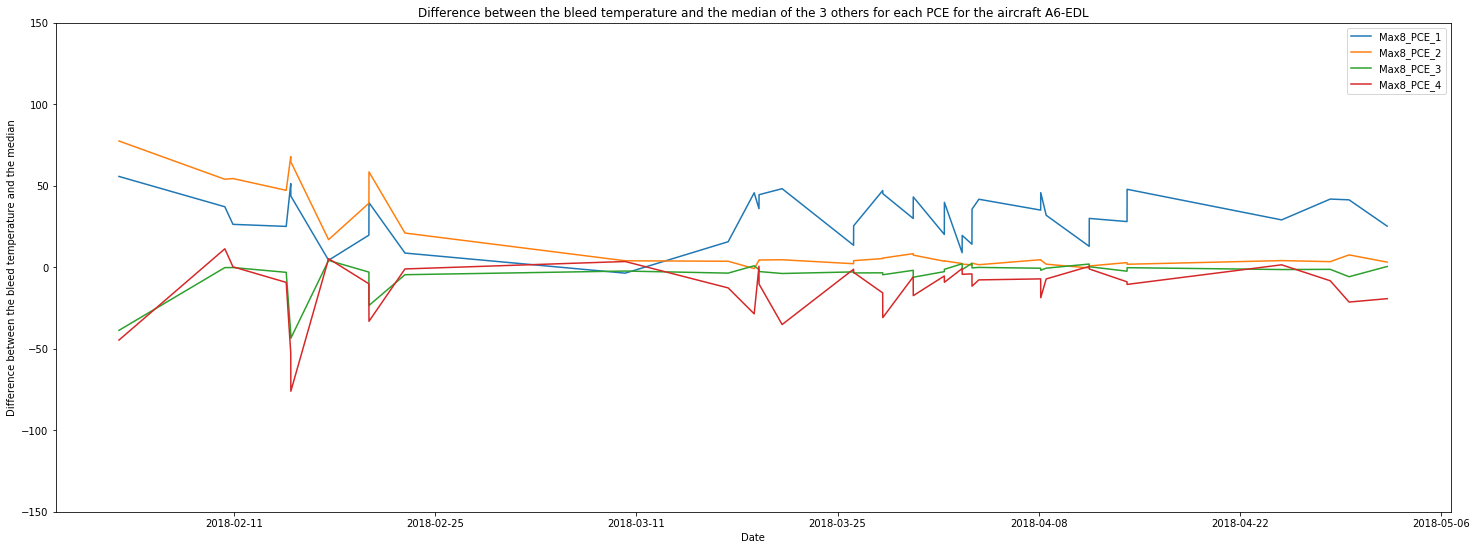

A6-EEZ 13 / 89


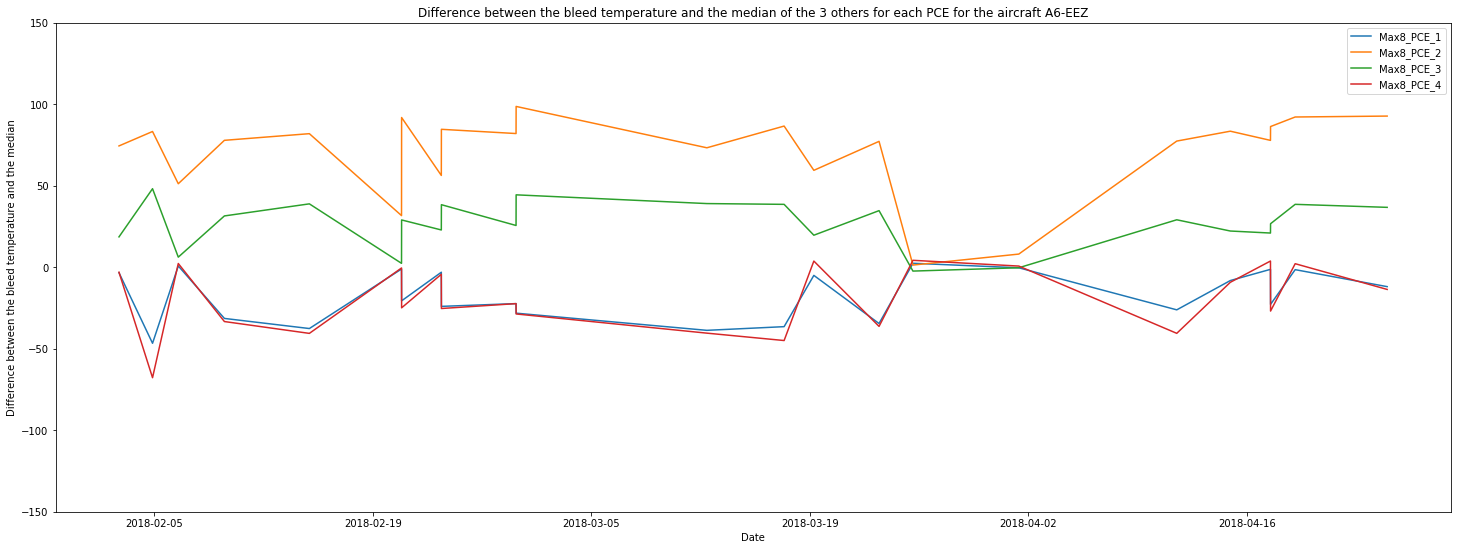

A6-EOP 14 / 89


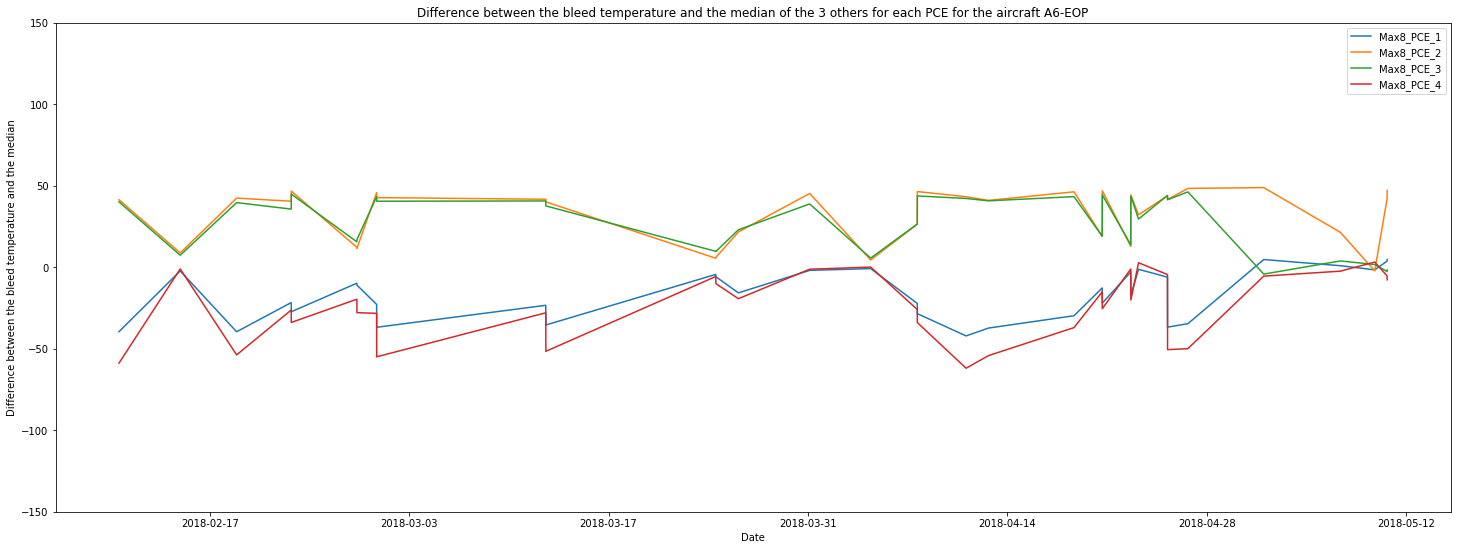

A6-EOK 15 / 89


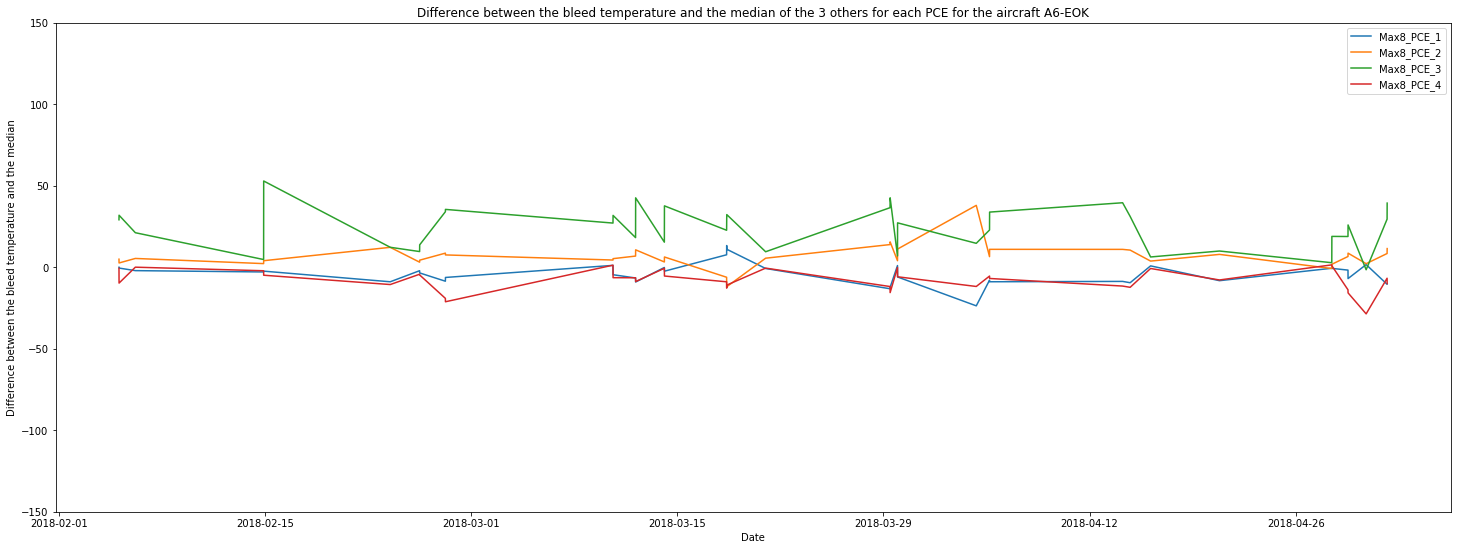

A6-EOH 16 / 89


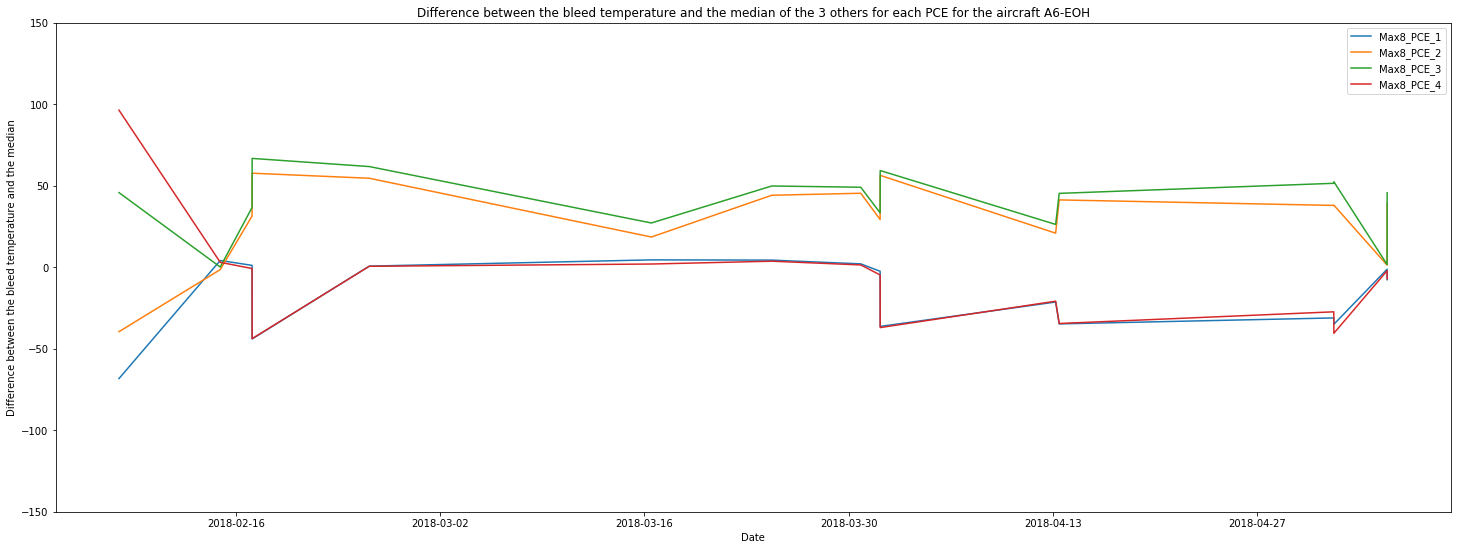

A6-EDK 17 / 89


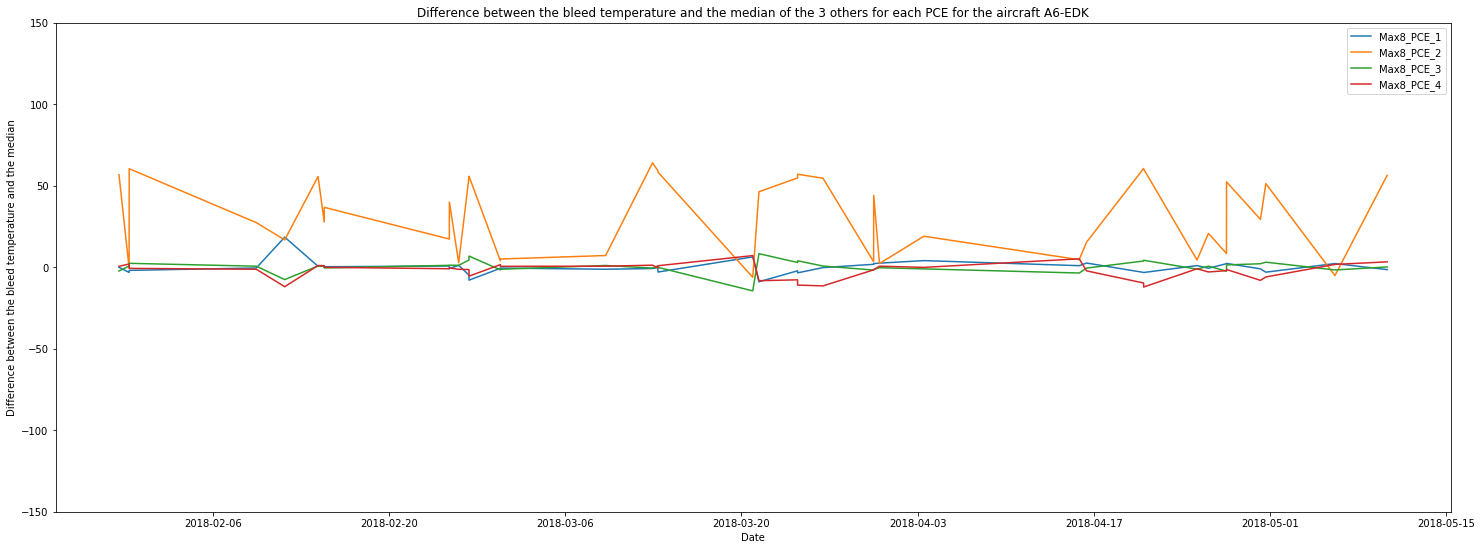

A6-EDW 18 / 89


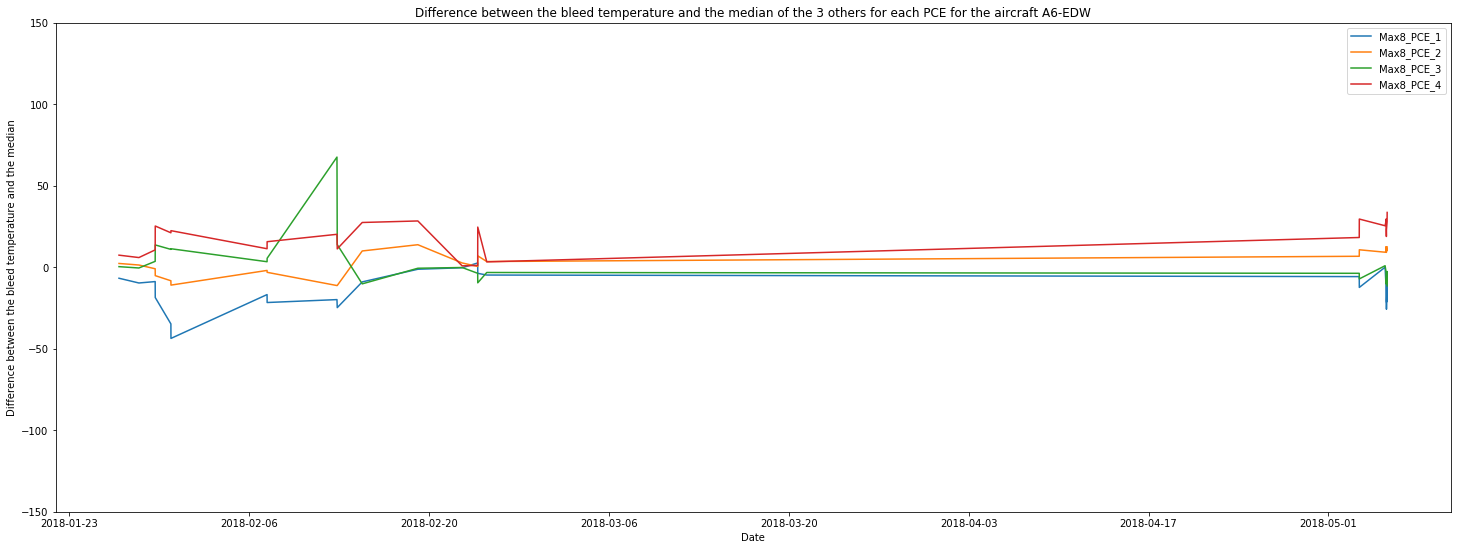

A6-EOX 19 / 89


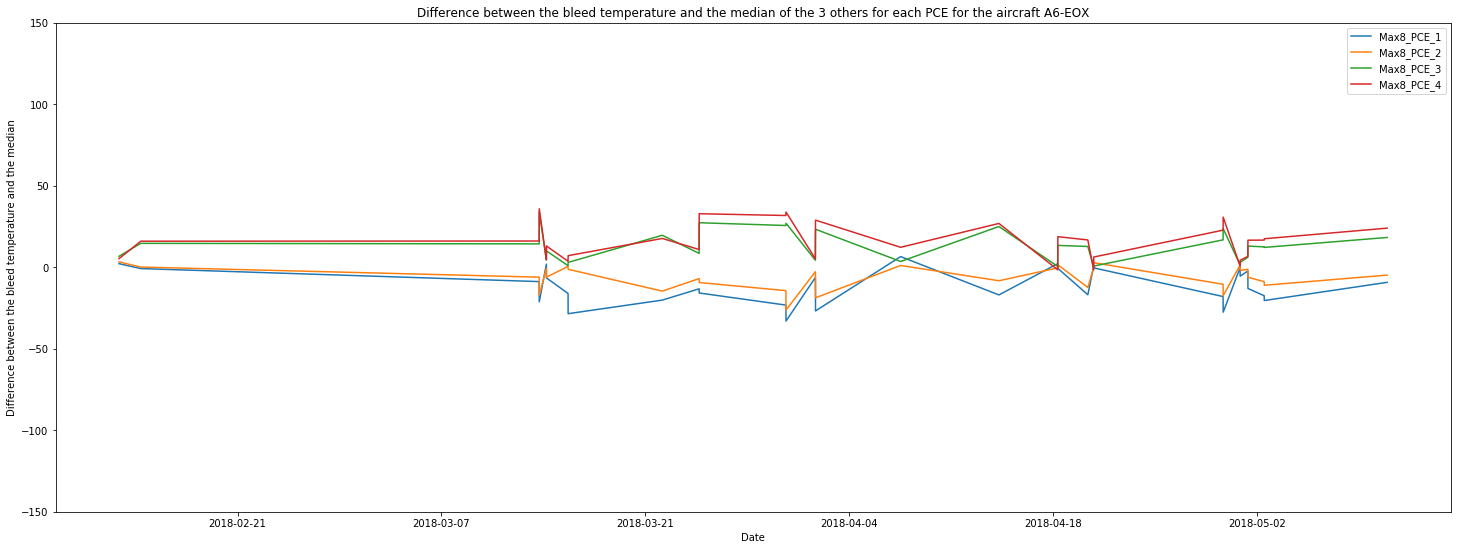

A6-EOD 20 / 89


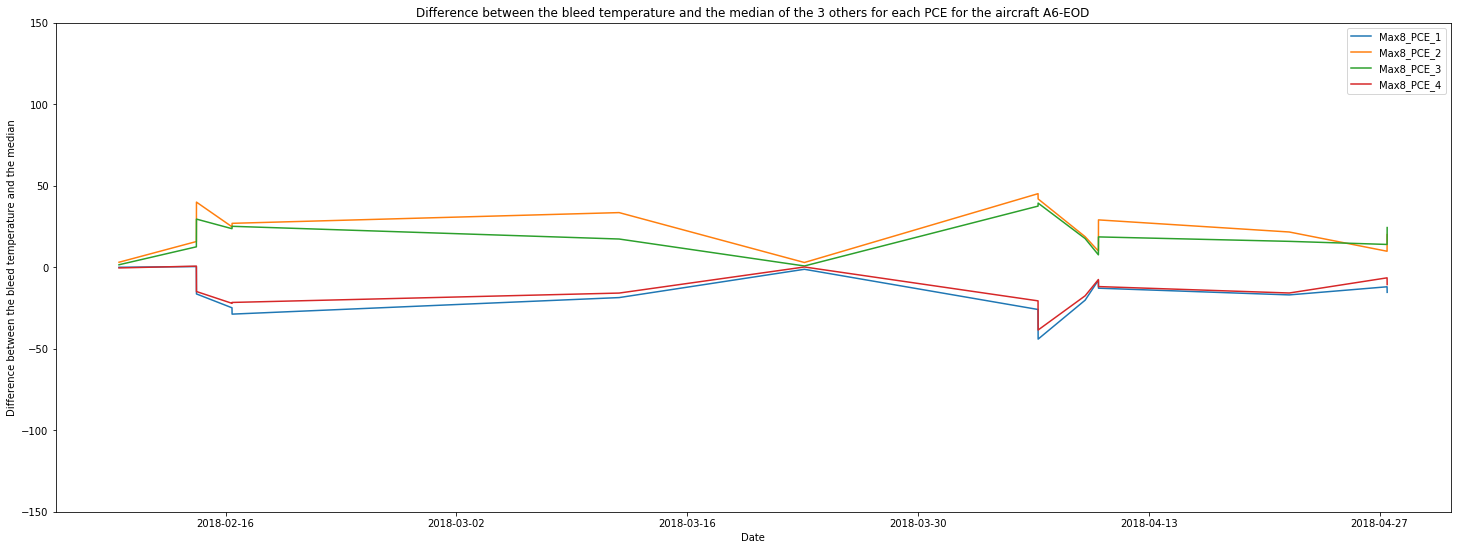

A6-EUF 21 / 89


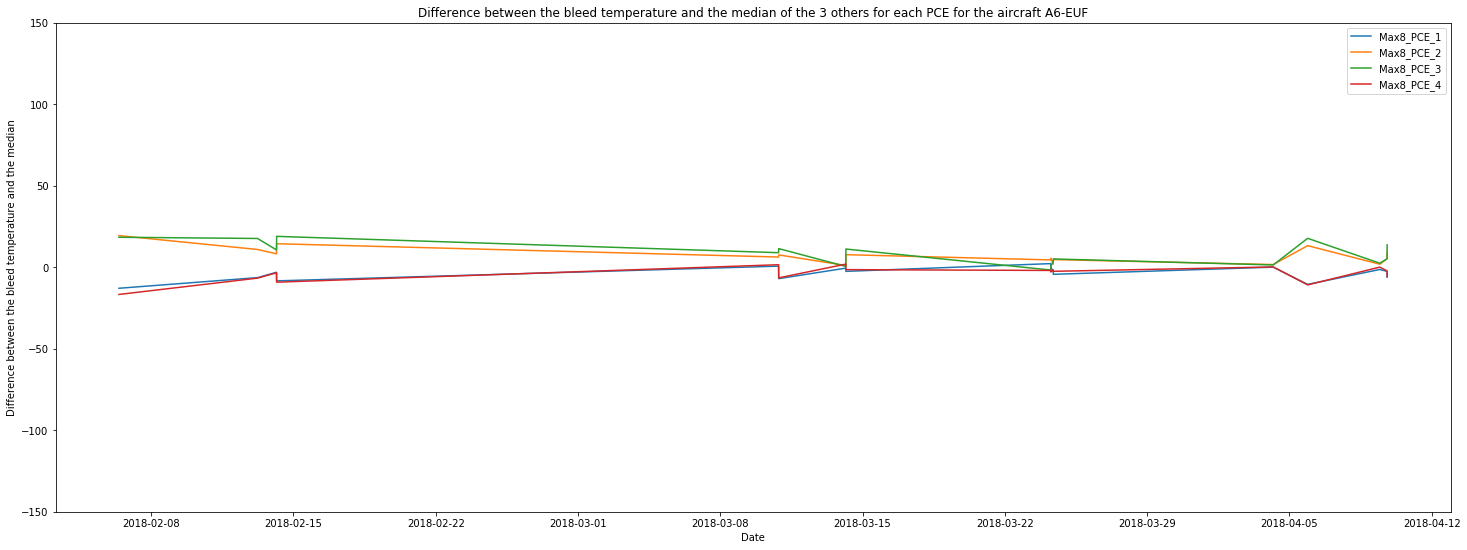

A6-EUD 22 / 89


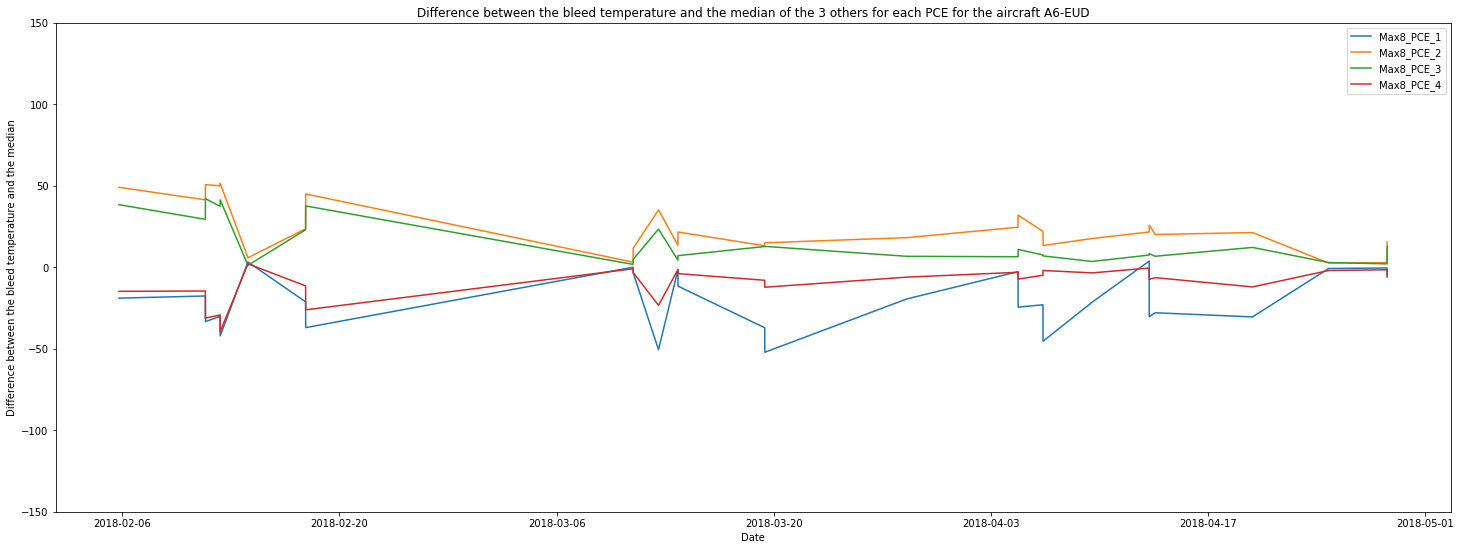

A6-EDU 23 / 89


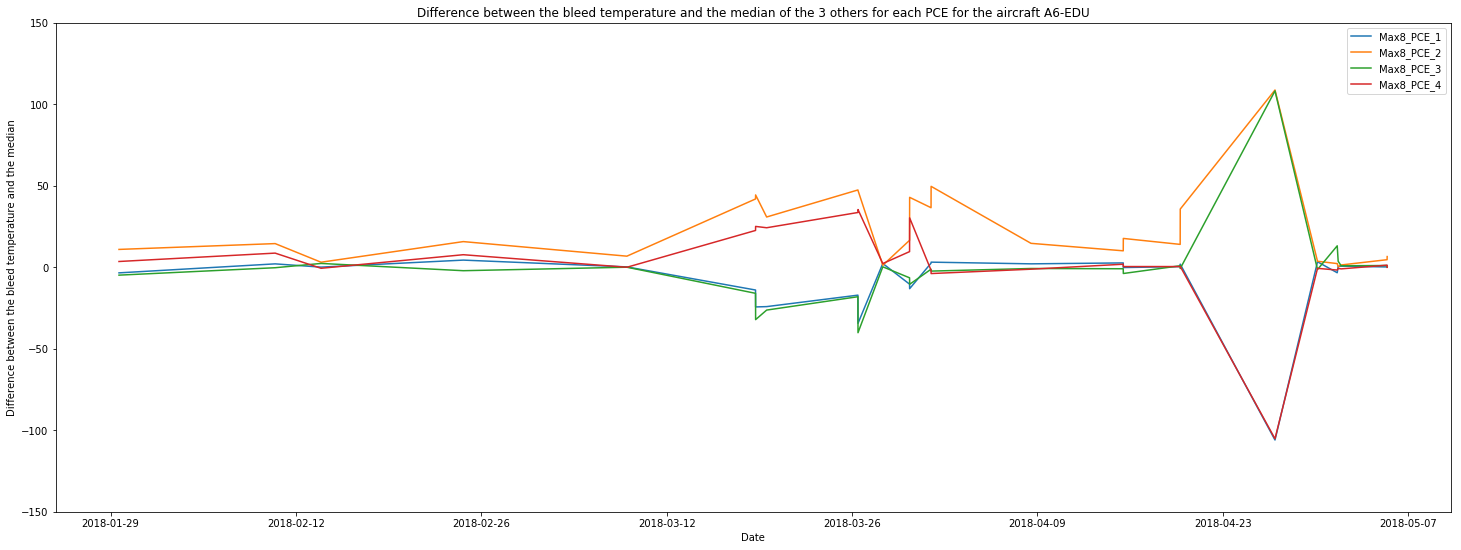

A6-EEI 24 / 89


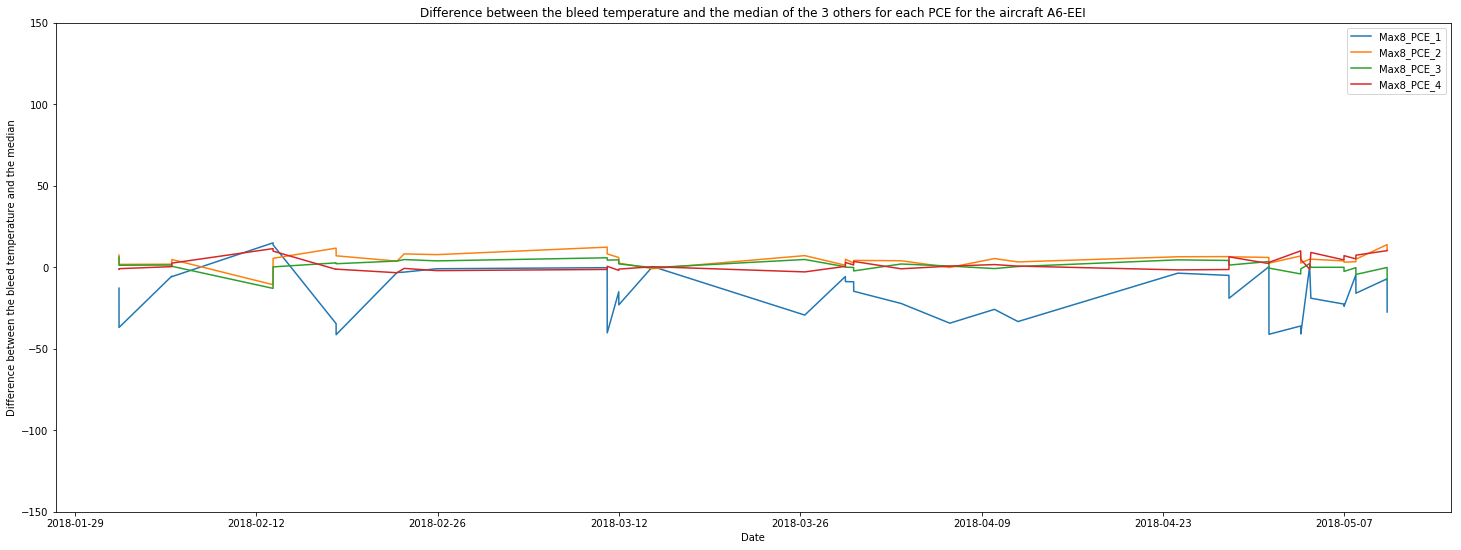

A6-EDH 25 / 89


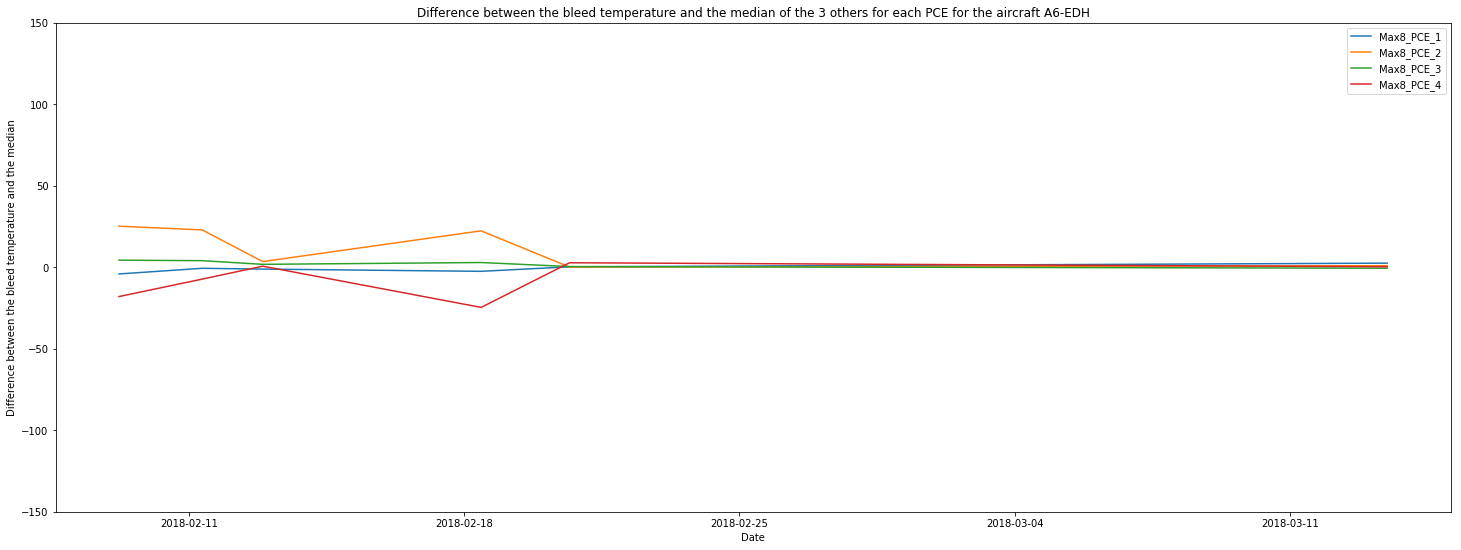

A6-EDC 26 / 89


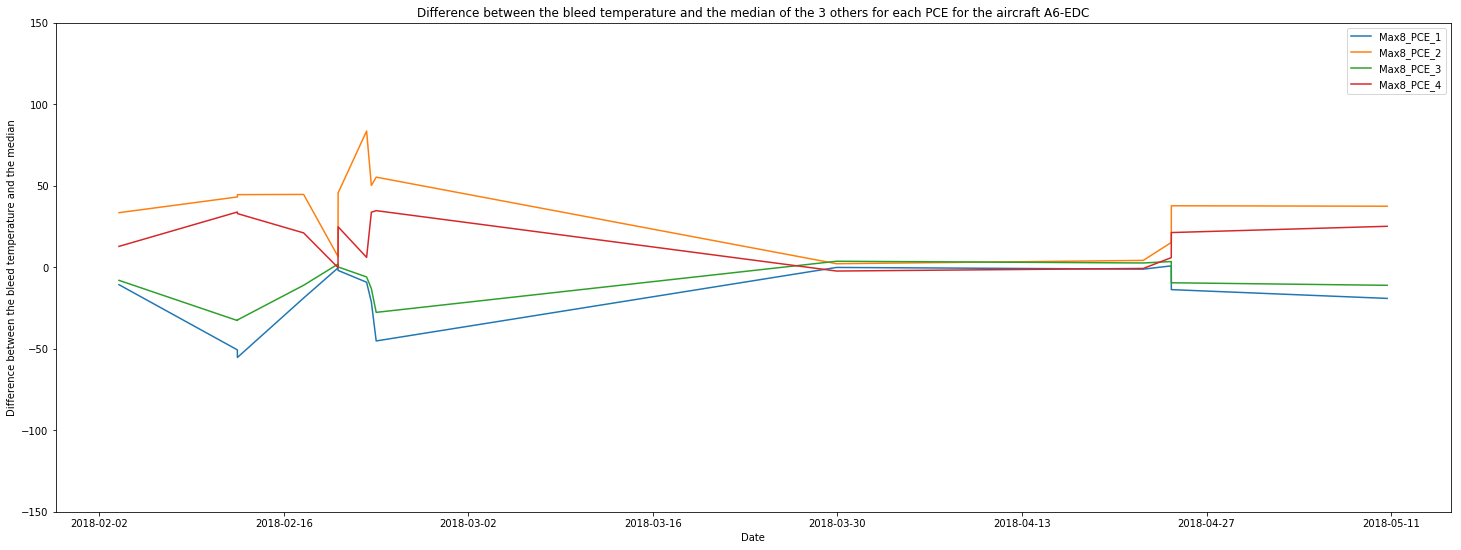

A6-EEQ 27 / 89


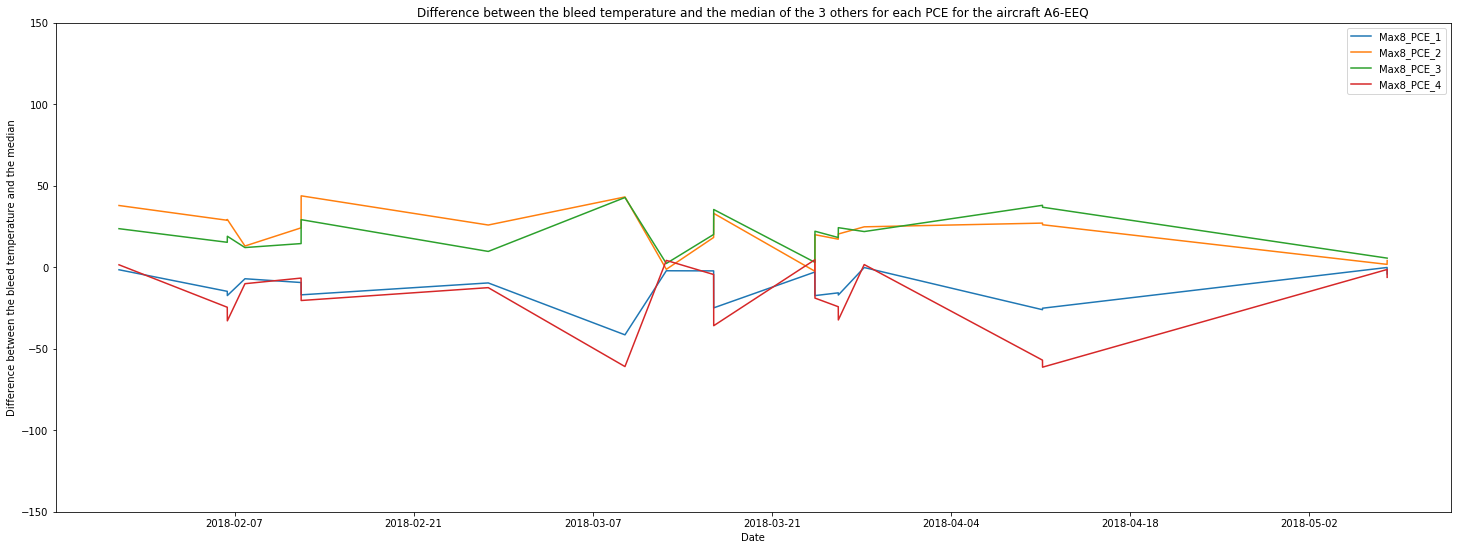

A6-EDA 28 / 89


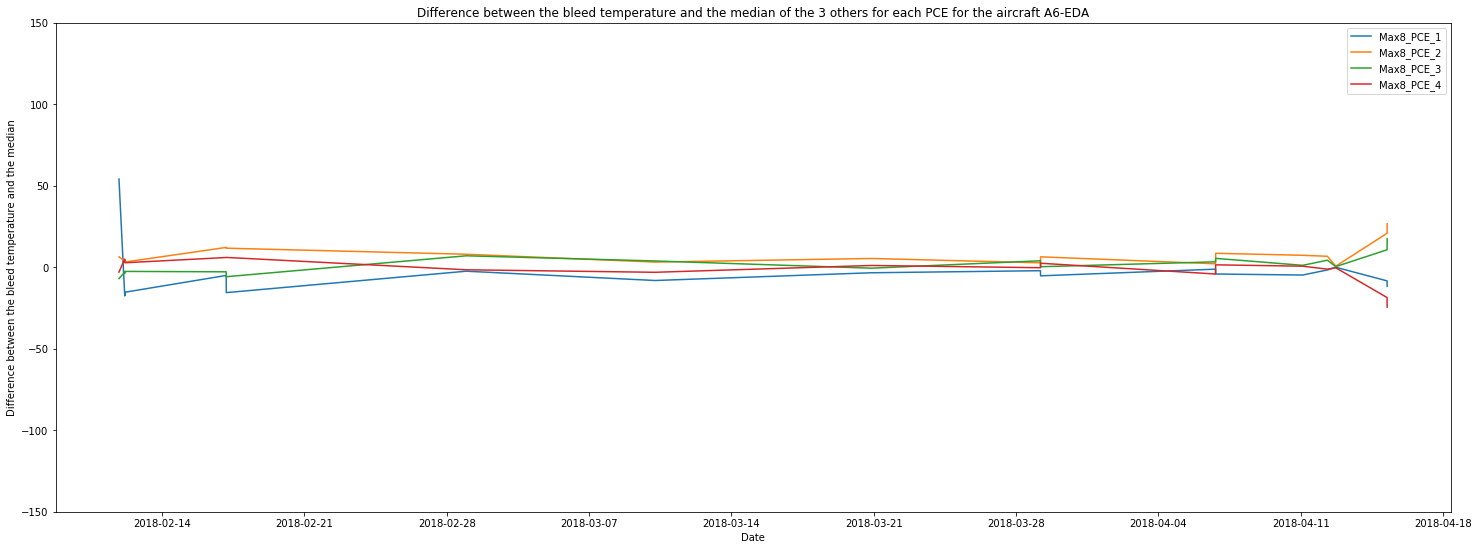

A6-EEO 29 / 89


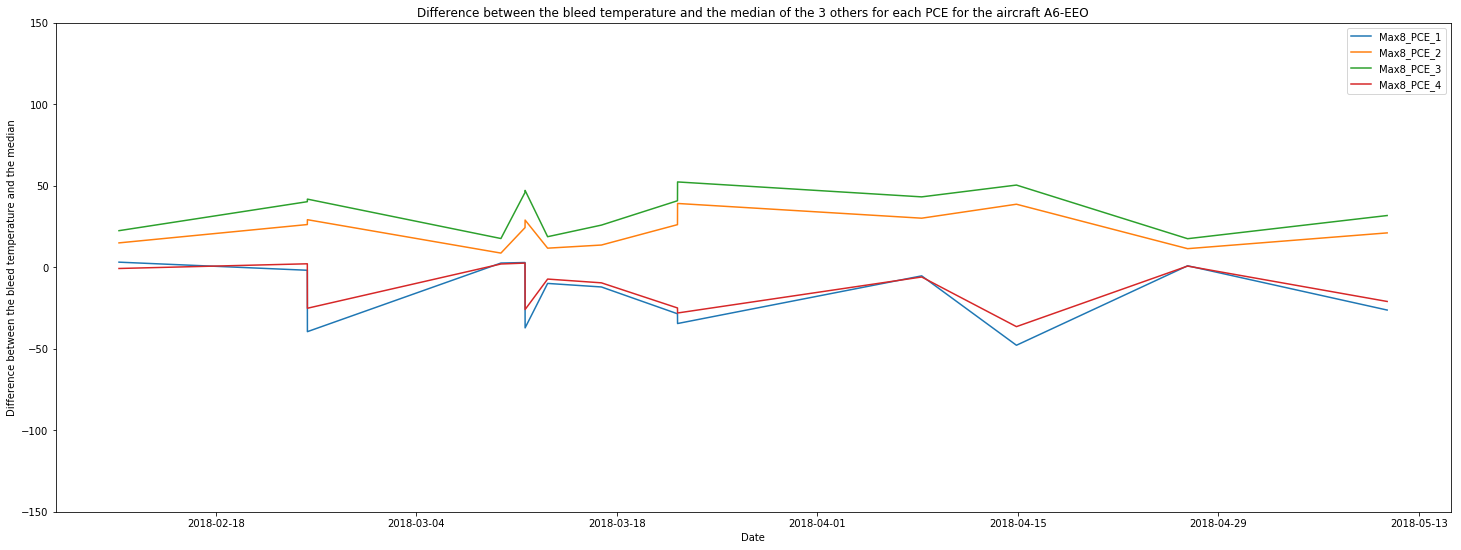

A6-EOZ 30 / 89


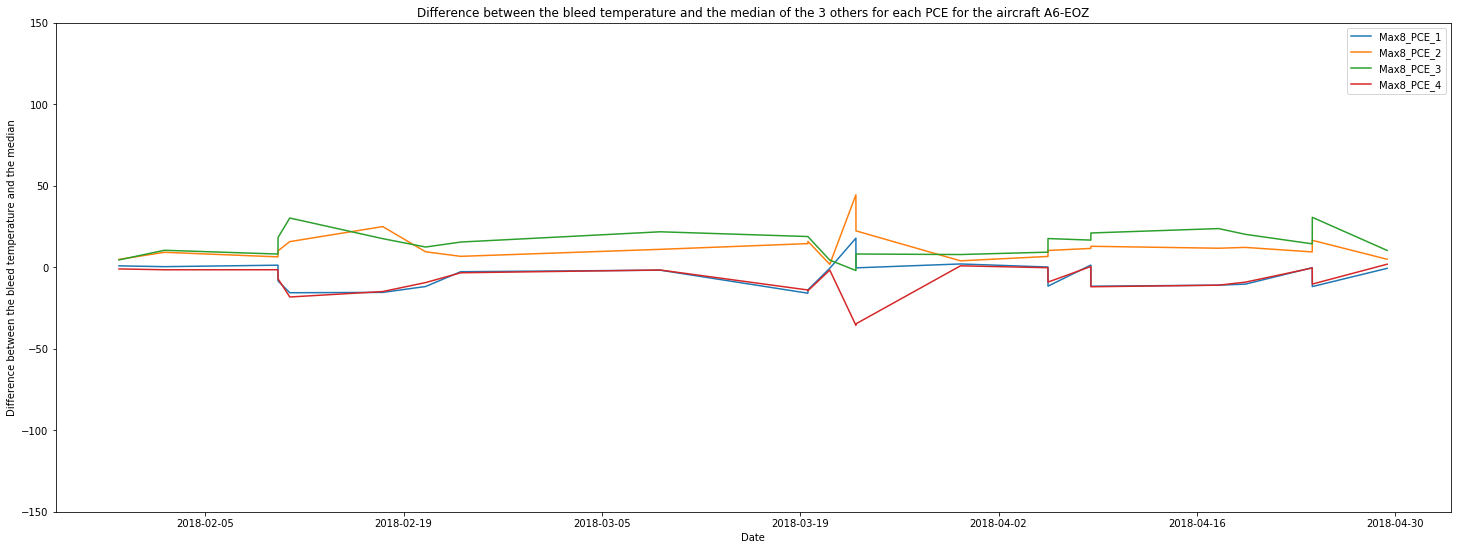

A6-EUA 31 / 89


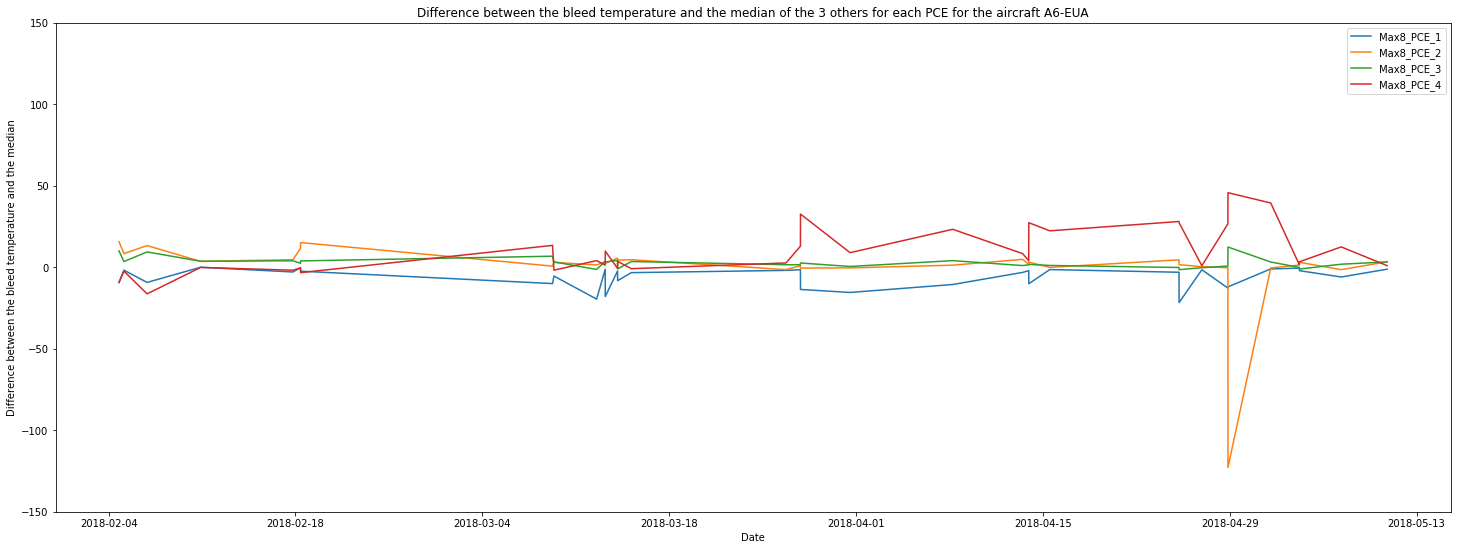

A6-EEM 32 / 89


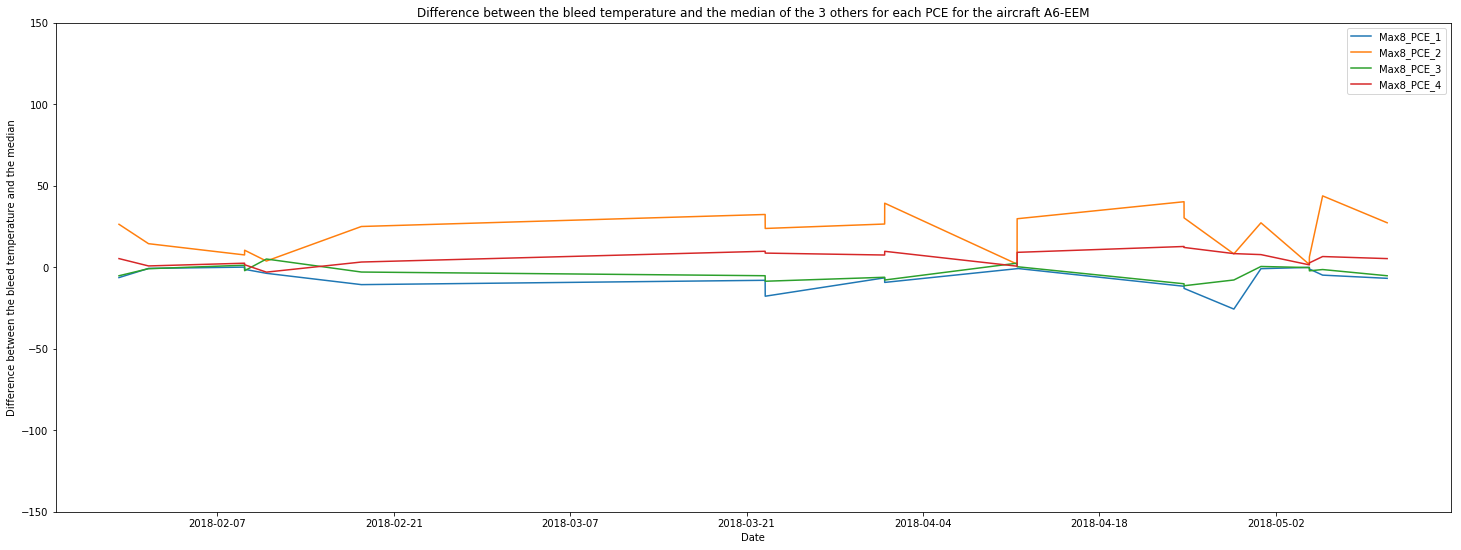

A6-EDS 33 / 89


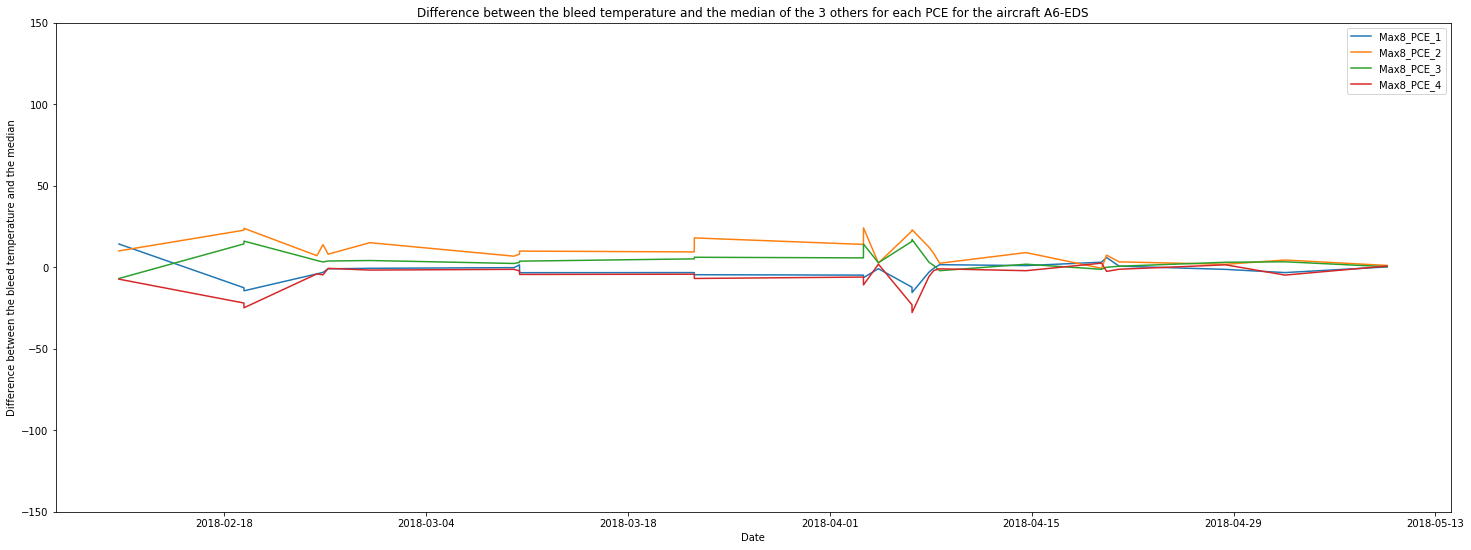

A6-EEJ 34 / 89


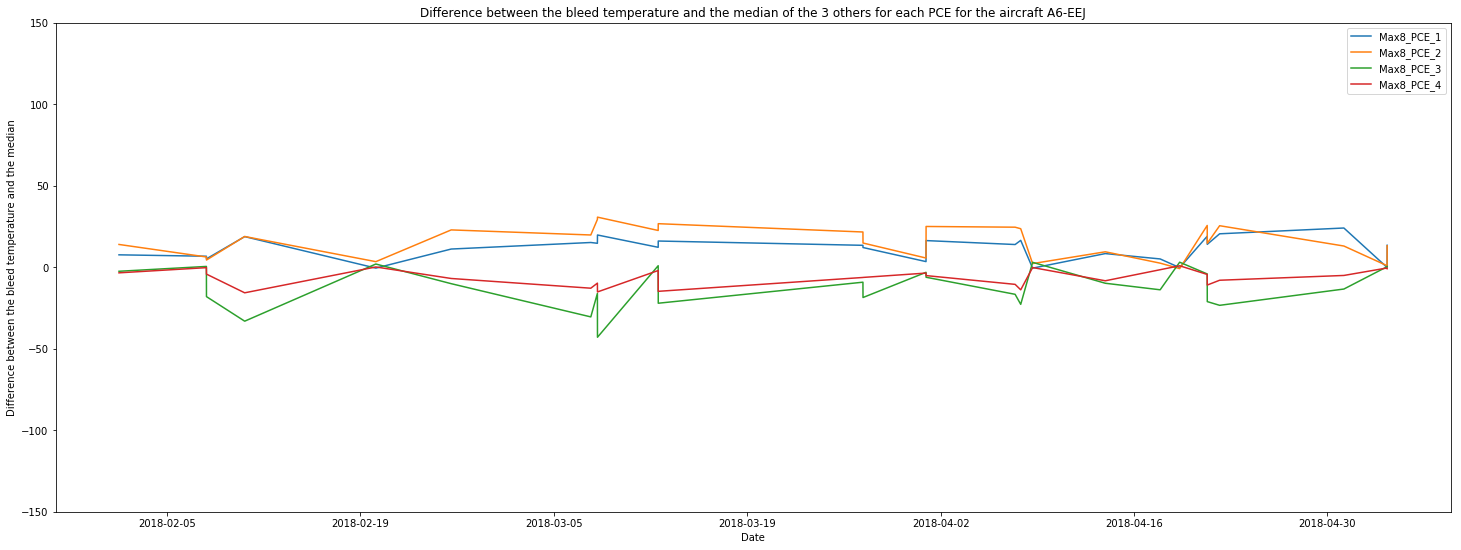

A6-EEL 35 / 89


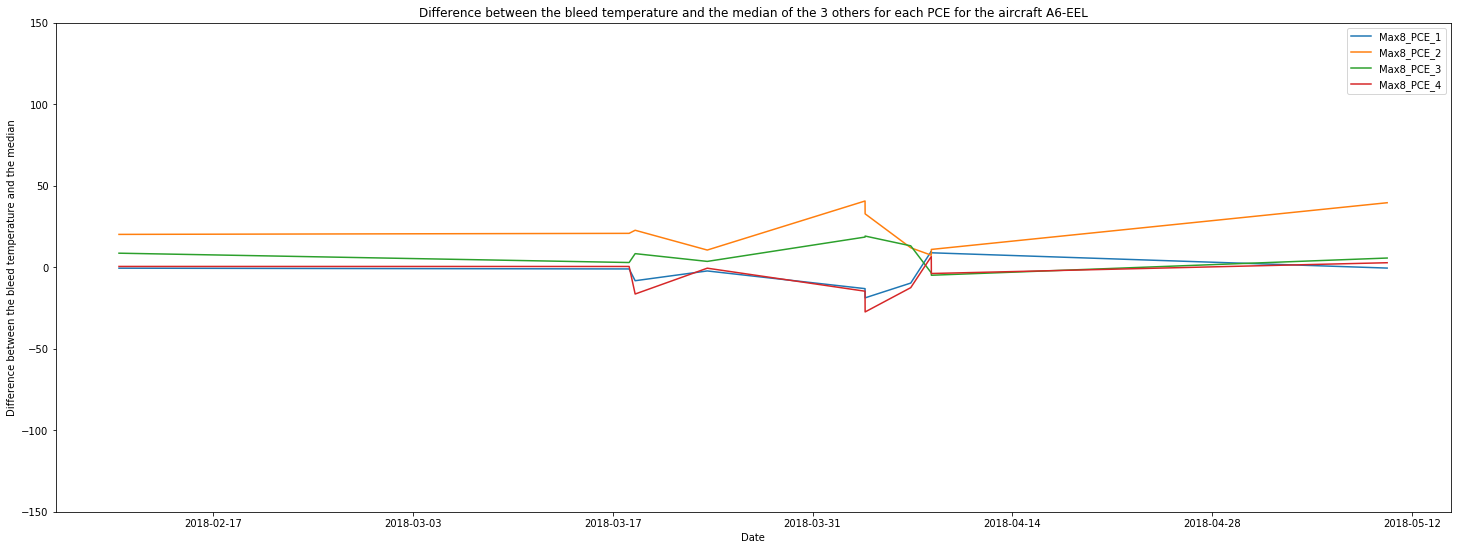

A6-EOF 36 / 89


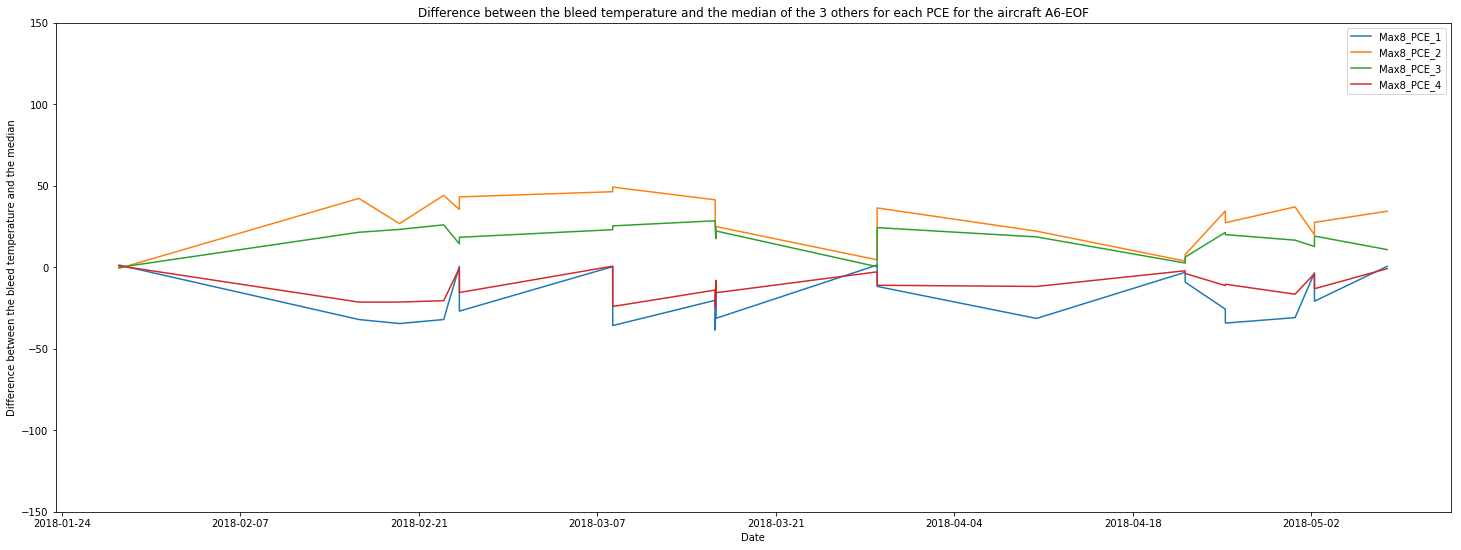

A6-EDP 37 / 89


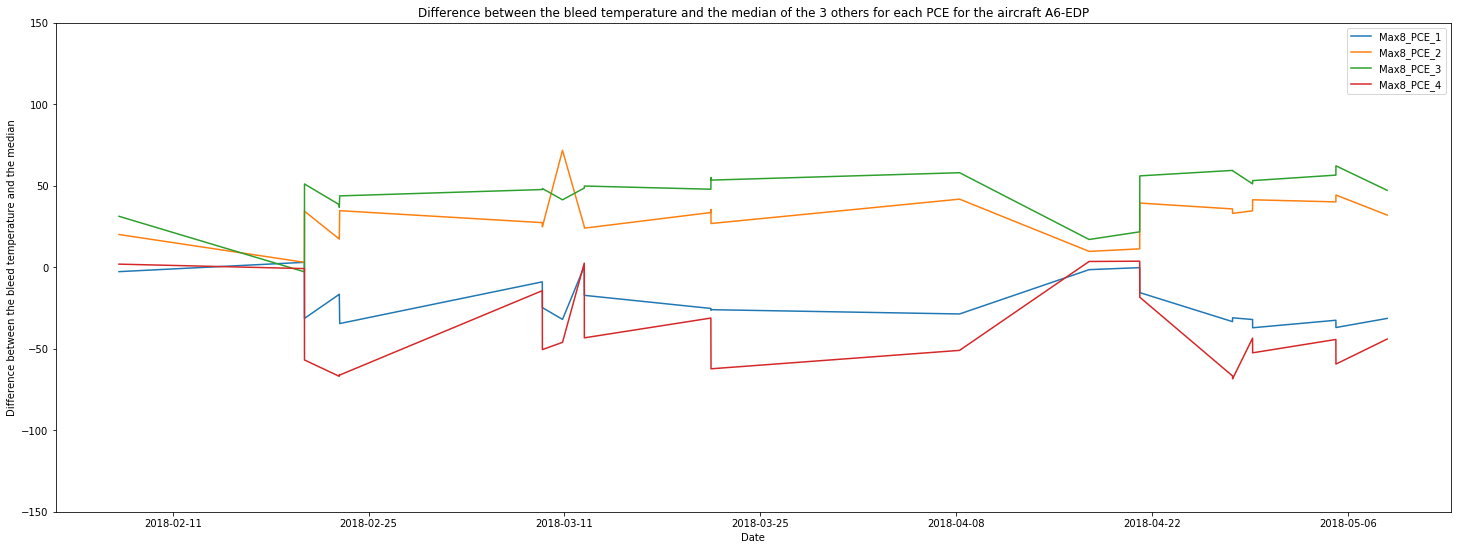

A6-EDZ 38 / 89


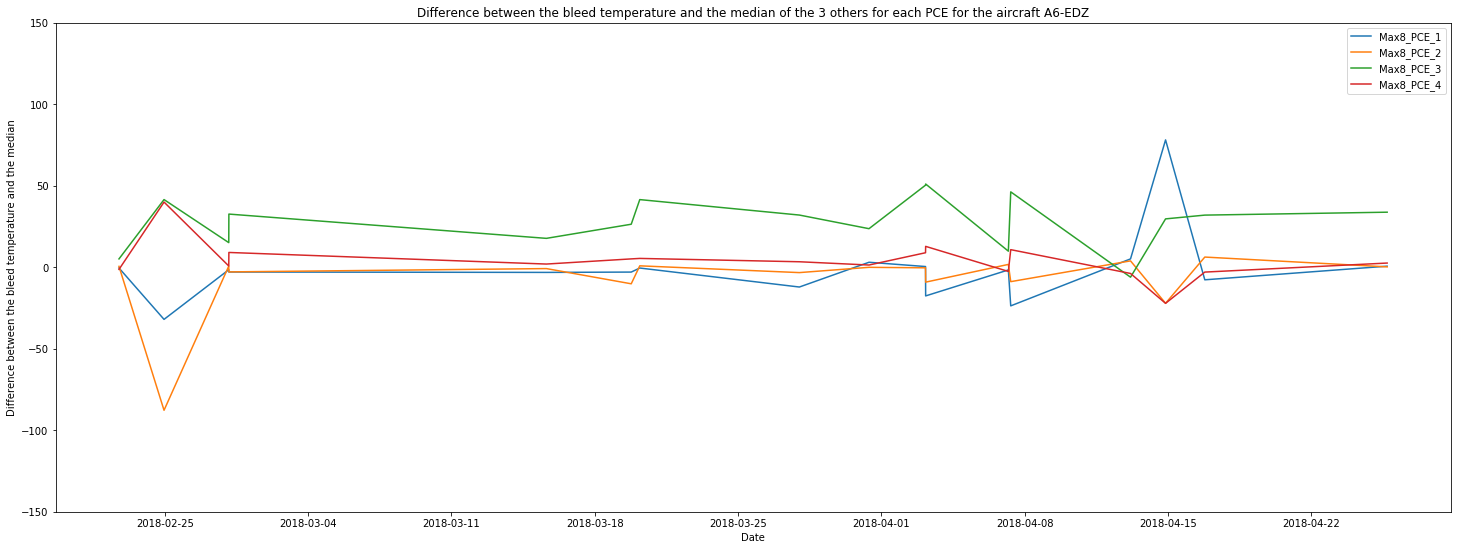

A6-EOW 39 / 89


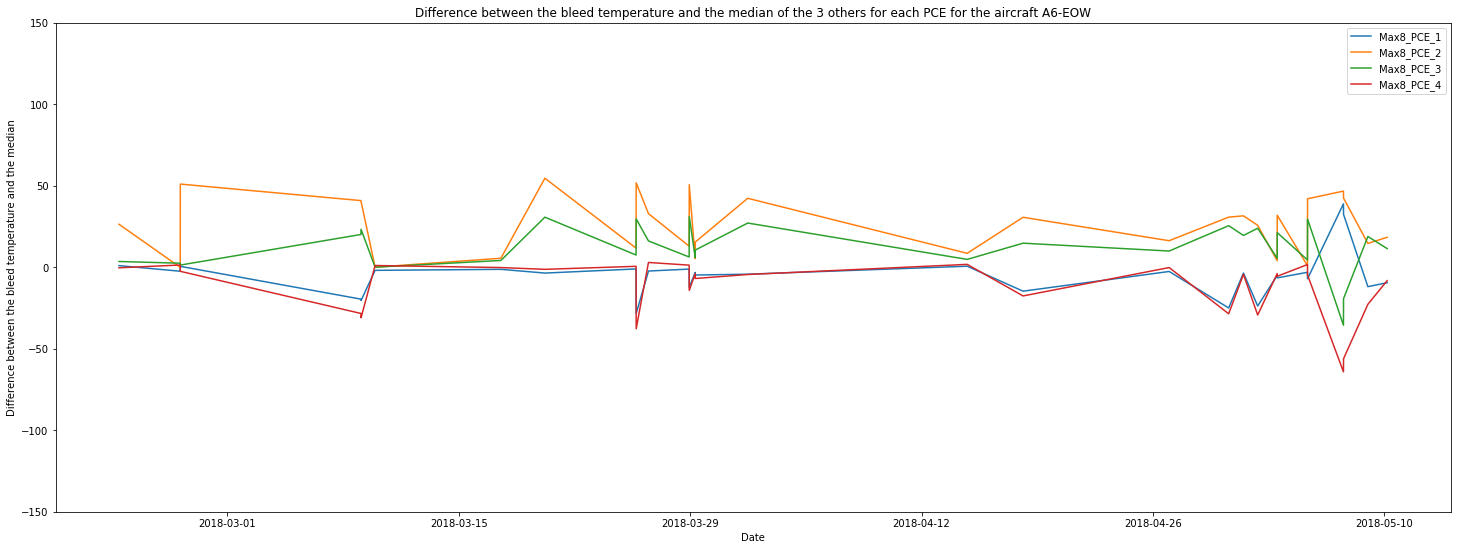

A6-EUH 40 / 89


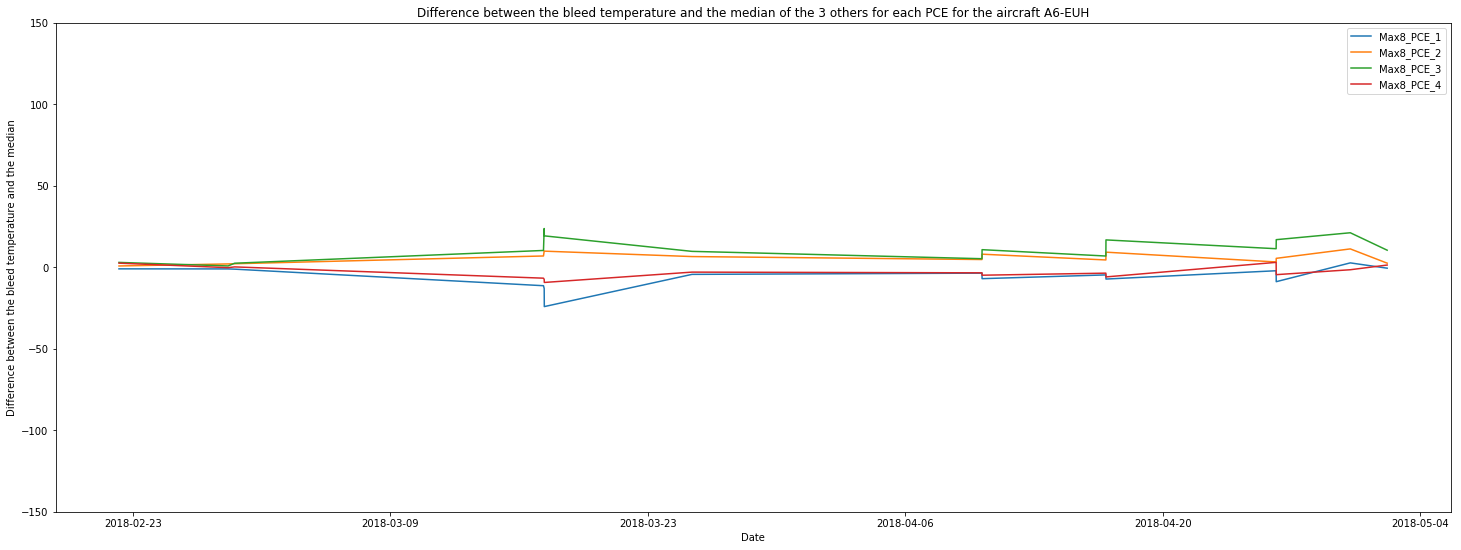

A6-EDI 41 / 89


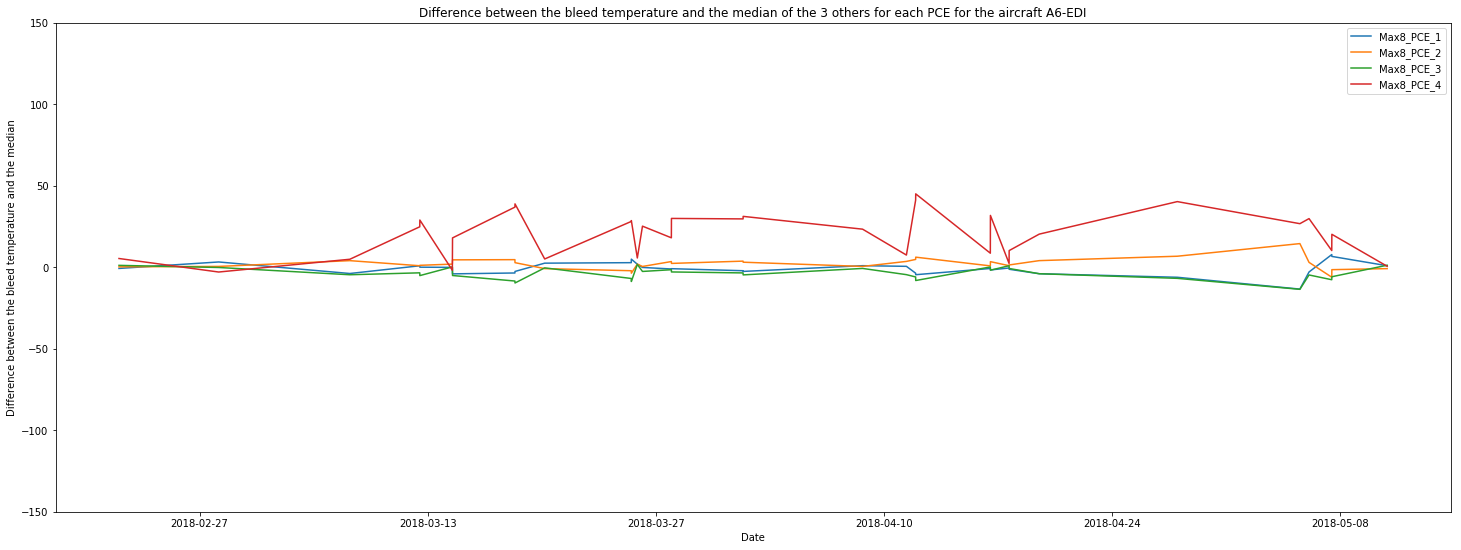

A6-EOA 42 / 89


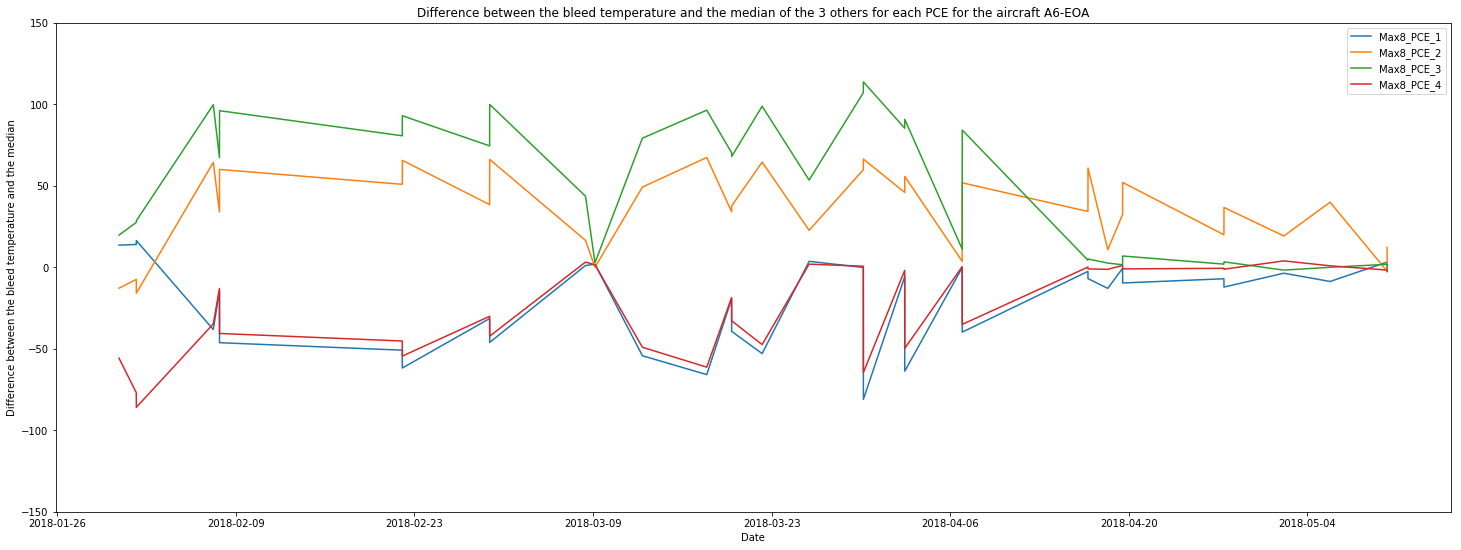

A6-EOE 43 / 89


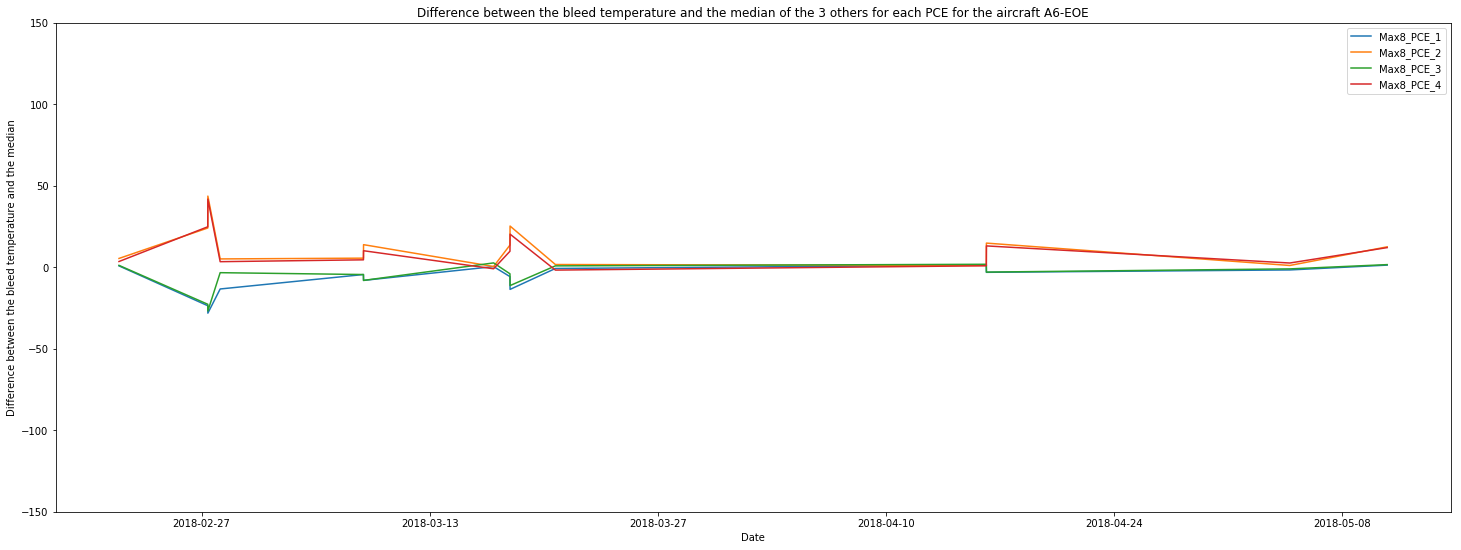

A6-EDY 44 / 89


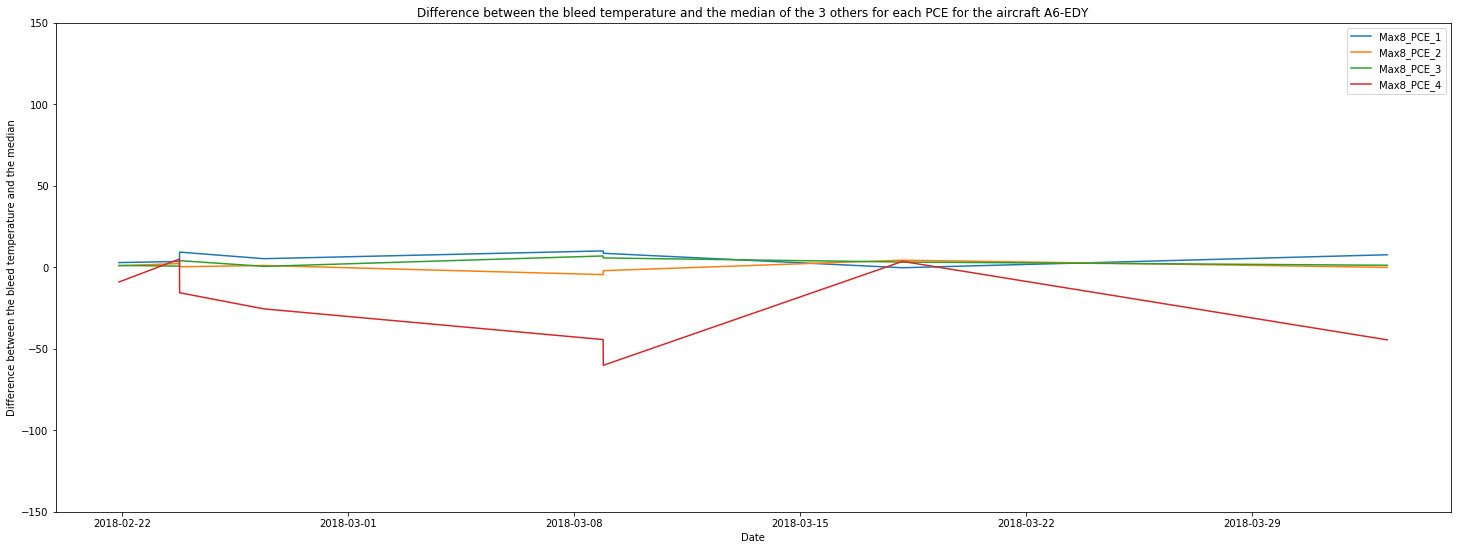

A6-EOV 45 / 89


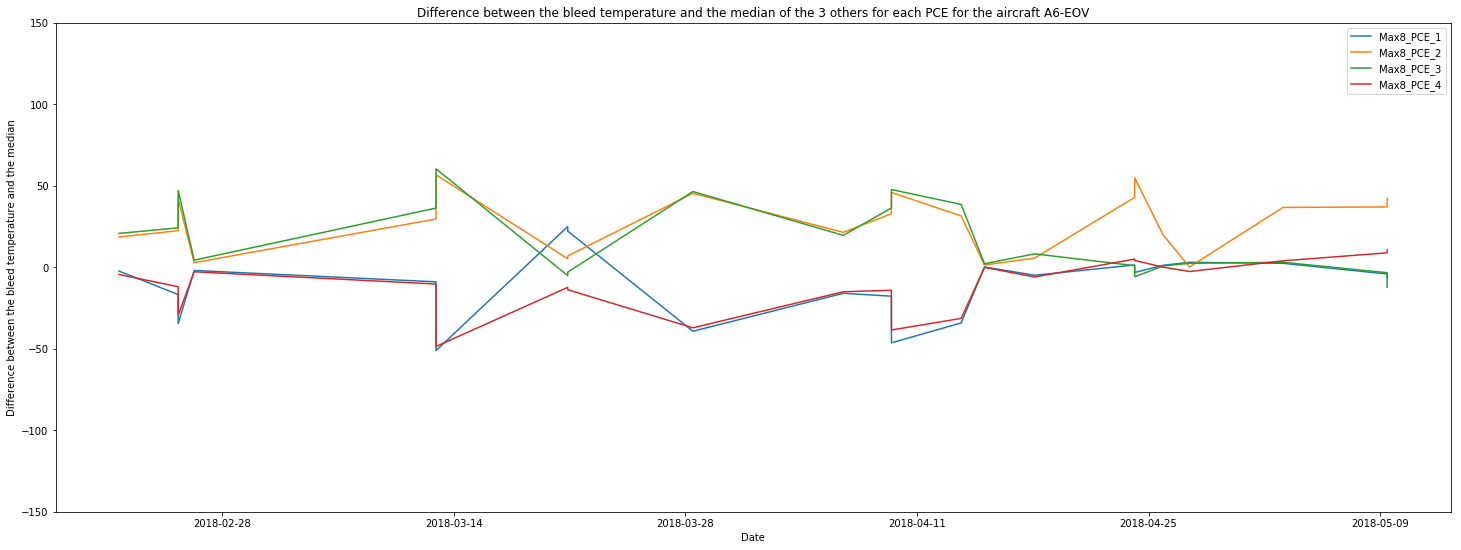

A6-EOR 46 / 89


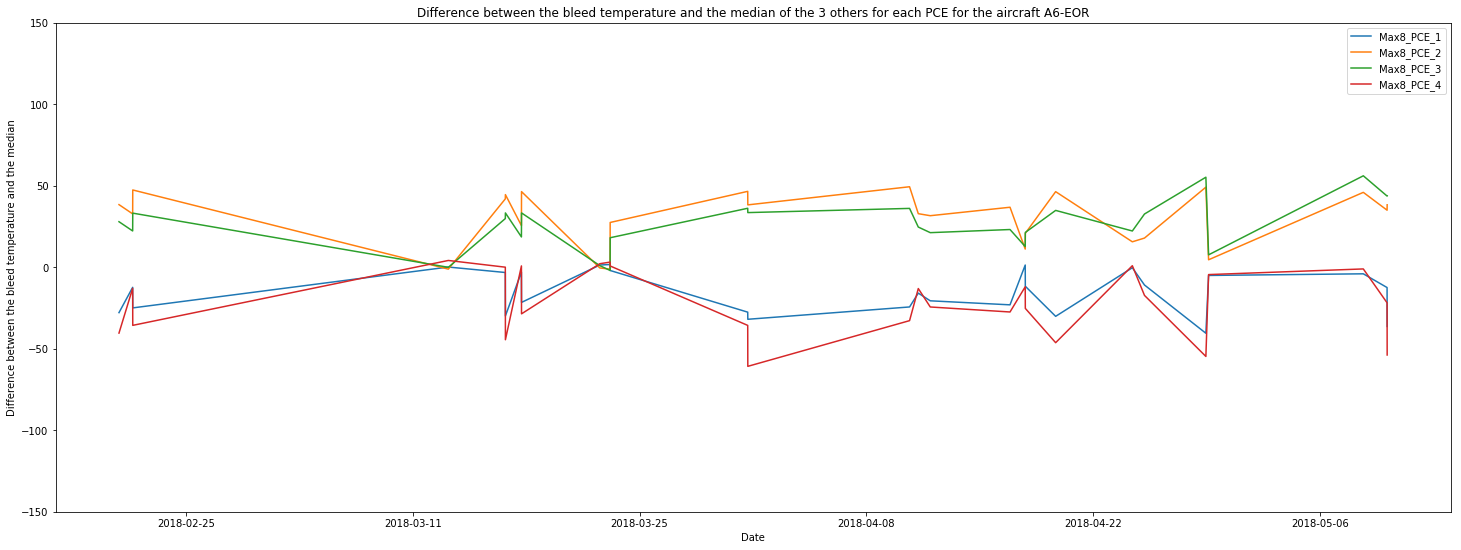

A6-EOQ 47 / 89


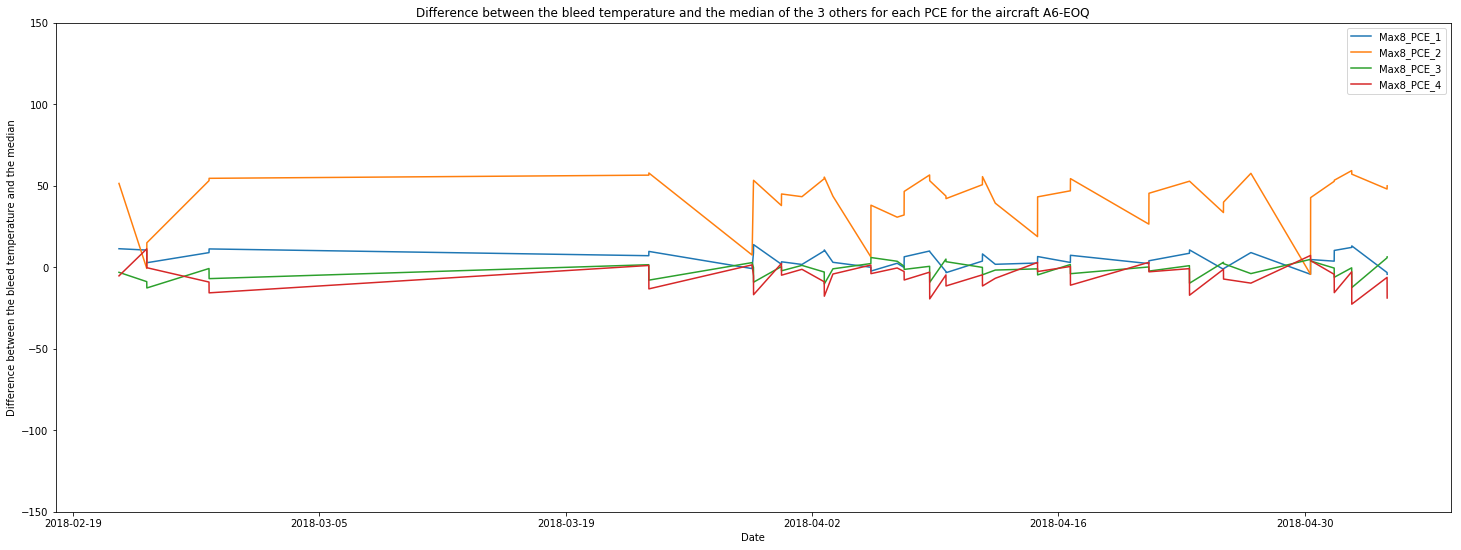

A6-EUC 48 / 89


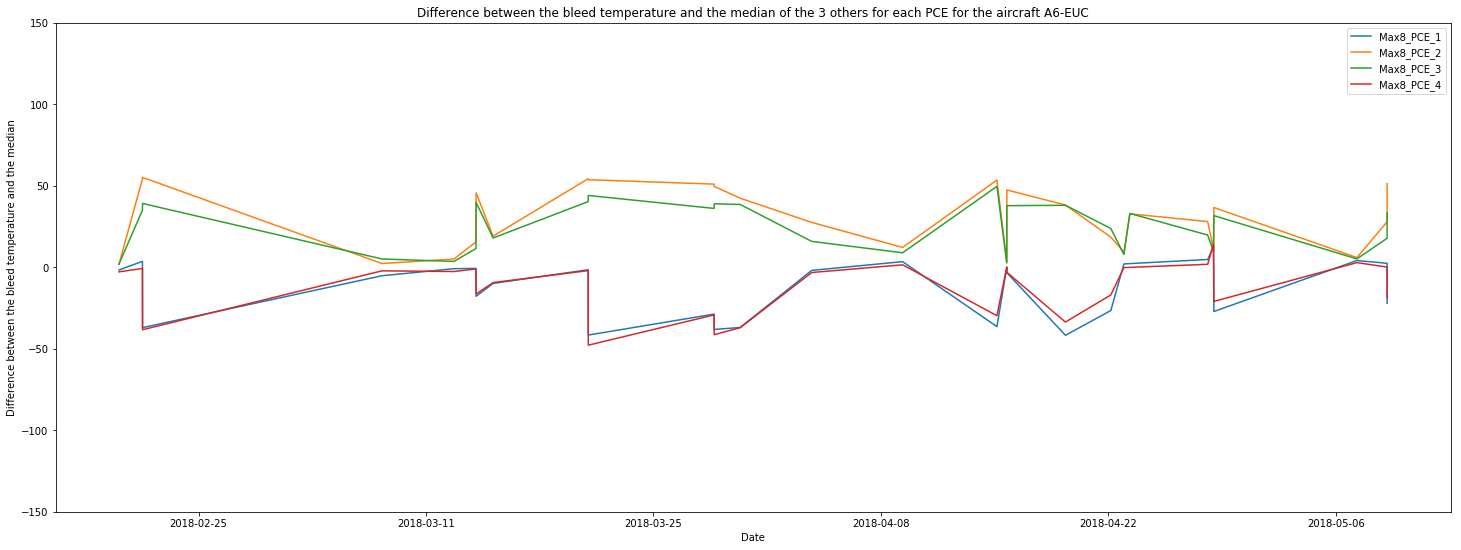

A6-EUL 49 / 89


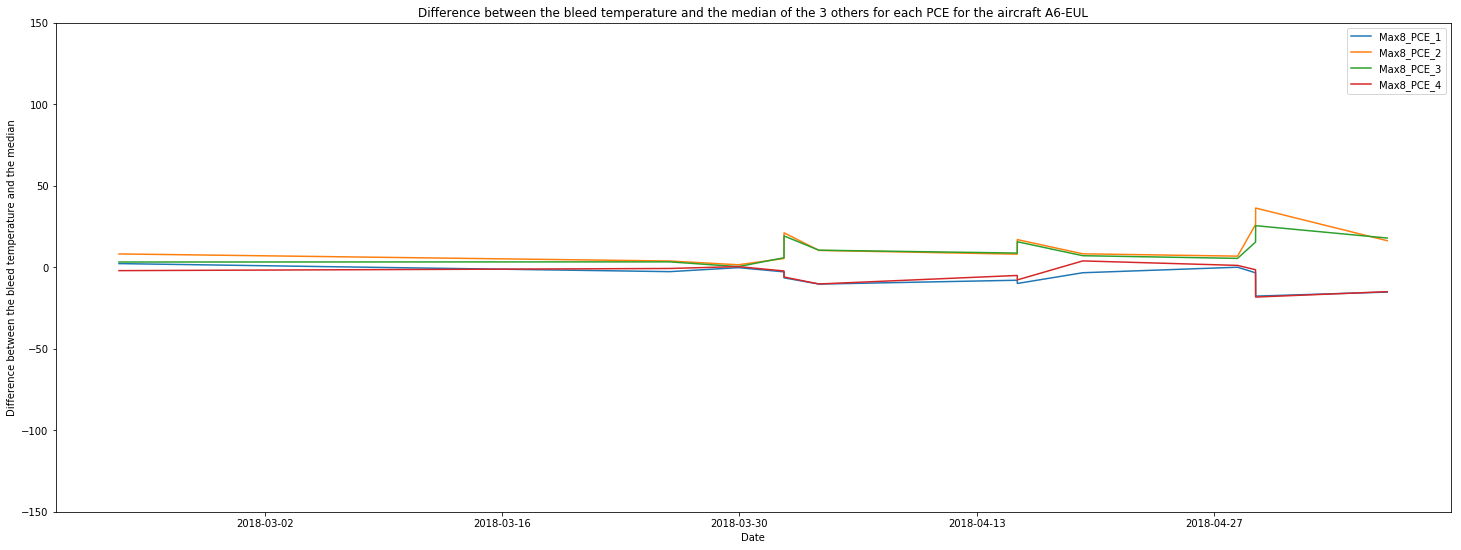

A6-EDT 50 / 89


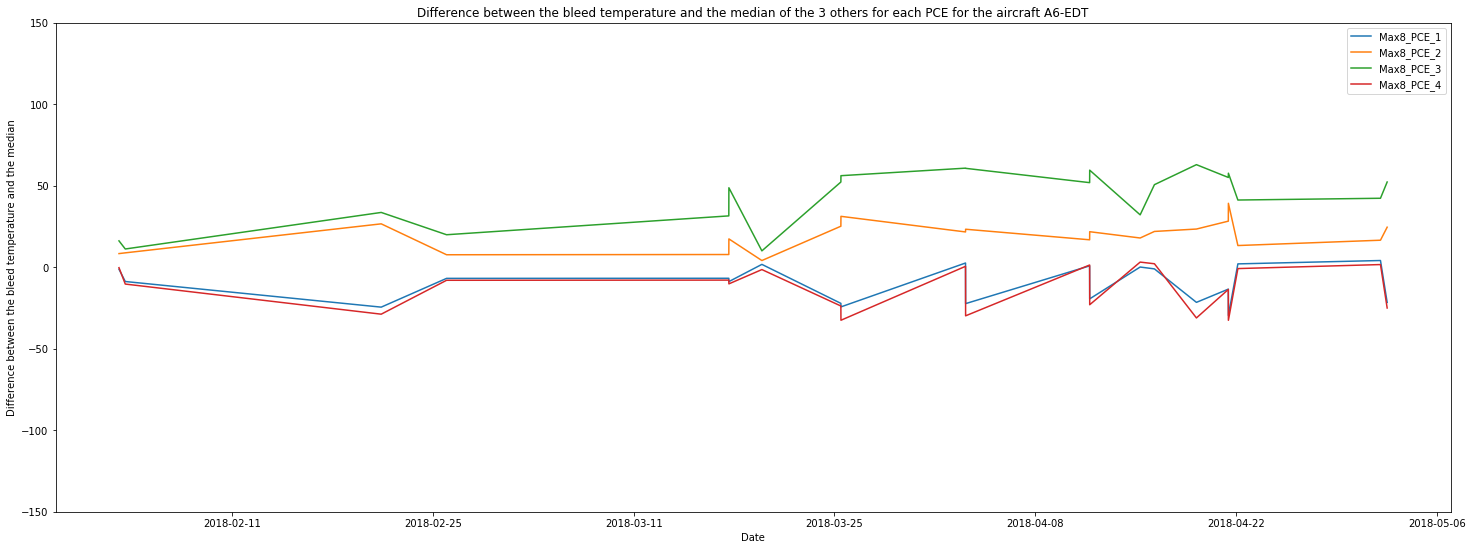

A6-EEY 51 / 89


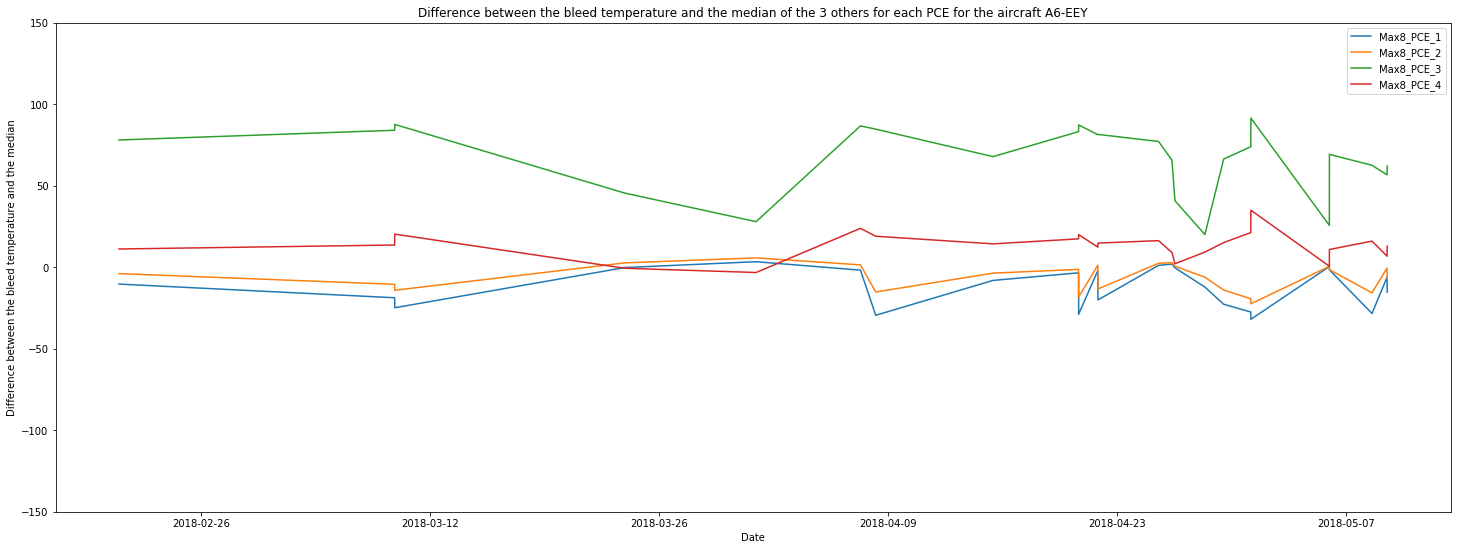

A6-EEN 52 / 89


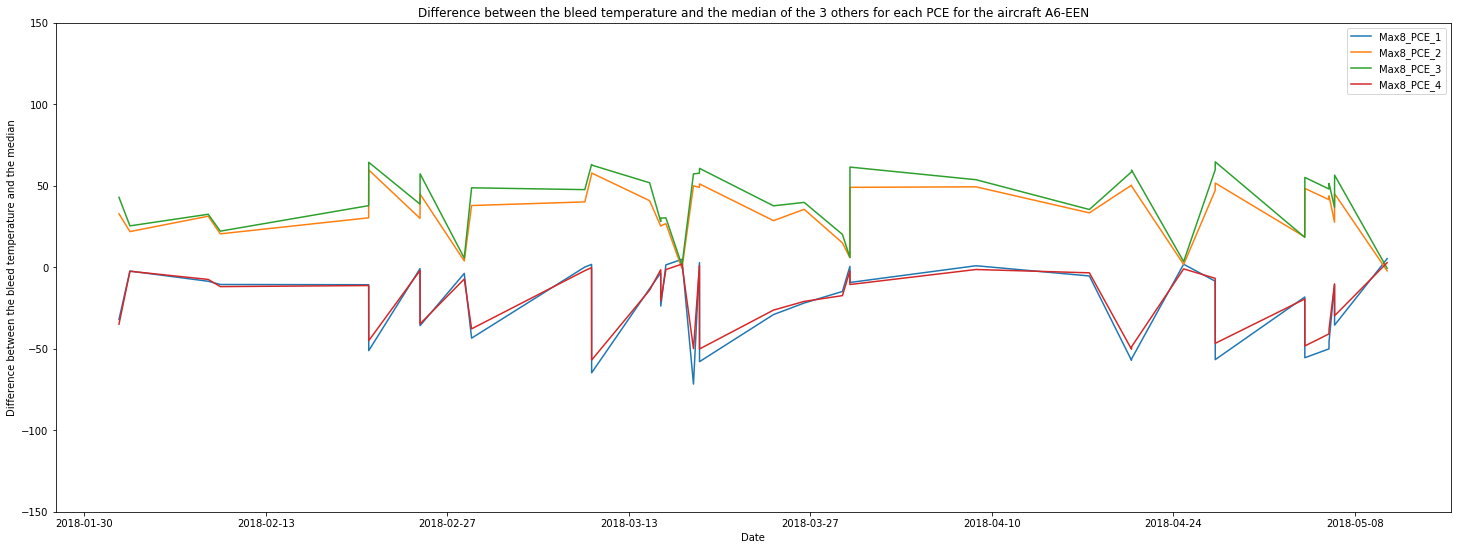

A6-EEE 53 / 89


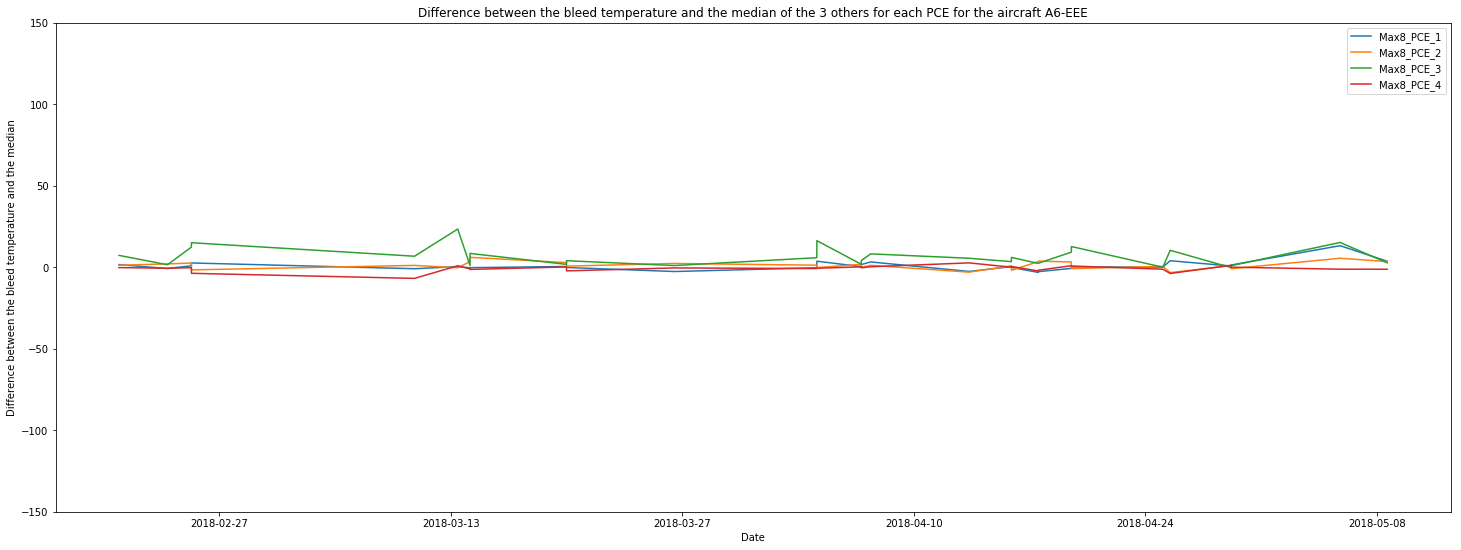

A6-EDG 54 / 89


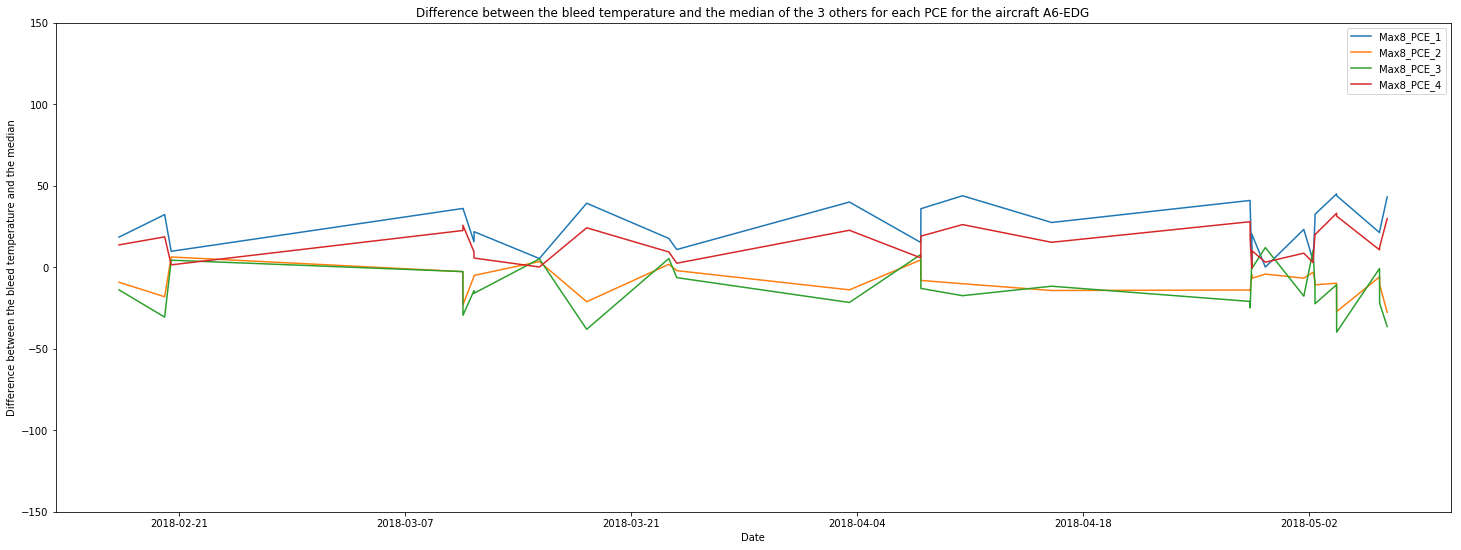

A6-EUG 55 / 89


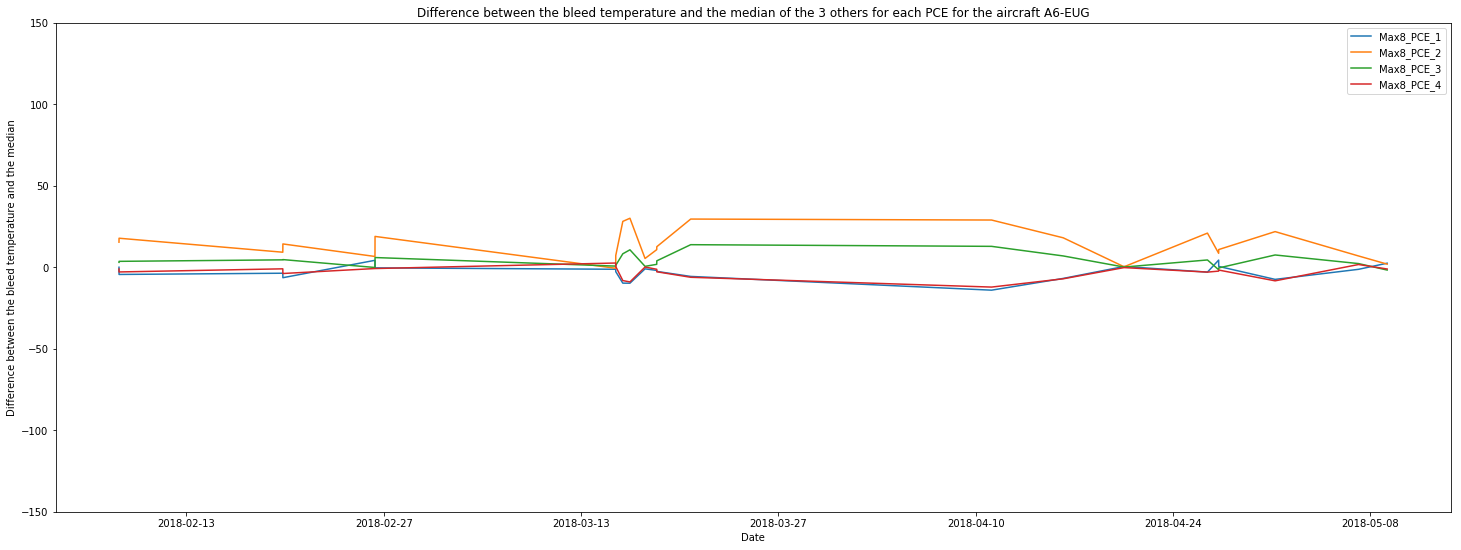

A6-EES 56 / 89


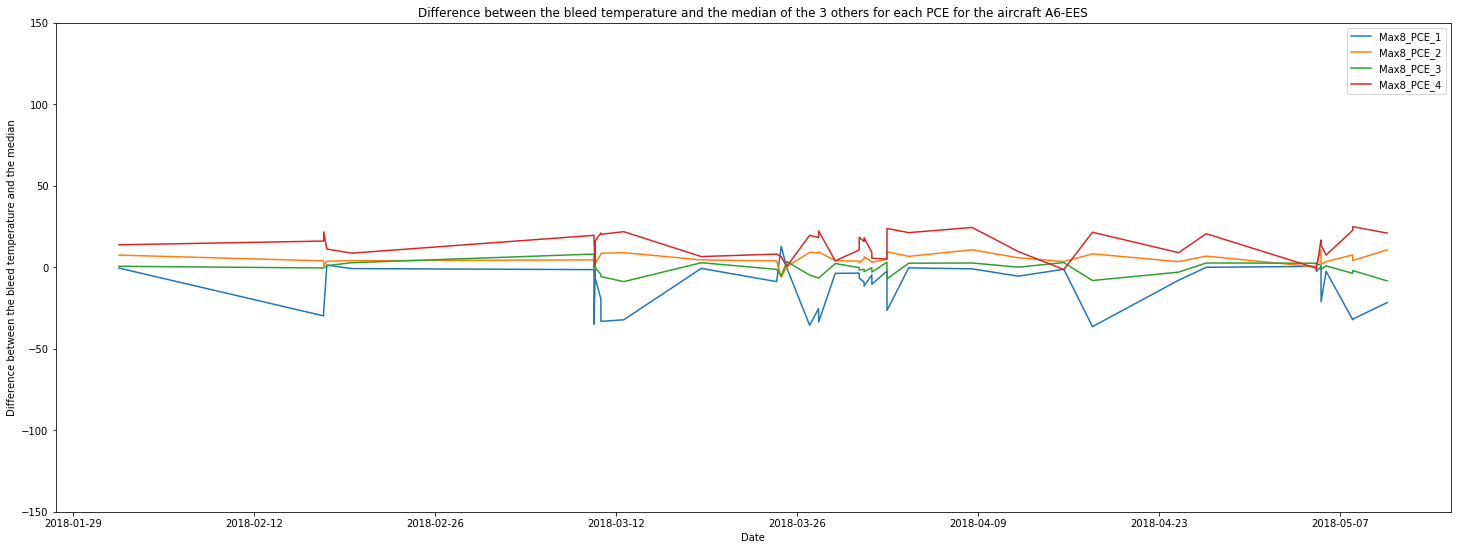

A6-EED 57 / 89


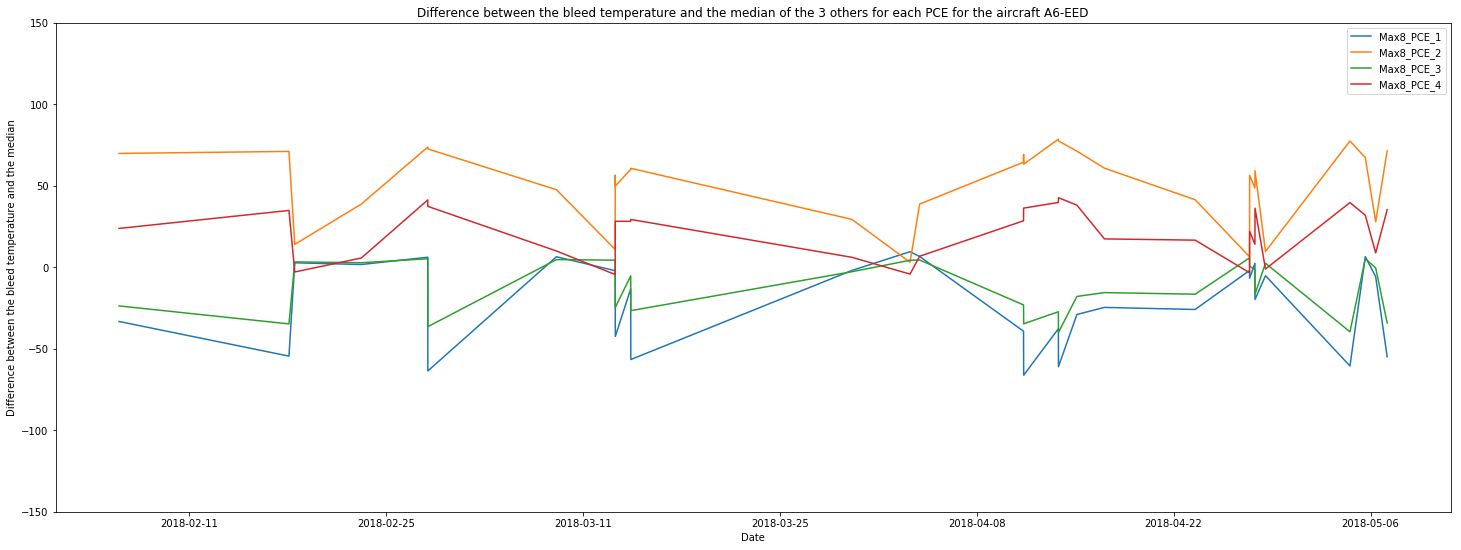

A6-EDN 58 / 89


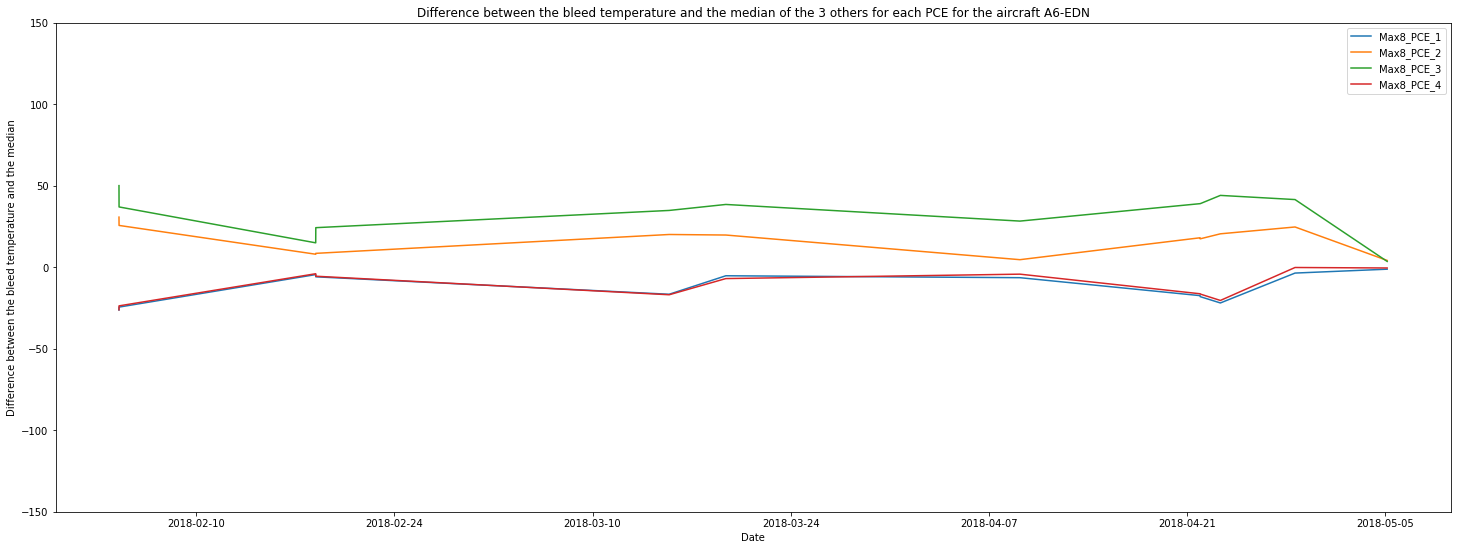

A6-EUK 59 / 89


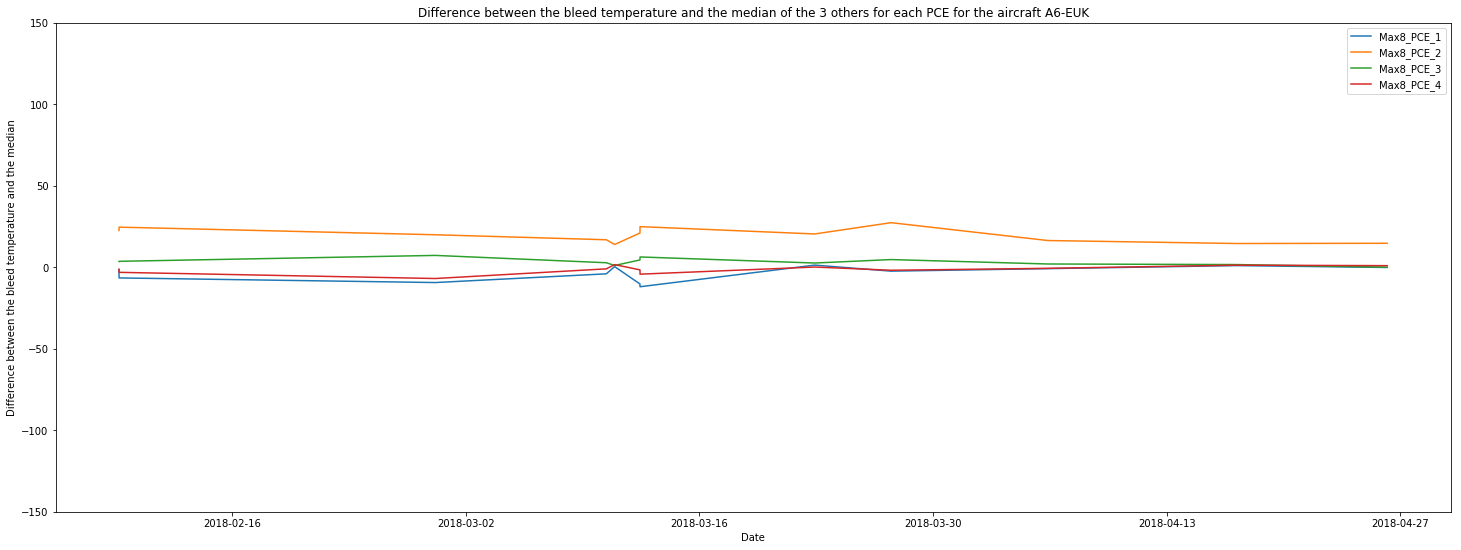

A6-EDV 60 / 89


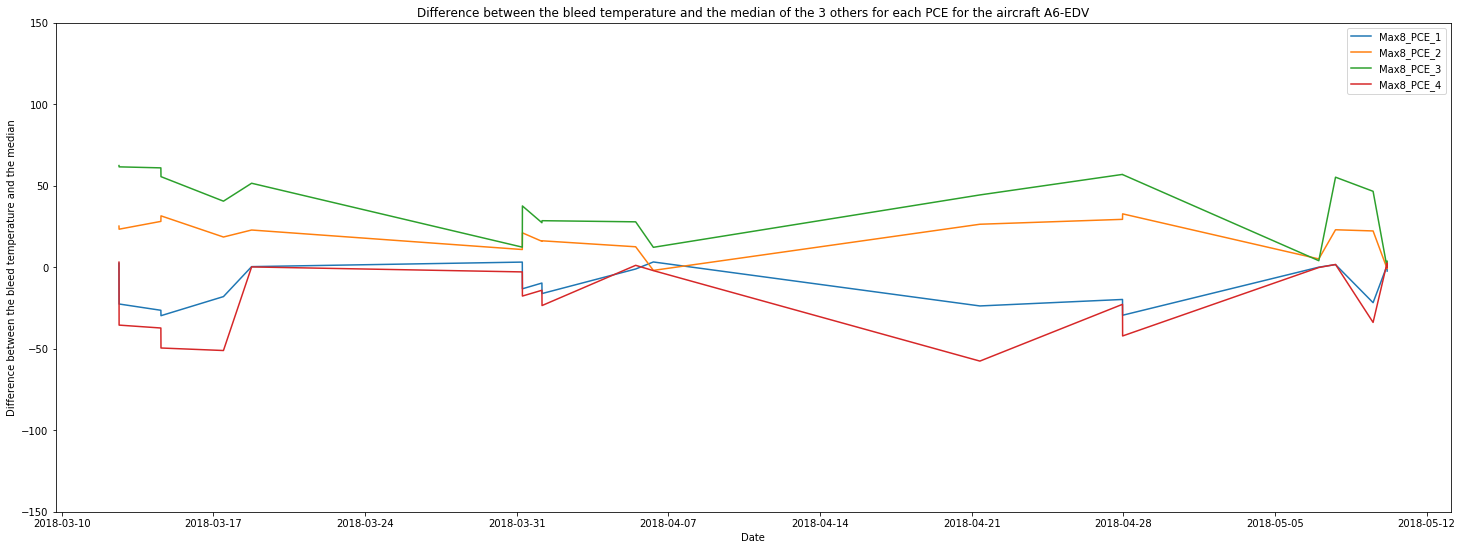

A6-EDF 61 / 89


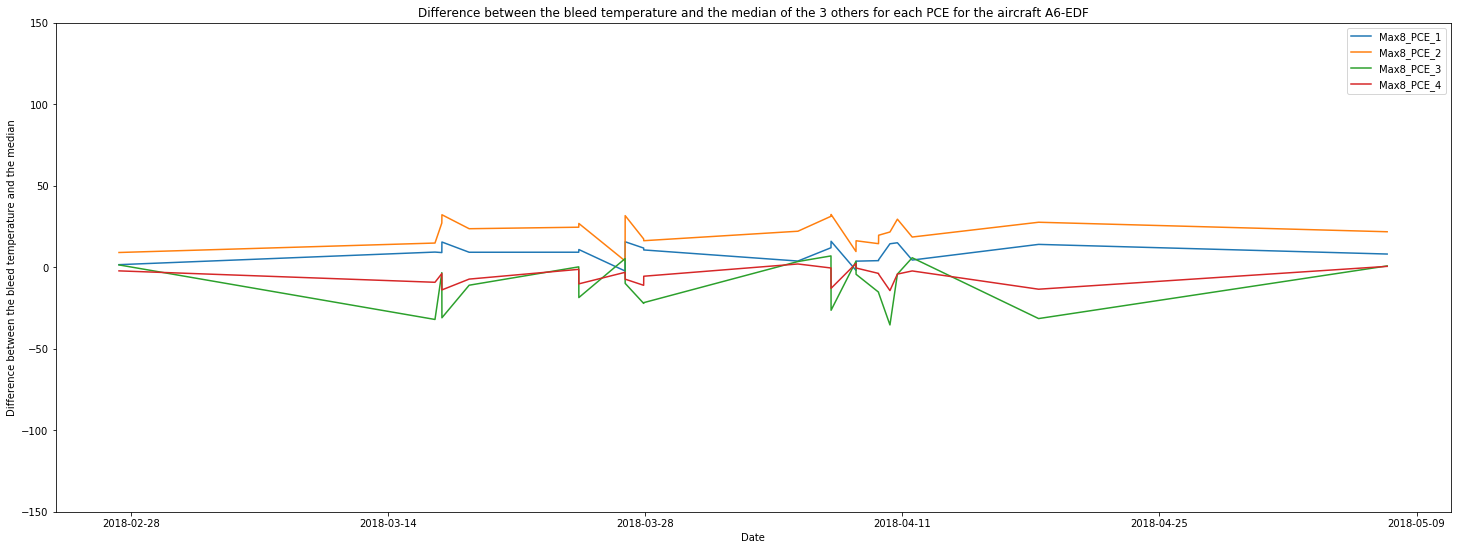

A6-EOT 62 / 89


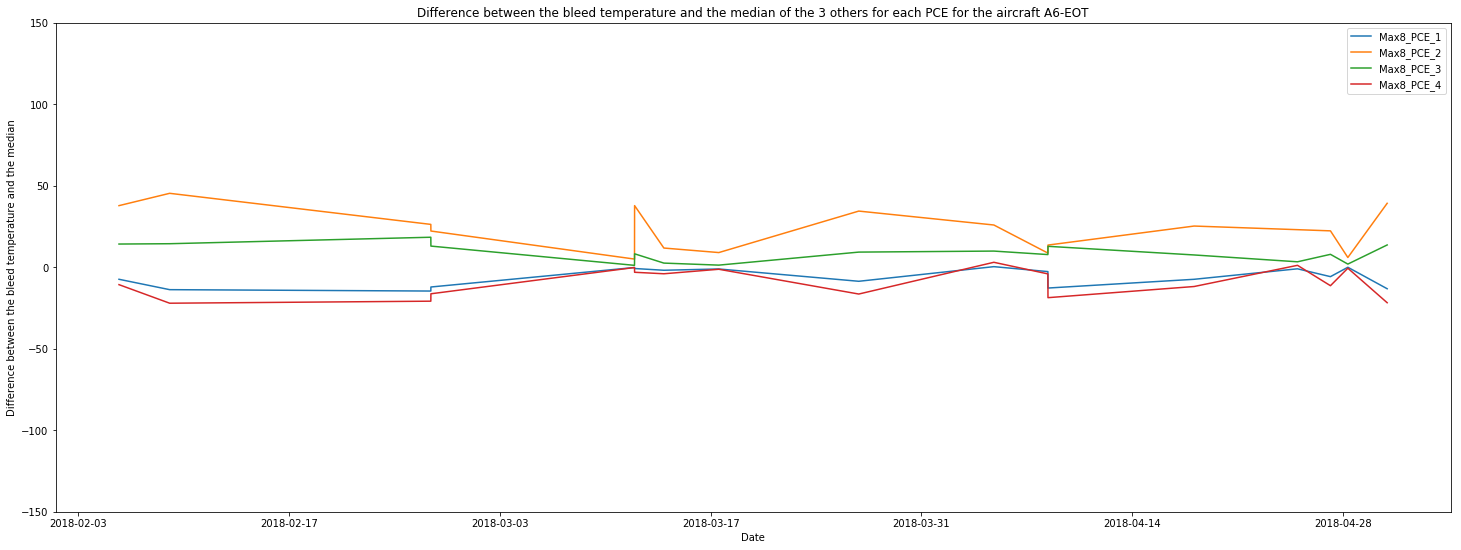

A6-EDB 63 / 89


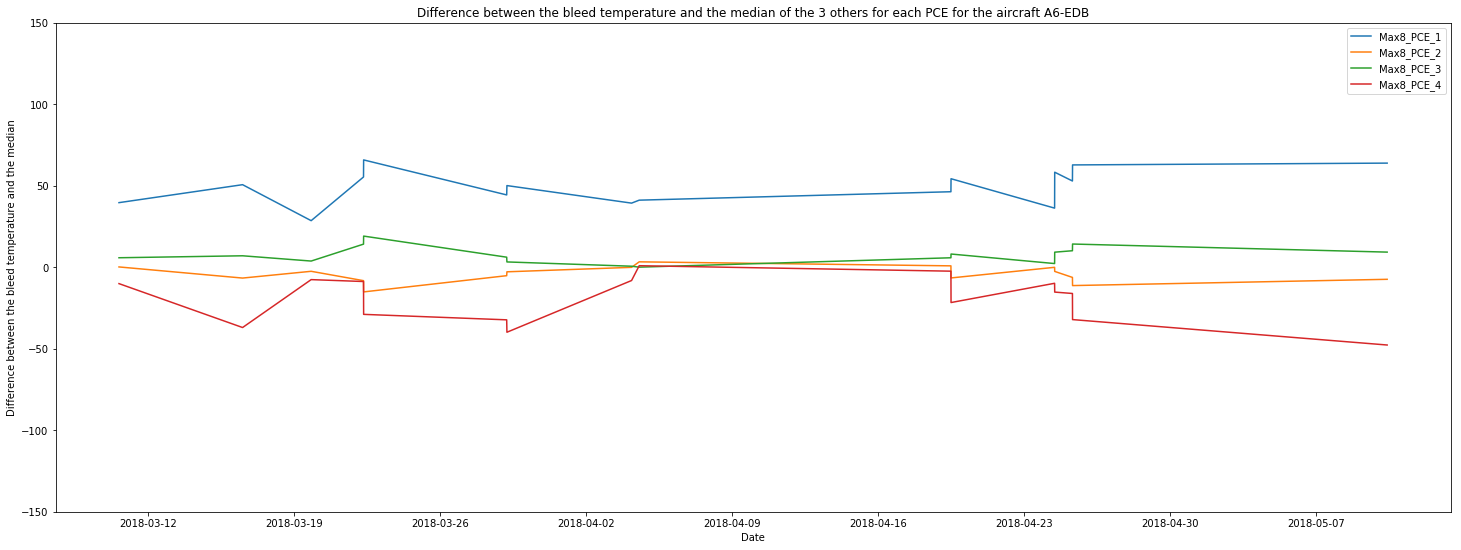

A6-EEA 64 / 89


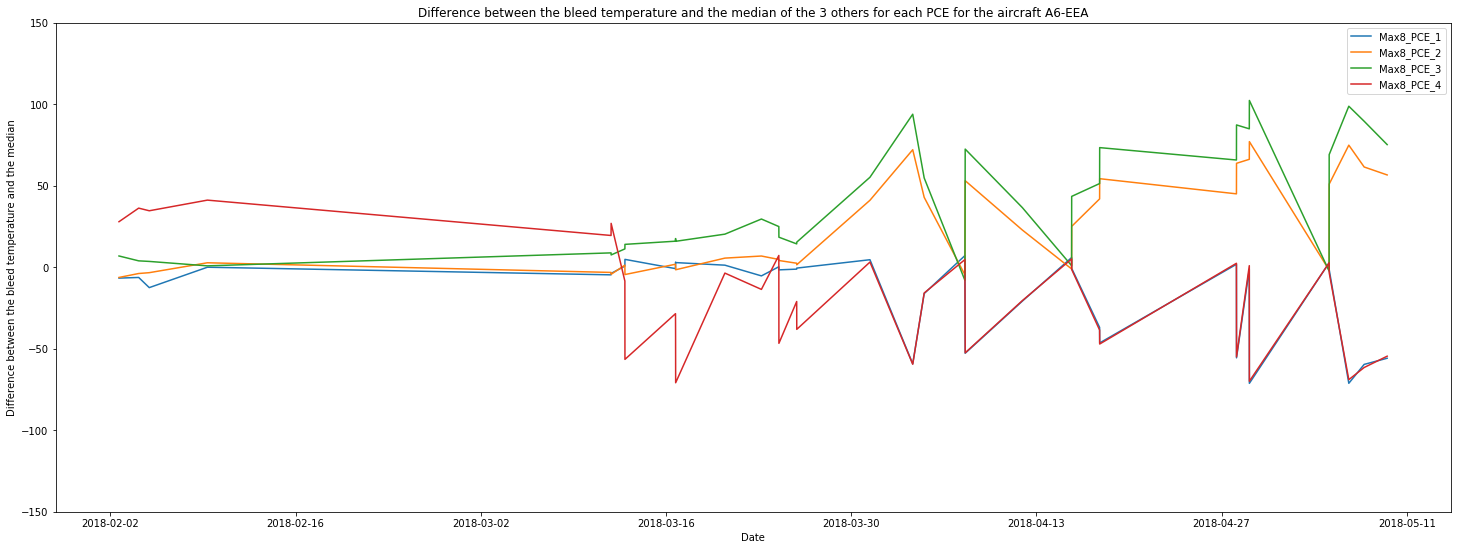

A6-EOJ 65 / 89


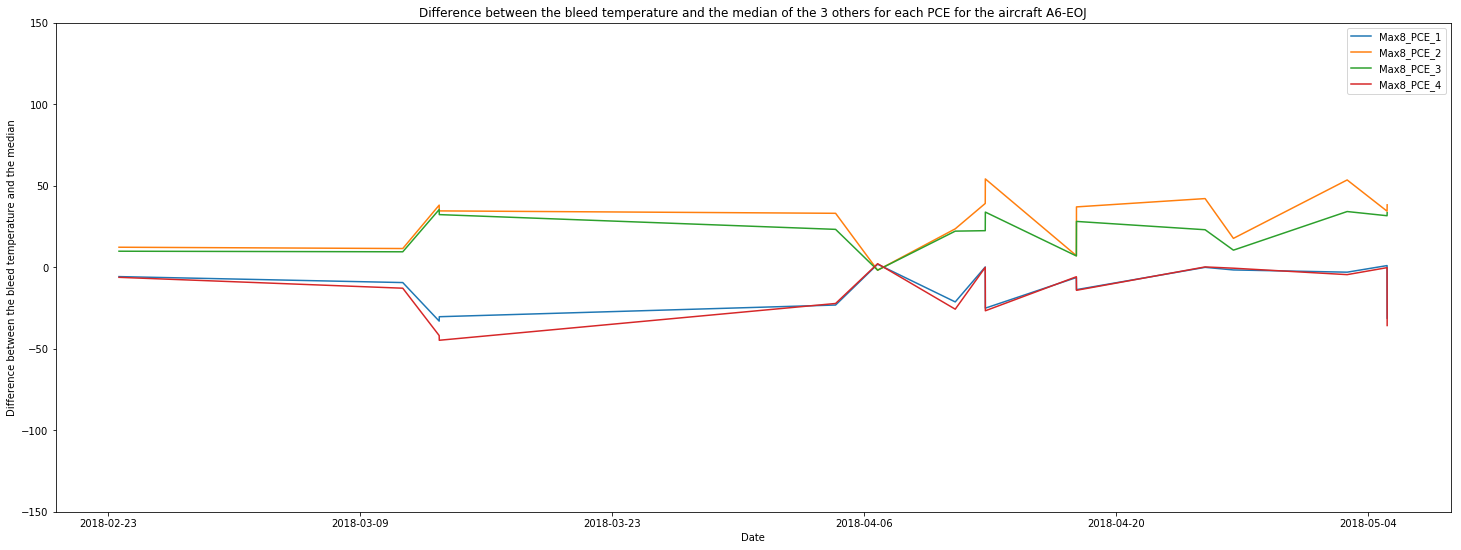

A6-EEC 66 / 89


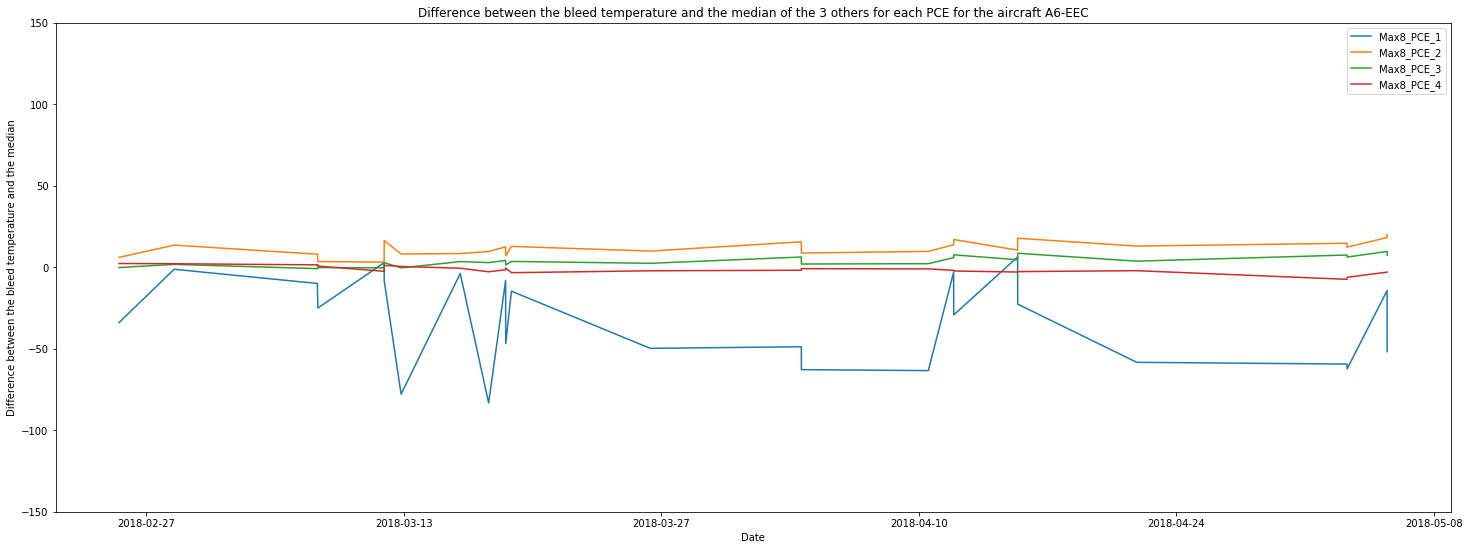

A6-EUI 67 / 89


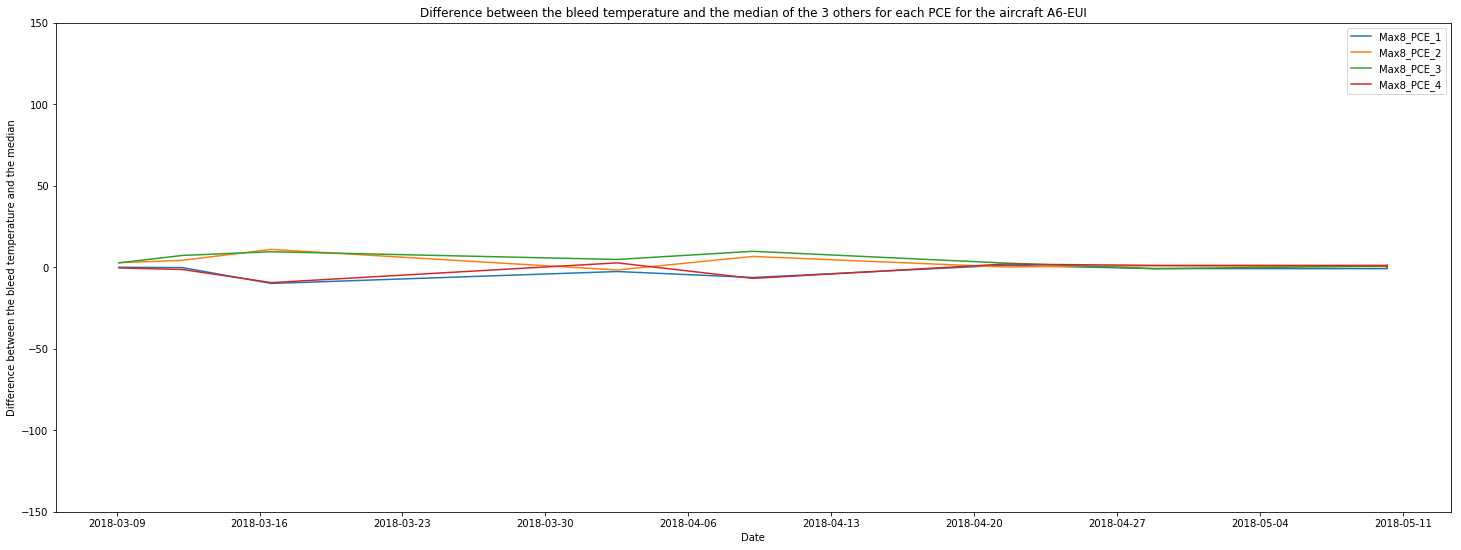

A6-EUB 68 / 89


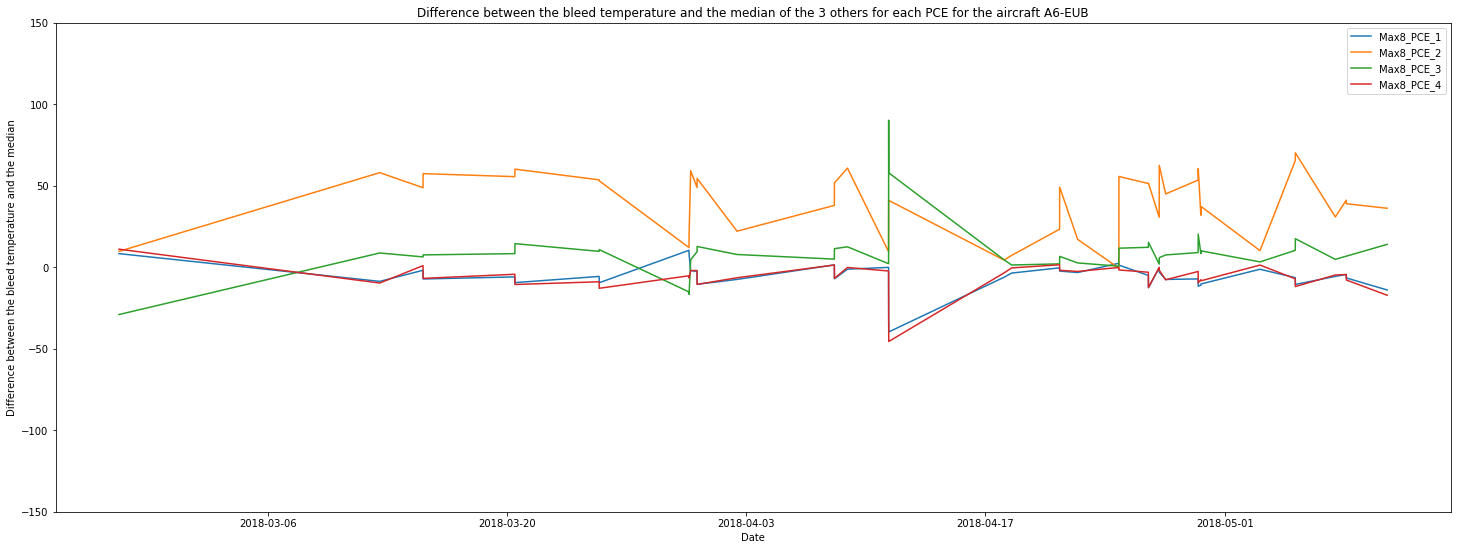

A6-EEK 69 / 89


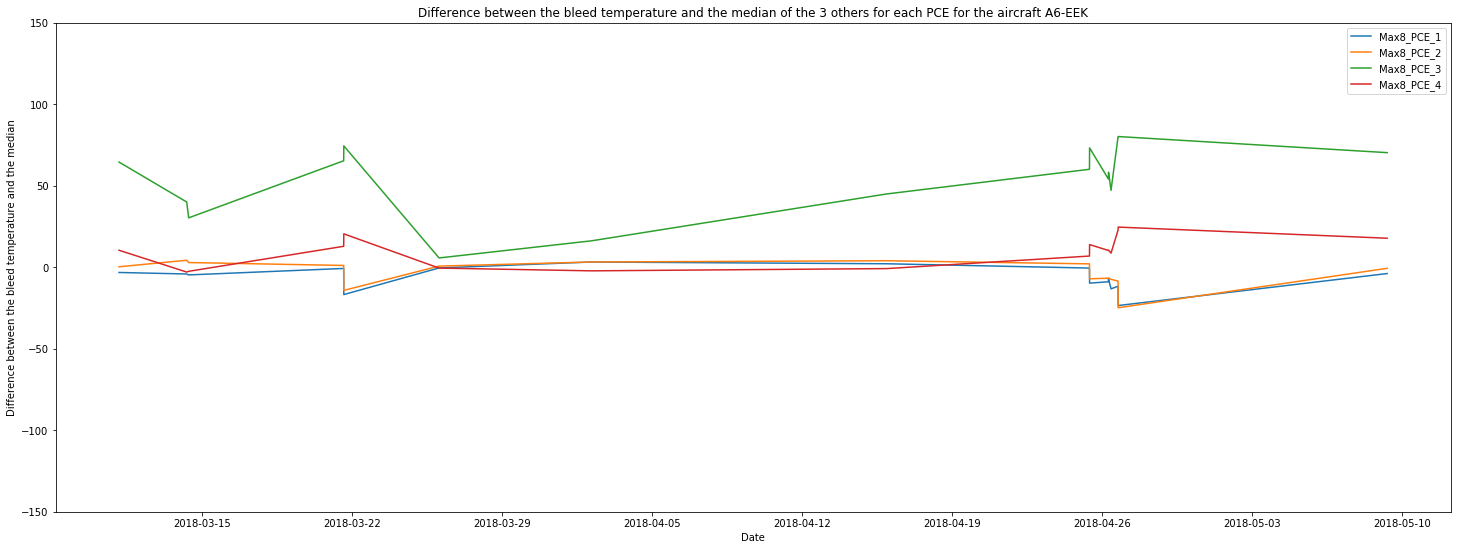

A6-EDQ 70 / 89


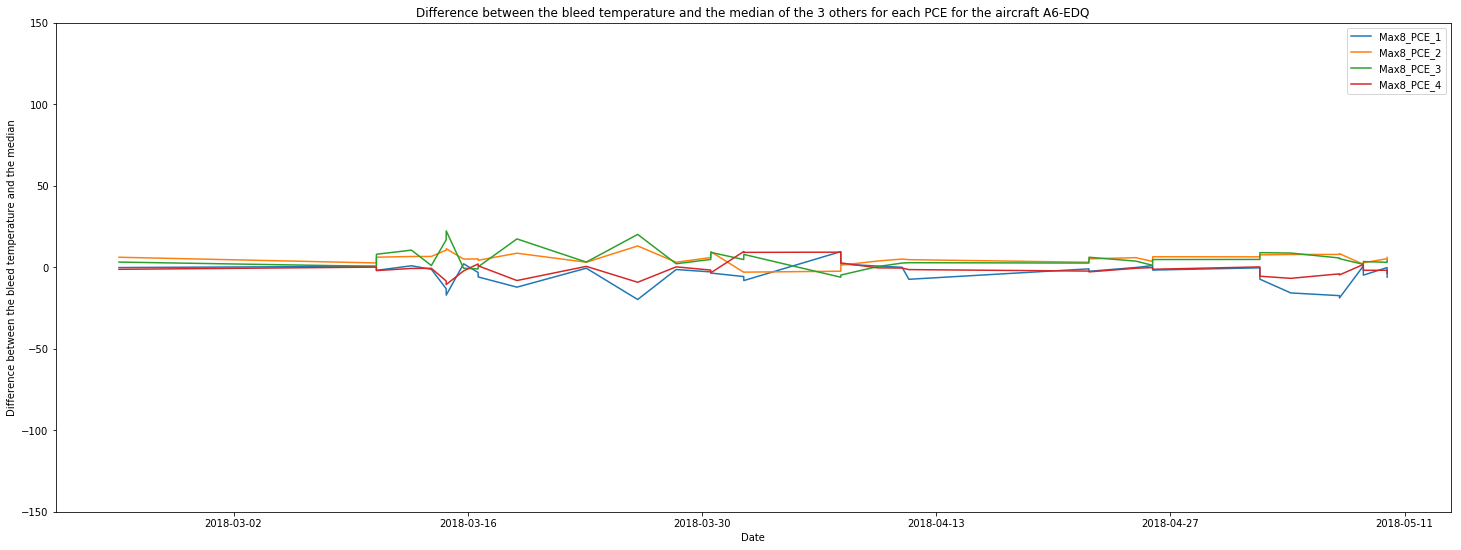

A6-EEP 71 / 89


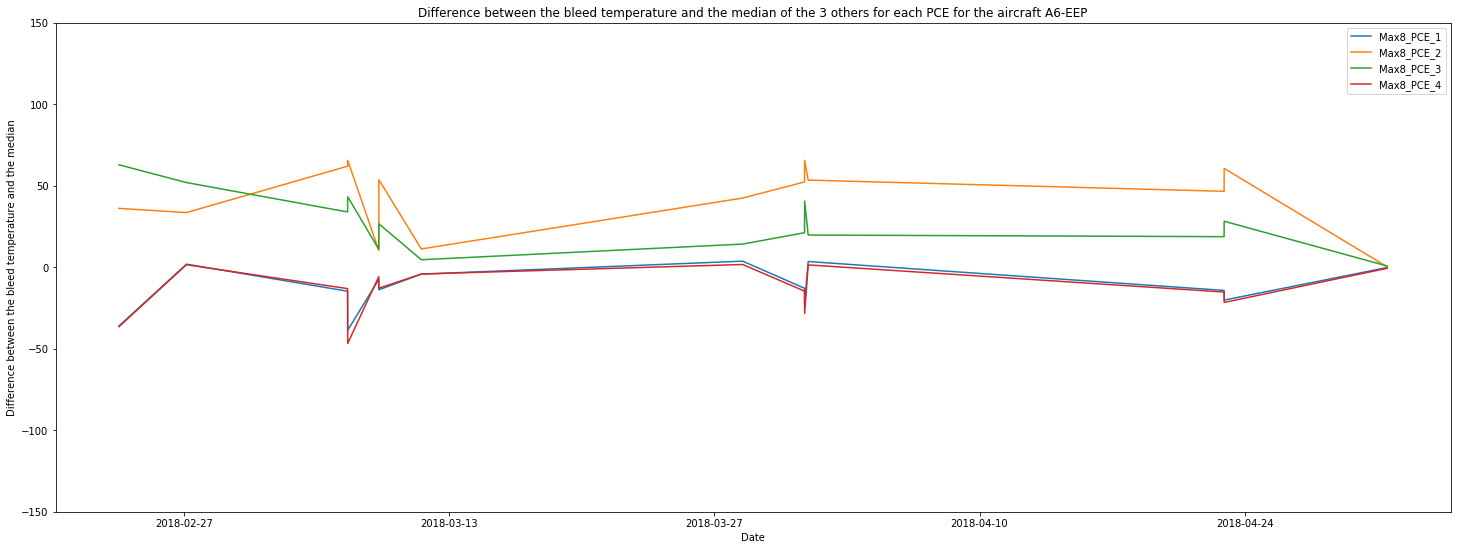

A6-EET 72 / 89


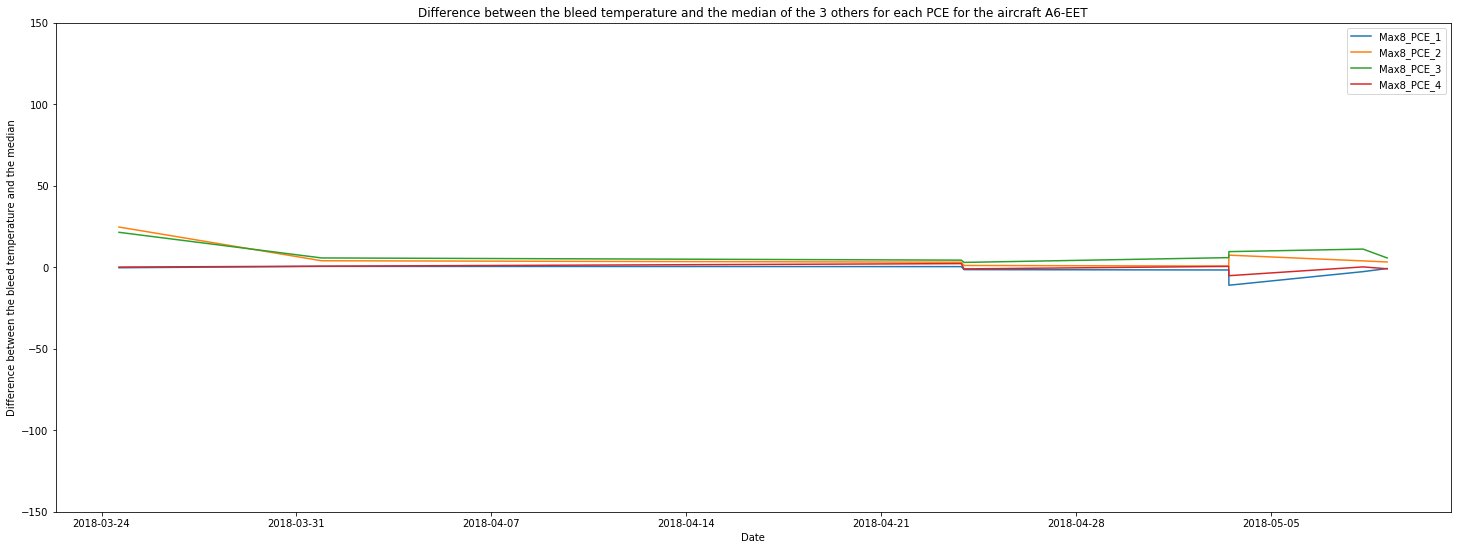

A6-EDM 73 / 89


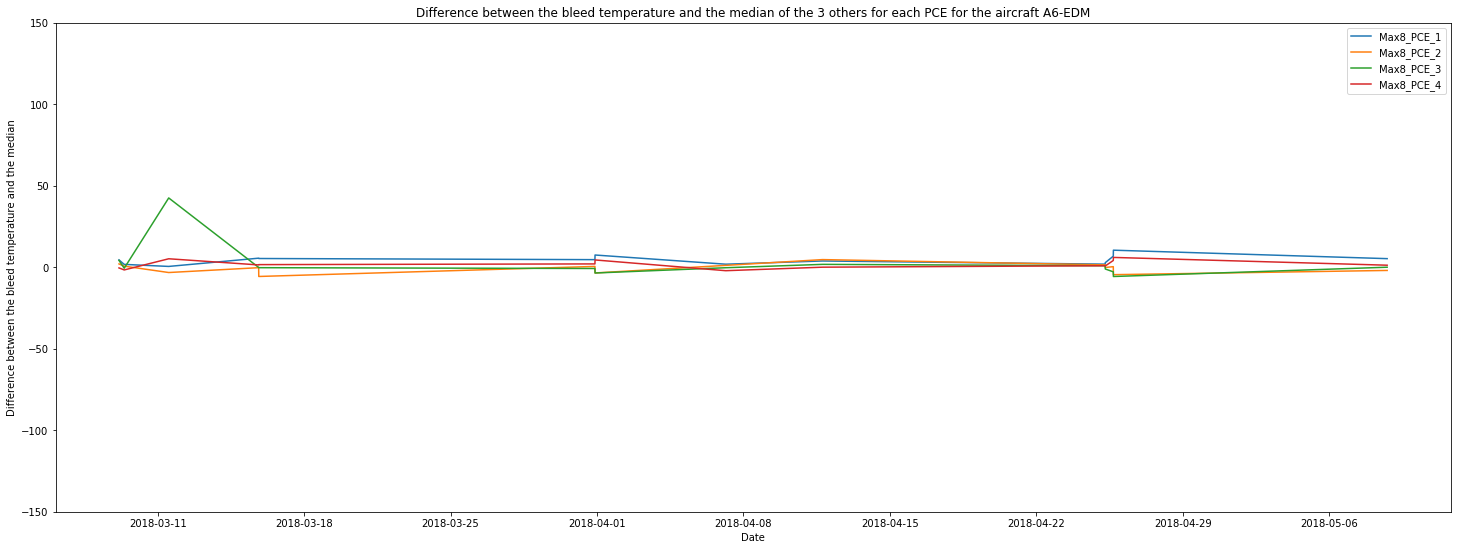

A6-EOY 74 / 89


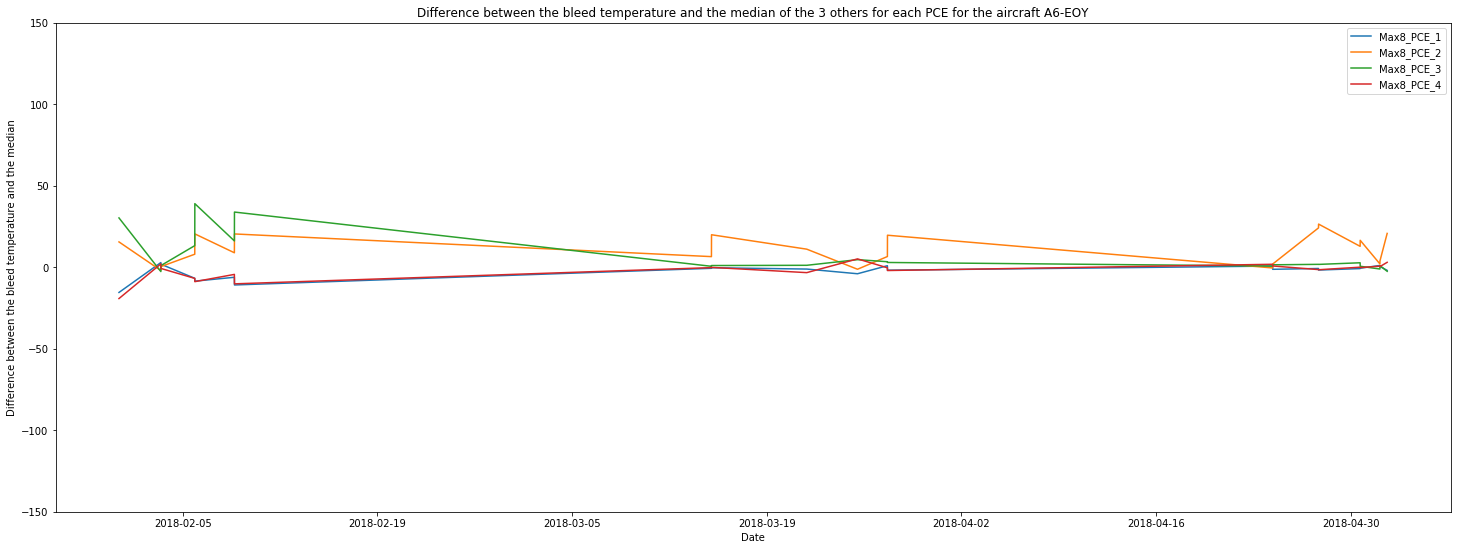

A6-EOO 75 / 89


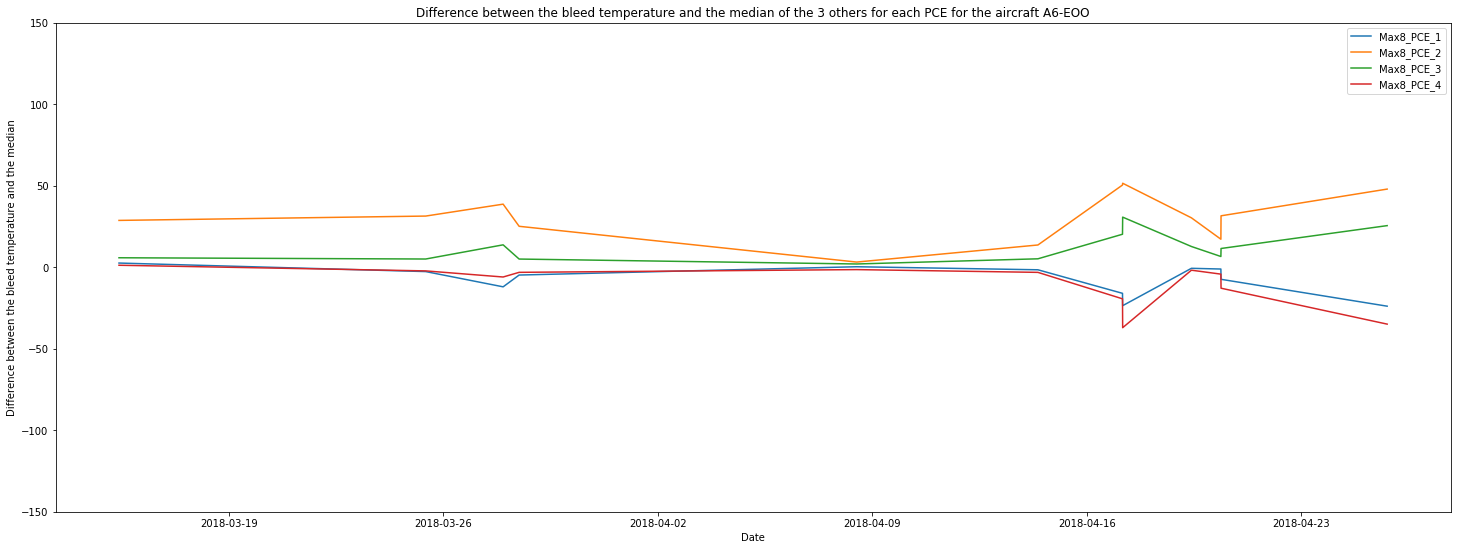

A6-EON 76 / 89


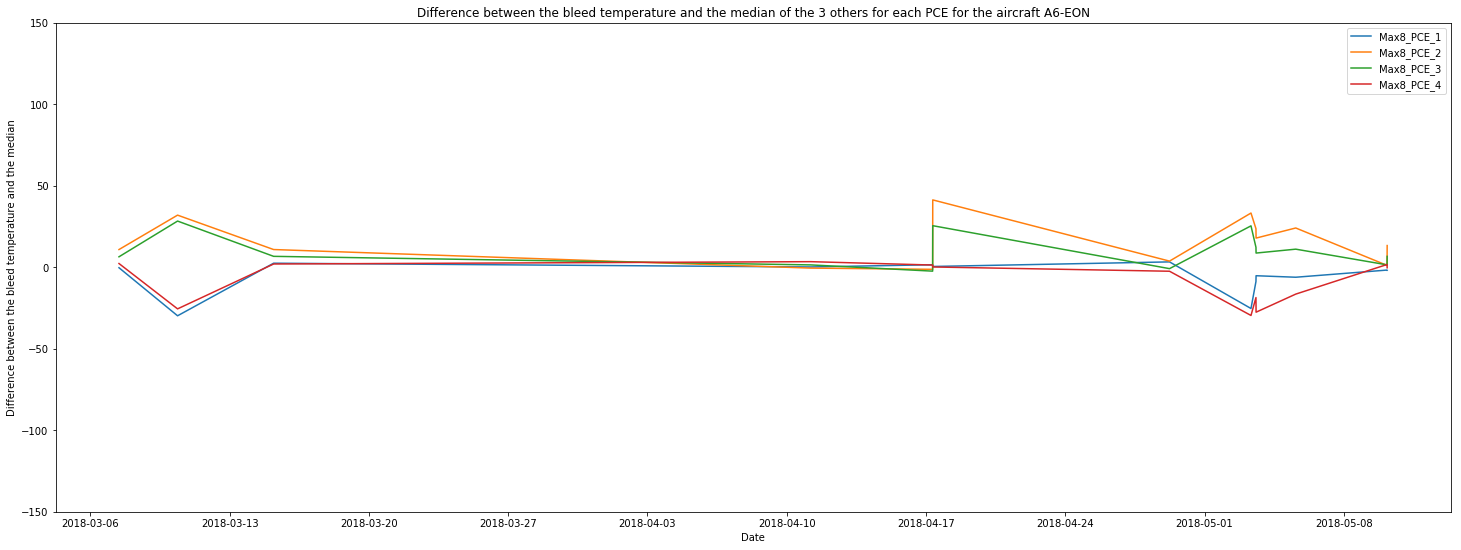

A6-EOI 77 / 89


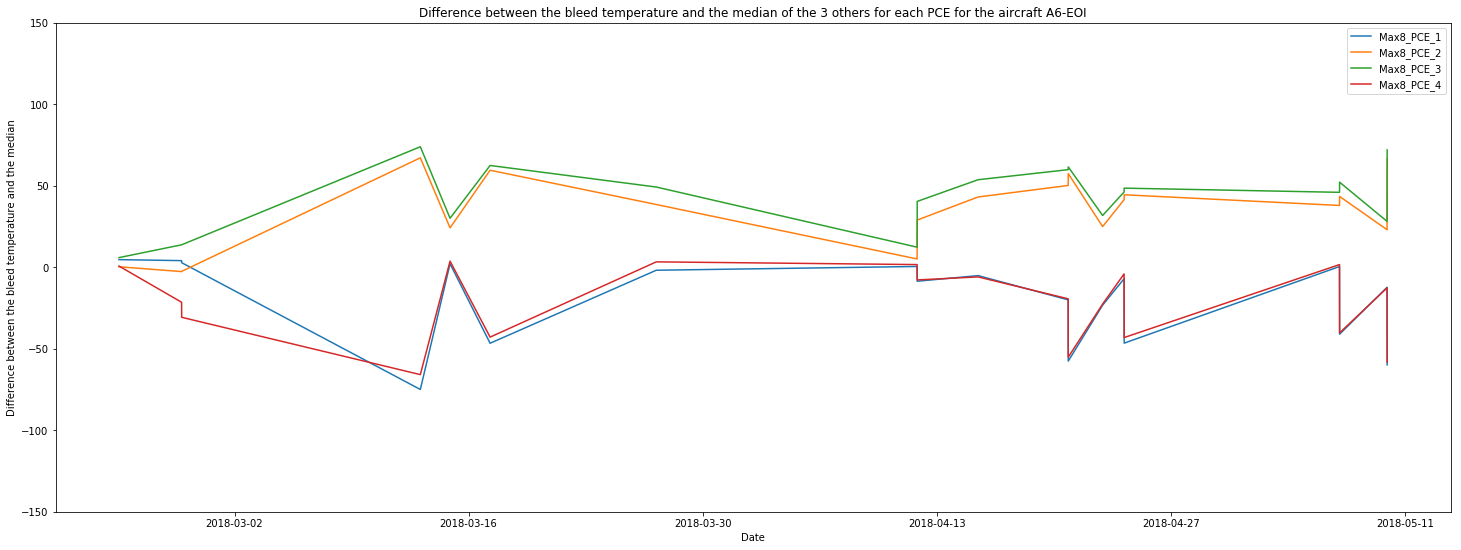

A6-EDE 78 / 89


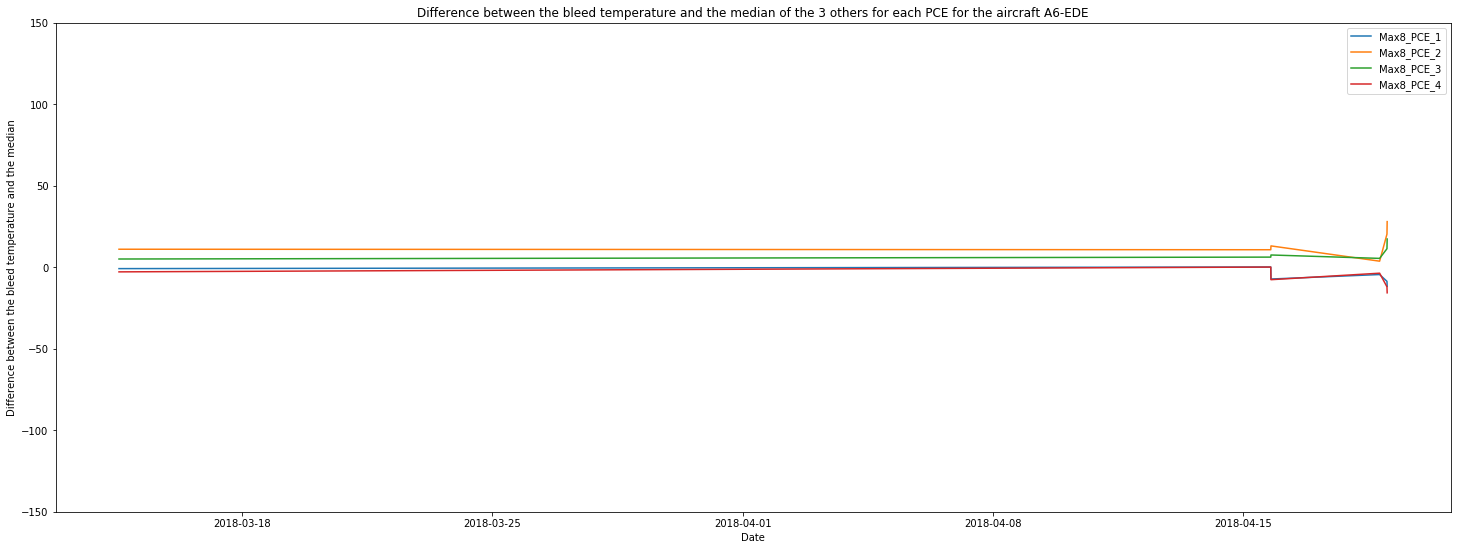

A6-EUE 79 / 89


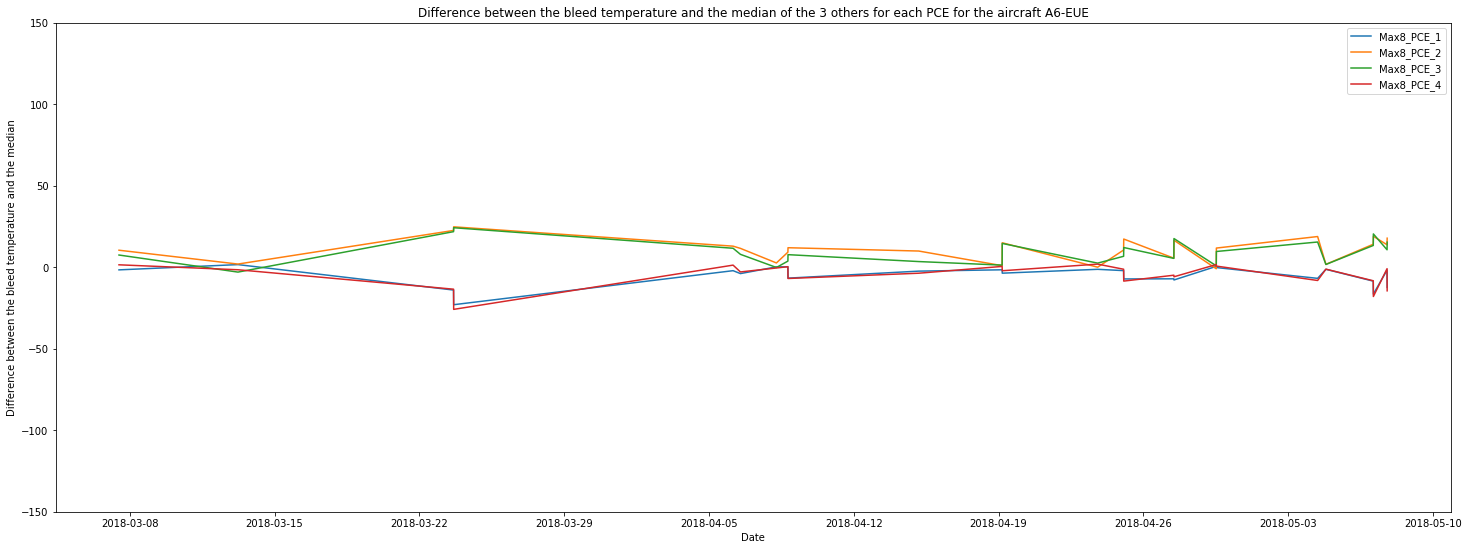

A6-EDD 80 / 89


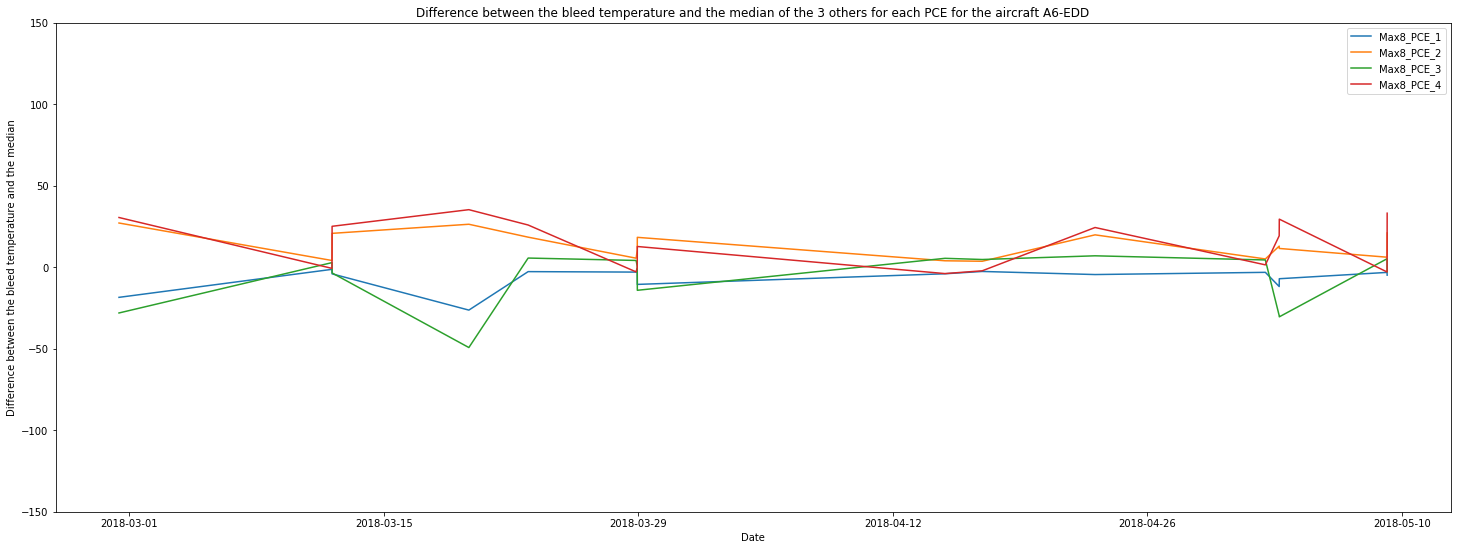

A6-EOM 81 / 89


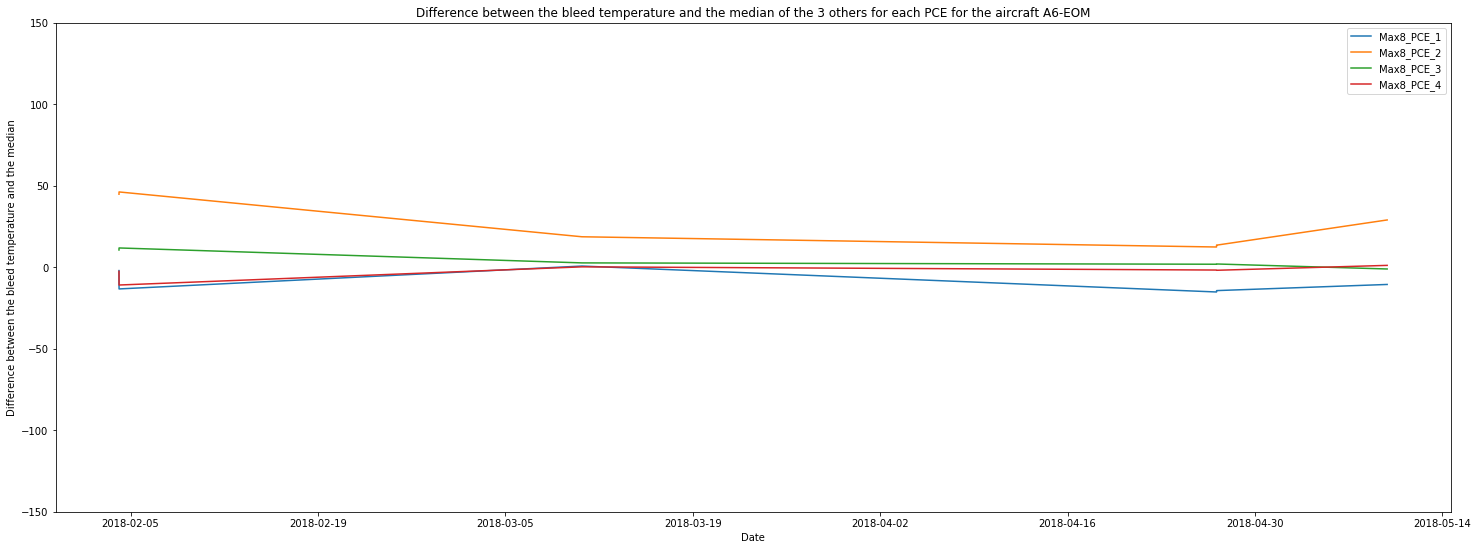

A6-EEG 82 / 89


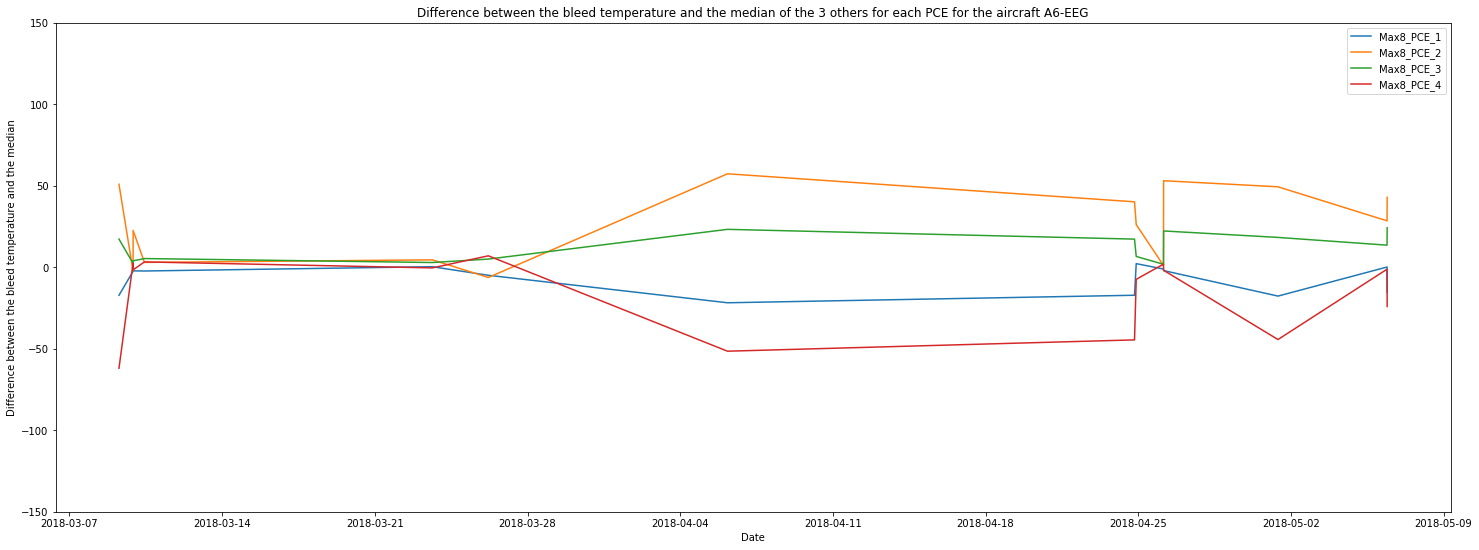

A6-EDJ 83 / 89


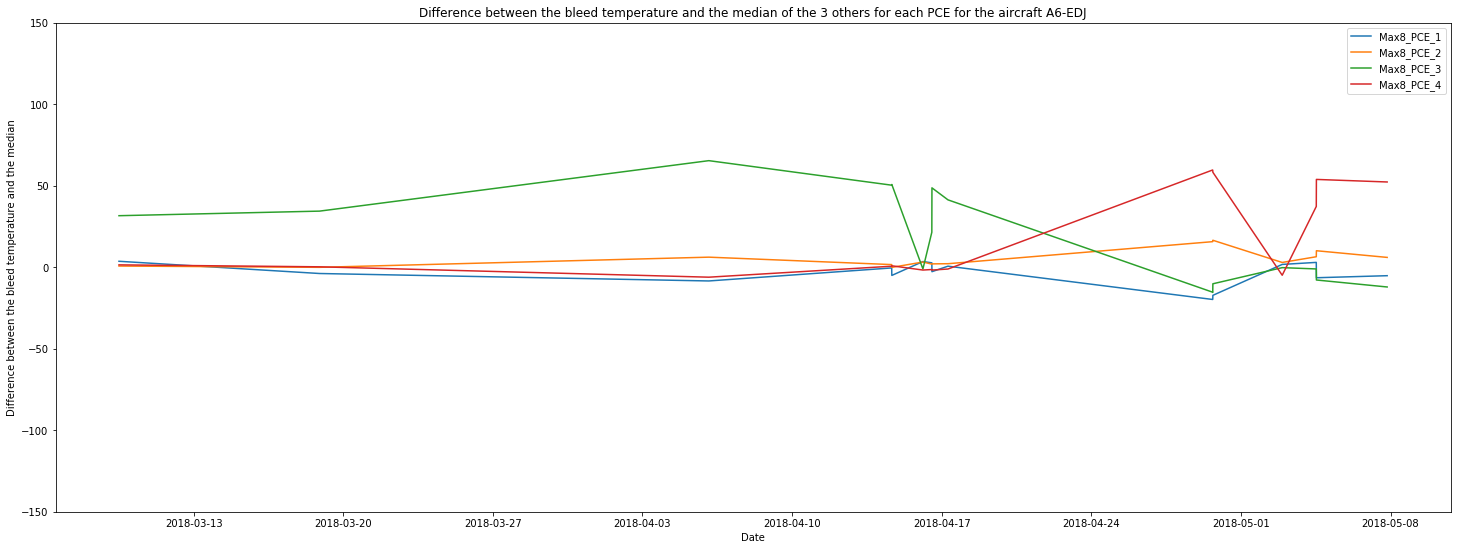

A6-EOC 84 / 89


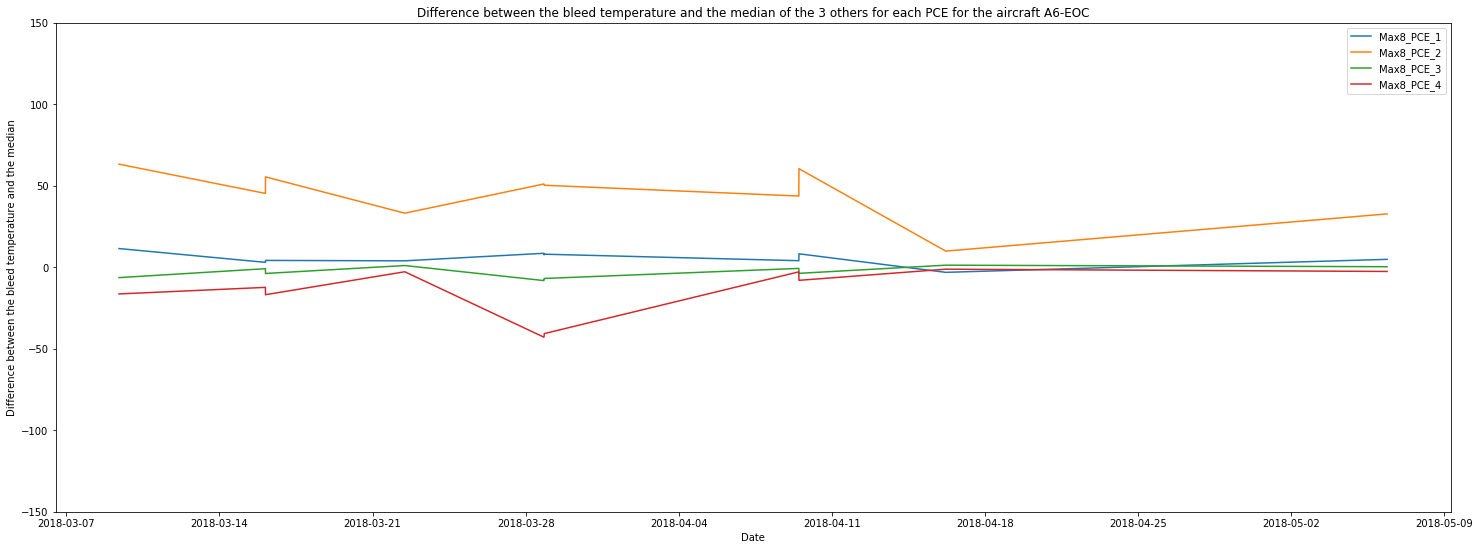

A6-EEF 85 / 89


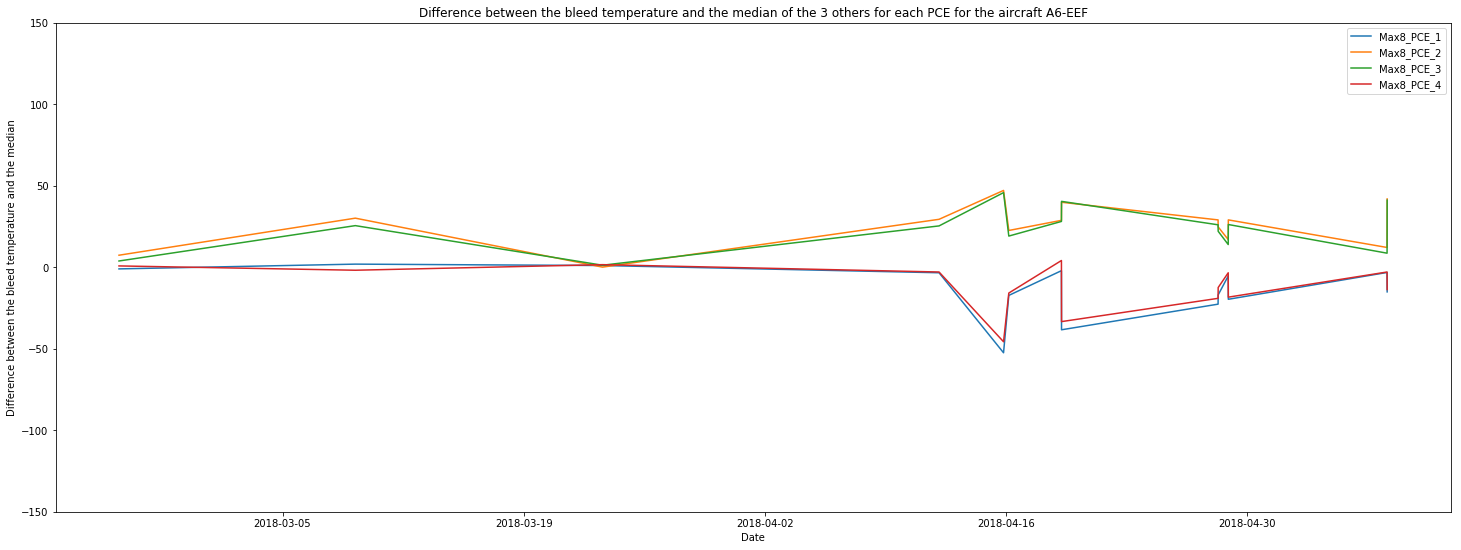

A6-EEU 86 / 89


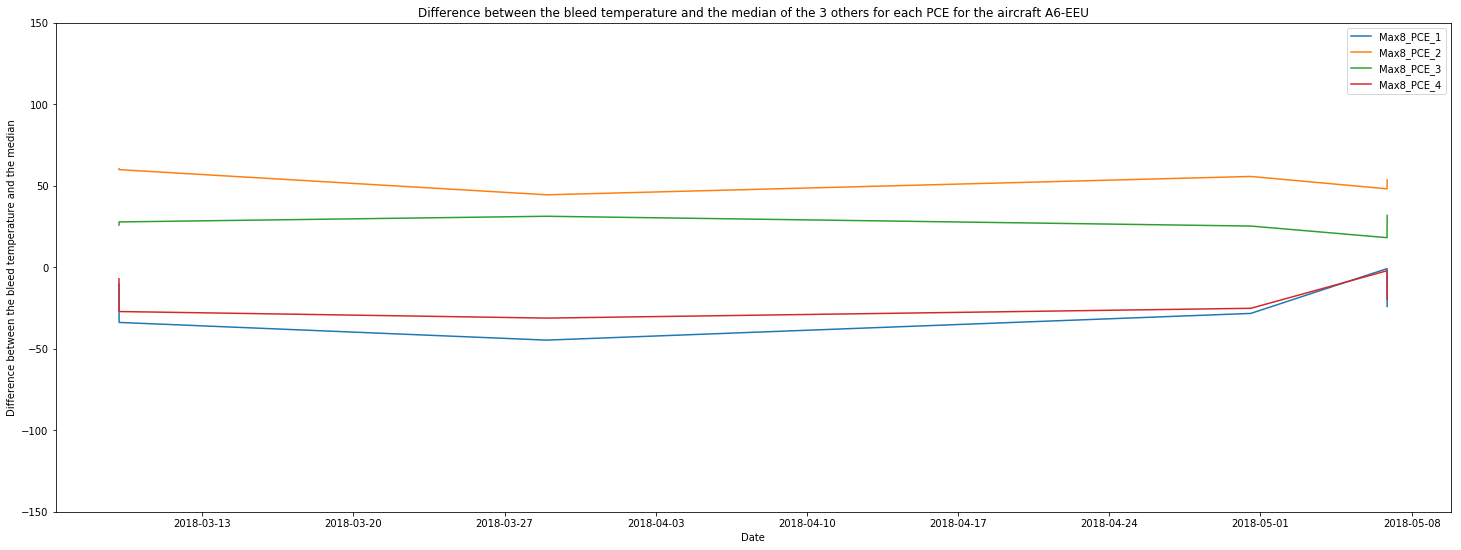

A6-EEV 87 / 89


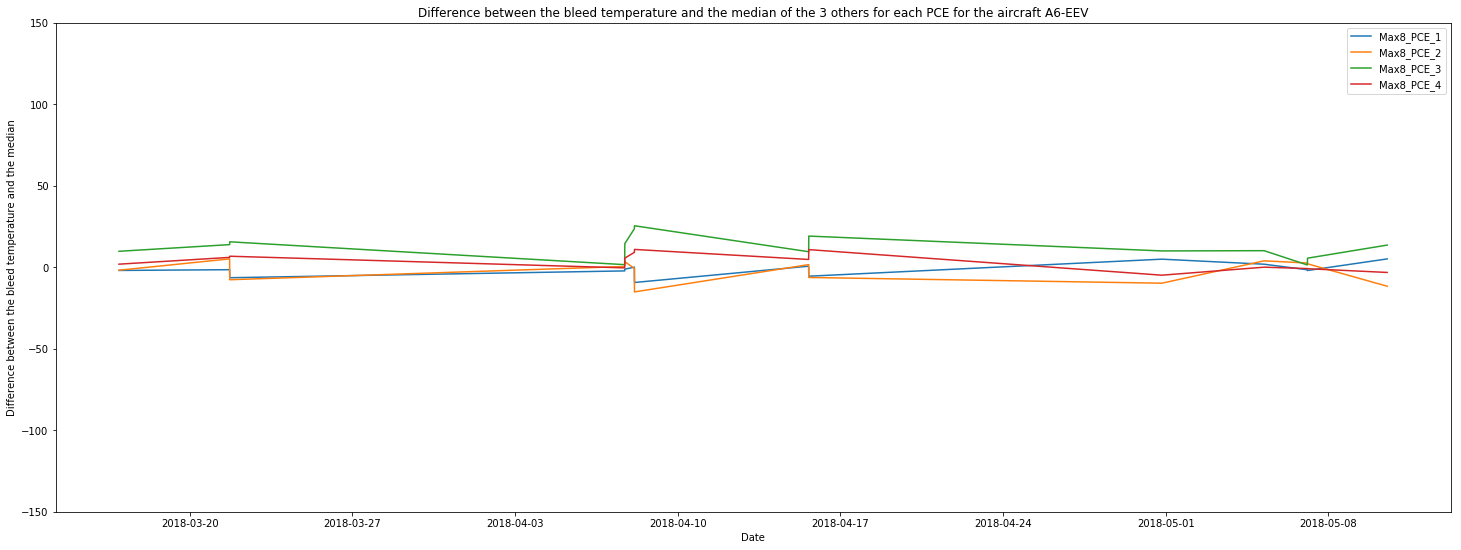

A6-EEH 88 / 89


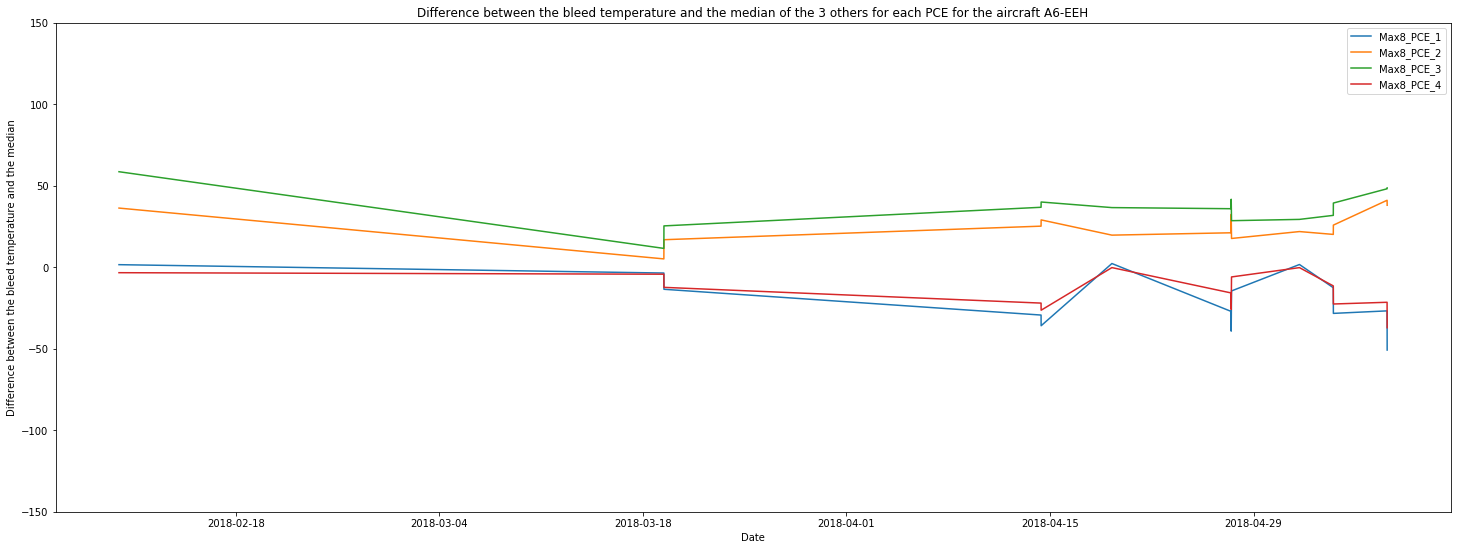

A6-EOL 89 / 89


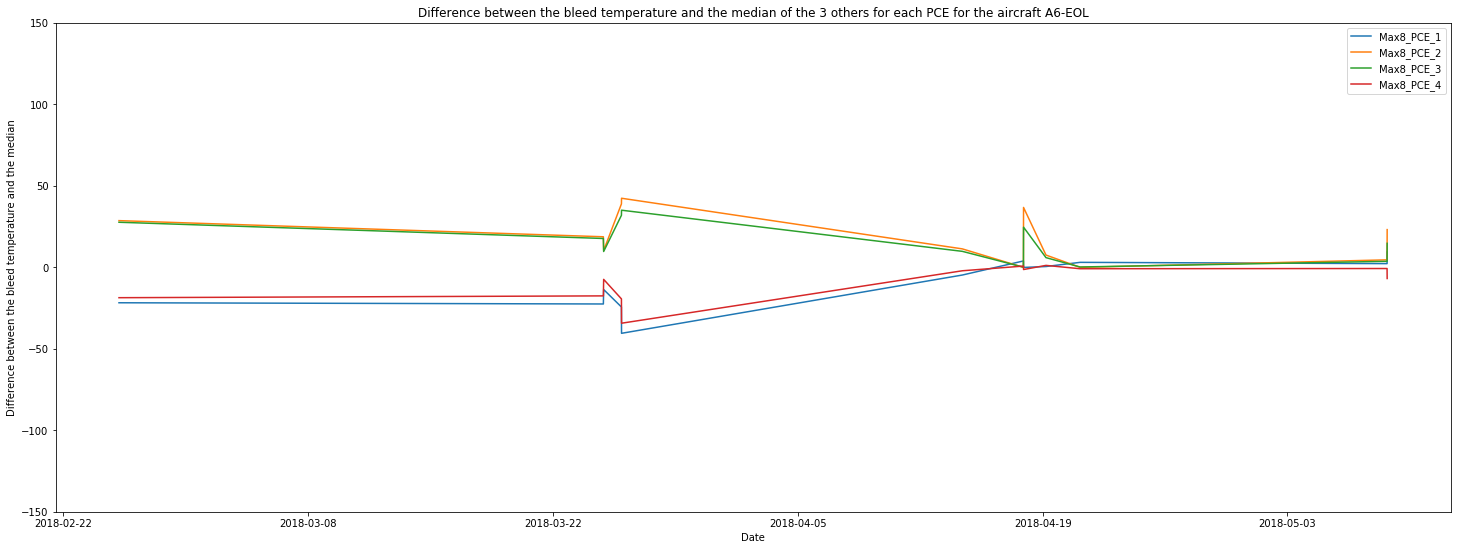

In [6]:
aircraft_registration = pandas.unique(df['tailnb']) #List of all aircraft registration
time_aircraft = 1
pp1 = PdfPages('../03_results/A380_Precooler_Median.pdf') #PDF where plots are saved
for aircraft in aircraft_registration: #For each aircraft
    print(aircraft,time_aircraft,'/',len(aircraft_registration))
    df_aircraft = df[df['tailnb'] == aircraft] #Select only this aircraft among all the dataframe
    df_aircraft = df_aircraft.sort_values(by=['modified_date']) #Sort the dataframe with date
    date_aircraft = pandas.unique(df_aircraft['date']) #List of unique date
    MaxByUplink = np.zeros((len(date_aircraft),5), dtype=object) #Array initialization
    count = 0
    for date in date_aircraft: #For each date
        MaxByUplink[count,0] = date #First column is date
        df_aircraft_date = df_aircraft[df_aircraft['date'] == date] #Select only this date among the dataframe
        for i in range(1,5):
            pce = 'PCE_'+str(i)
            MaxByUplink[count,i] = df_aircraft_date[pce].max() #Compute for each precooler the max of the median for 1 uplink
        count = count + 1
    MaxByUplink = pandas.DataFrame(MaxByUplink, columns=['Date','Max_PCE_1','Max_PCE_2','Max_PCE_3','Max_PCE_4']) #Convert in dataframe
    #MaxByUplink
    start_date = np.datetime64(MaxByUplink['Date'][0]) #First date where we have data
    end_date = np.datetime64(MaxByUplink['Date'][len(MaxByUplink)-1]) #Last date where we have data
    MaxBy8Uplinks = np.zeros((int((end_date-start_date).astype(int)/480000000)+1,5), dtype=object) #Array initialization
    count = 0
    for i in range(len(MaxBy8Uplinks)):
        df_tempo = MaxByUplink[MaxByUplink['Date'] >= start_date]
        df_tempo = df_tempo[df_tempo['Date'] < start_date + 480000000]
        if len(df_tempo) > 0:
            MaxBy8Uplinks[count,0] = start_date + 240000000
            for j in range(1,5):
                pce = 'Max_PCE_'+str(j)
                MaxBy8Uplinks[count,j] = df_tempo[pce].max()
            count = count + 1
        start_date = start_date + 480000000
        if start_date > end_date:
            break
    MaxBy8Uplinks = MaxBy8Uplinks[:count,] #Keep only not empty row
    MaxBy8Uplinks = pandas.DataFrame(MaxBy8Uplinks, columns=['Date','Max8_PCE_1','Max8_PCE_2','Max8_PCE_3','Max8_PCE_4']) #Convert in dataframe
    #MaxBy8Uplinks
    
    plt.rcParams["figure.figsize"] = [25,9]
    plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_1'])
    plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_2'])
    plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_3'])
    plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_4'])
    plt.legend()
    plt.title("Difference between the bleed temperature and the median of the 3 others for each PCE for the aircraft "+aircraft)
    plt.ylim(ymax=150);plt.ylim(ymin=-150)
    plt.xlabel('Date');plt.ylabel('Difference between the bleed temperature and the median')
    plt.savefig(pp1, format='pdf')
    plt.show() #Plot the figure

    time_aircraft = time_aircraft + 1
pp1.close()

In [44]:
aircraft = 'A6-EDL'
df_aircraft = df[df['tailnb'] == aircraft]
df_aircraft = df_aircraft.sort_values(by=['modified_date'])
print(len(df_aircraft))
date_aircraft = pandas.unique(df_aircraft['date'])
MaxByUplink = np.zeros((len(date_aircraft),5), dtype=object) #Array initialization
count = 0
for date in date_aircraft:
    MaxByUplink[count,0] = date
    df_aircraft_date = df_aircraft[df_aircraft['date'] == date]
    for i in range(1,5):
        pce = 'PCE_'+str(i)
        MaxByUplink[count,i] = df_aircraft_date[pce].max()
    count = count + 1
MaxByUplink = pandas.DataFrame(MaxByUplink, columns=['Date','Max_PCE_1','Max_PCE_2','Max_PCE_3','Max_PCE_4'])
MaxByUplink

523


Date Max_PCE_1 Max_PCE_2 Max_PCE_3 Max_PCE_4
0    2018-02-02 23:38:00   41.6254   74.8706  -38.7246  -44.6933
1    2018-02-02 23:40:00   53.1831   77.3674  -49.2178  -59.7715
2    2018-02-02 23:41:00   53.6383   73.9516  -52.9057  -65.0014
3    2018-02-02 23:42:00   54.9099   70.8384  -53.8231  -69.1879
4    2018-02-02 23:43:00   55.6326   69.4506  -55.0183  -72.0777
5    2018-02-10 08:27:00   5.02267  -1.32067 -0.259363   11.2653
6    2018-02-10 08:31:00   33.0607   53.4969  -39.3331  -31.5788
7    2018-02-10 08:32:00   37.0482   53.9074  -40.5632  -34.8735
8    2018-02-10 22:05:00  -4.08488  0.924935  -0.22303   0.22303
9    2018-02-10 22:08:00   26.2631   54.3603  -20.0822  -23.2787
10   2018-02-14 15:03:00   6.47382   13.0136  -3.15642  -9.32929
11   2018-02-14 15:04:00   18.2711   38.5246  -10.3977  -17.7312
12   2018-02-14 15:05:00   25.0011   47.1237  -23.3487  -32.0661
13   2018-02-14 22:34:00   44.0314   64.7859  -40.7092  -52.6878
14   2018-02-14 22:37:00    51.263   66.2728  -49.6583  -67.6179
15   2018-02-14 22:38:00   50.9742   67.7829  -49.8981    -72.35
16   2018-02-14 22:39:00    49.294   67.7892  -48.1656  -73.4428
17   2018-02-14 22:40:00   46.8393   67.1731  -46.0145  -74.5309
18   2018-02-14 22:41:00   45.0967   66.1451  -44.2832  -75.0838
19   2018-02-14 22:42:00   43.6178   64.5747  -43.5969   -76.066
20   2018-02-17 13:50:00  -3.05357   2.00242    4.1456   5.22154
21   2018-02-17 13:51:00   4.24053   16.8931  -4.79113  -4.24053
22   2018-02-20 09:12:00   8.18852   18.0223  -3.02179  -10.1943
23   2018-02-20 09:13:00   19.6539   39.2124   -12.006  -19.9601
24   2018-02-20 09:14:00   27.1541   48.8693  -23.4645  -33.1779
25   2018-02-20 09:15:00   33.2524   49.9178  -28.9989  -40.9572
26   2018-02-20 09:16:00   38.0616   51.9267   -34.878  -49.3035
27   2018-02-20 09:17:00   39.5563   56.1921  -39.2867  -57.4724
28   2018-02-20 09:18:00   39.4895   58.4215  -39.3122  -60.0857
29   2018-02-22 21:22:00   2.99196   9.05231  -4.61069  -1.08553
..                   ...       ...       ...       ...       ...
85   2018-04-08 12:33:00   31.5284   1.24909 -0.616255  -10.2997
86   2018-04-11 12:23:00   0.38143 -0.478986   1.93052  0.478986
87   2018-04-11 12:25:00   12.7913 -0.571938   0.83277 -0.689408
88   2018-04-11 12:26:00   20.9523   0.57224  0.285936  -1.09173
89   2018-04-11 12:28:00    29.903  0.731591 -0.429088  -4.19122
90   2018-04-14 03:37:00   27.9705   2.80444  -2.46589  -8.98355
91   2018-04-14 03:38:00   36.4101   1.78584 -0.924693  -10.5651
92   2018-04-14 03:39:00   41.9592   1.32205 -0.546665  -13.4572
93   2018-04-14 03:40:00   47.7635   1.05278  -0.30833  -17.1921
94   2018-04-14 03:41:00   47.1515   1.54051  -1.23288  -21.9693
95   2018-04-24 21:46:00  -5.62897   2.61974   -1.4501    1.4501
96   2018-04-24 21:49:00    20.405   3.66585  -3.08223  -4.71091
97   2018-04-24 21:50:00   28.9945   4.03719  -3.20513  -8.74671
98   2018-04-28 06:58:00   13.9213   3.38531  -2.14643  -8.33304
99   2018-04-28 07:00:00   29.4104   3.22992  -2.72374  -13.8162
100  2018-04-28 07:01:00   34.3243    2.6196  -2.15743  -15.2299
101  2018-04-28 07:02:00   34.2267   2.31137  -1.32676  -17.6961
102  2018-04-28 07:03:00   34.3748   2.46561  -1.69501  -22.1649
103  2018-04-28 07:04:00   38.0635   2.00344  -1.69501  -25.5553
104  2018-04-28 07:05:00   41.7617   3.23632  -2.46576  -28.0202
105  2018-04-29 14:29:00   33.6733   7.24274   -6.4172  -21.3859
106  2018-04-29 14:31:00   35.7528   7.53453  -6.93431  -28.4586
107  2018-04-29 14:32:00   38.3628   6.59611  -6.00976  -31.2692
108  2018-04-29 14:33:00   41.2881   6.40901  -5.85592  -35.2006
109  2018-05-02 06:03:00   17.5803  0.924332 -0.924332  -19.3069
110  2018-05-02 06:04:00   16.6646   1.38682   0.42915   -21.777
111  2018-05-02 06:05:00   20.7297   3.08198  -2.60682  -24.7833
112  2018-05-02 06:06:00    21.129   3.09378  -2.60074  -26.2365
113  2018-05-02 06:07:00    21.459   2.23748  -1.57397  -27.3065
114  2018-05-02 06:08:00   25.1528   1.86976  -1.43099 

In [49]:
start_date = np.datetime64(MaxByUplink['Date'][0])
end_date = np.datetime64(MaxByUplink['Date'][len(MaxByUplink)-1])
MaxBy8Uplinks = np.zeros((int((end_date-start_date).astype(int)/480000000)+1,5), dtype=object) #Array initialization
count = 0
for i in range(len(MaxBy8Uplinks)):
    df_tempo = MaxByUplink[MaxByUplink['Date'] >= start_date]
    df_tempo = df_tempo[df_tempo['Date'] < start_date + 480000000]
    if len(df_tempo) > 0:
        MaxBy8Uplinks[count,0] = start_date + 240000000
        for j in range(1,5):
            pce = 'Max_PCE_'+str(j)
            MaxBy8Uplinks[count,j] = df_tempo[pce].max()
        count = count + 1
    start_date = start_date + 480000000
    if start_date > end_date:
        break
MaxBy8Uplinks = MaxBy8Uplinks[:count,]
MaxBy8Uplinks = pandas.DataFrame(MaxBy8Uplinks, columns=['Date','Max8_PCE_1','Max8_PCE_2','Max8_PCE_3','Max8_PCE_4'])
MaxBy8Uplinks

Date Max8_PCE_1 Max8_PCE_2 Max8_PCE_3 Max8_PCE_4
0   2018-02-02T23:42:00.000000    55.6326    77.3674   -38.7246   -44.6933
1   2018-02-10T08:30:00.000000    37.0482    53.9074  -0.259363    11.2653
2   2018-02-10T22:06:00.000000    26.2631    54.3603   -0.22303    0.22303
3   2018-02-14T15:02:00.000000    25.0011    47.1237   -3.15642   -9.32929
4   2018-02-14T22:38:00.000000     51.263    67.7892   -40.7092   -52.6878
5   2018-02-14T22:46:00.000000    43.6178    64.5747   -43.5969    -76.066
6   2018-02-17T13:50:00.000000    4.24053    16.8931     4.1456    5.22154
7   2018-02-20T09:10:00.000000    19.6539    39.2124   -3.02179   -10.1943
8   2018-02-20T09:18:00.000000    39.5563    58.4215   -23.4645   -33.1779
9   2018-02-22T21:26:00.000000    8.65705     20.928   -4.61069   -1.08553
10  2018-03-10T05:18:00.000000   -3.66143    3.92712   -2.37353    3.47694
11  2018-03-17T09:18:00.000000    15.6078    3.63741   -3.63741   -12.7088
12  2018-03-19T04:46:00.000000    45.6076   -0.85838   0.858412   -28.6131
13  2018-03-19T12:46:00.000000    35.8737    4.21088   -1.48935    0.59254
14  2018-03-19T12:54:00.000000    44.4483    4.39661   -2.67972   -10.3783
15  2018-03-21T03:26:00.000000     48.132    4.55062   -3.86847   -35.1678
16  2018-03-26T02:46:00.000000    13.4468    2.12592   -2.89695   -1.24487
17  2018-03-26T02:54:00.000000    25.3696    4.00513   -3.54303   -3.20366
18  2018-03-28T03:26:00.000000    46.9997    5.28796   -3.45257   -15.7711
19  2018-03-28T03:34:00.000000    45.1076    5.57773   -4.64018   -30.9234
20  2018-03-30T06:22:00.000000    29.8769    8.29267    -1.9247   -5.92776
21  2018-03-30T06:30:00.000000     43.077    7.39684   -6.16411   -17.4535
22  2018-04-01T10:22:00.000000    20.0747     3.6547   -2.73713   -5.40335
23  2018-04-01T10:30:00.000000    39.7526    3.85273   -1.30484   -9.24256
24  2018-04-02T16:06:00.000000    8.86843    2.23612    2.08188  -0.865237
25  2018-04-02T16:14:00.000000    19.4778    1.89902   -1.46994   -4.36436
26  2018-04-03T08:30:00.000000    14.0822    1.38726    2.37017   -4.11055
27  2018-04-03T08:38:00.000000    35.5869    2.44893   -0.42943   -11.6229
28  2018-04-03T20:06:00.000000     41.657    1.51337  -0.143154   -7.79232
29  2018-04-08T03:18:00.000000    35.0011    4.58234  -0.647343   -7.18079
30  2018-04-08T03:26:00.000000    45.7029    4.40754   -1.87206   -18.7361
31  2018-04-08T12:30:00.000000    31.8348    1.84852  -0.616255   -7.21939
32  2018-04-11T12:22:00.000000    12.7913  -0.478986    1.93052   0.478986
33  2018-04-11T12:30:00.000000     29.903   0.731591   0.285936   -1.09173
34  2018-04-14T03:34:00.000000    27.9705    2.80444   -2.46589   -8.98355
35  2018-04-14T03:42:00.000000    47.7635    1.78584   -0.30833   -10.5651
36  2018-04-24T21:50:00.000000    28.9945    4.03719    -1.4501     1.4501
37  2018-04-28T07:02:00.000000    41.7617    3.38531   -1.32676   -8.33304
38  2018-04-29T14:30:00.000000    41.2881    7.53453   -5.85592   -21.3859
39  2018-05-02T06:06:00.000000    25.1528    3.09378    0.42915   -19.3069

In [37]:
window_size = 9
SumDifference = np.zeros((int(len(MaxBy8Uplinks)/9+1),5), dtype=object) #Array initialization
for i in range(int(len(MaxBy8Uplinks)/9+1)):
    window = MaxBy8Uplinks[i*9:i*9+9]
    if len(window) > 0:
        SumDifference[i,0] = window['Date'][i*9] + 480000000 * int(window_size/2)
        for j in range(1,5):
            pce = 'Max8_PCE_'+str(j)
            SumDifference[i,j] = window[pce].sum()
SumDifference = pandas.DataFrame(SumDifference, columns=['Date','SumMax_PCE_1','SumMax_PCE_2','SumMax_PCE_3','SumMax_PCE_4'])
SumDifference = SumDifference[SumDifference['SumMax_PCE_1'] != 0]
SumDifference

Date SumMax_PCE_1 SumMax_PCE_2 SumMax_PCE_3  \
0     2018-02-03T00:14:00.000000      55.6326      77.3674     -38.7246   
147   2018-02-10T08:38:00.000000      37.0482      53.9074    -0.259363   
158   2018-02-10T21:50:00.000000      26.2631      54.3603     -0.22303   
232   2018-02-14T14:38:00.000000      25.0011      47.1237     -3.15642   
239   2018-02-14T23:02:00.000000      94.8808      132.364     -84.3061   
291   2018-02-17T13:26:00.000000      4.24053      16.8931       4.1456   
347   2018-02-20T08:38:00.000000      19.6539      39.2124     -3.02179   
348   2018-02-20T09:50:00.000000      39.5563      58.4215     -23.4645   
398   2018-02-22T21:50:00.000000      8.65705       20.928     -4.61069   
704   2018-03-10T05:02:00.000000     -3.66143      3.92712     -2.37353   
848   2018-03-17T09:50:00.000000      15.6078      3.63741     -3.63741   
884   2018-03-19T05:02:00.000000      45.6076     -0.85838     0.858412   
890   2018-03-19T12:14:00.000000      35.8737      4.21088     -1.48935   
891   2018-03-19T13:26:00.000000      44.4483      4.39661     -2.67972   
923   2018-03-21T03:50:00.000000       48.132      4.55062     -3.86847   
1022  2018-03-26T02:38:00.000000      38.8164      6.13106     -6.43998   
1063  2018-03-28T03:50:00.000000      92.1073      10.8657     -8.09275   
1105  2018-03-30T06:14:00.000000      72.9539      15.6895      -8.0888   
1148  2018-04-01T09:50:00.000000      20.0747       3.6547     -2.73713   
1149  2018-04-01T11:02:00.000000      39.7526      3.85273     -1.30484   
1173  2018-04-02T15:50:00.000000      28.3463      4.13514     0.611942   
1187  2018-04-03T08:38:00.000000      49.6691      3.83619      1.94074   
1197  2018-04-03T20:38:00.000000       41.657      1.51337    -0.143154   
1283  2018-04-08T03:50:00.000000       80.704      8.98988      -2.5194   
1290  2018-04-08T12:14:00.000000      31.8348      1.84852    -0.616255   
1350  2018-04-11T12:14:00.000000      42.6943     0.252605      2.21646   
1403  2018-04-14T03:50:00.000000       75.734      4.59028     -2.77422   
1618  2018-04-24T21:50:00.000000      28.9945      4.03719      -1.4501   
1686  2018-04-28T07:26:00.000000      41.7617      3.38531     -1.32676   
1712  2018-04-29T14:38:00.000000      41.2881      7.53453     -5.85592   
1765  2018-05-02T06:14:00.000000      25.1528      3.09378      0.42915   

     SumMax_PCE_4  
0        -44.6933  
147       11.2653  
158       0.22303  
232      -9.32929  
239      -128.754  
291       5.22154  
347      -10.1943  
348      -33.1779  
398      -1.08553  
704       3.47694  
848      -12.7088  
884      -28.6131  
890       0.59254  
891      -10.3783  
923      -35.1678  
1022     -4.44854  
1063     -46.6946  
1105     -23.3812  
1148     -5.40335  
1149     -9.24256  
1173     -5.22959  
1187     -15.7334  
1197     -7.79232  
1283     -25.9169  
1290     -7.21939  
1350     -0.61274  
1403     -19.5486  
1618       1.4501  
1686     -8.33304  
1712     -21.3859  
1765     -19.3069

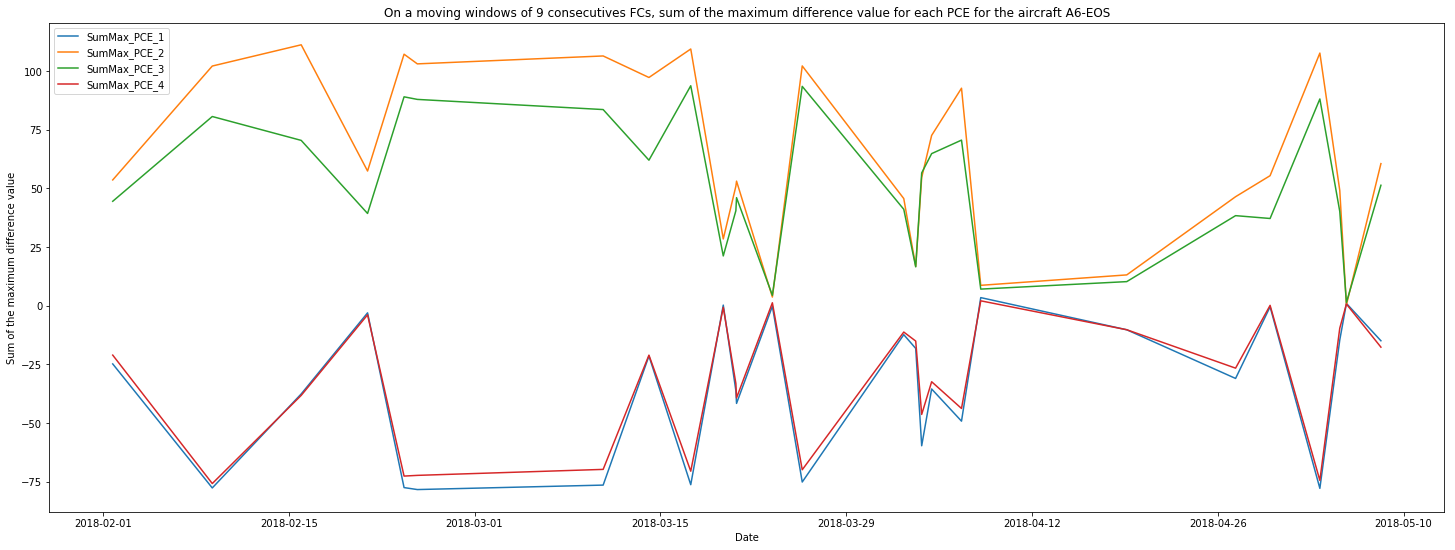

In [31]:
plt.rcParams["figure.figsize"] = [25,9]
plt.plot(SumDifference['Date'],SumDifference['SumMax_PCE_1'])
plt.plot(SumDifference['Date'],SumDifference['SumMax_PCE_2'])
plt.plot(SumDifference['Date'],SumDifference['SumMax_PCE_3'])
plt.plot(SumDifference['Date'],SumDifference['SumMax_PCE_4'])
plt.legend()
plt.title("On a moving windows of 9 consecutives FCs, sum of the maximum difference value for each PCE for the aircraft "+aircraft)
plt.xlabel('Date');plt.ylabel('Sum of the maximum difference value')
plt.show()

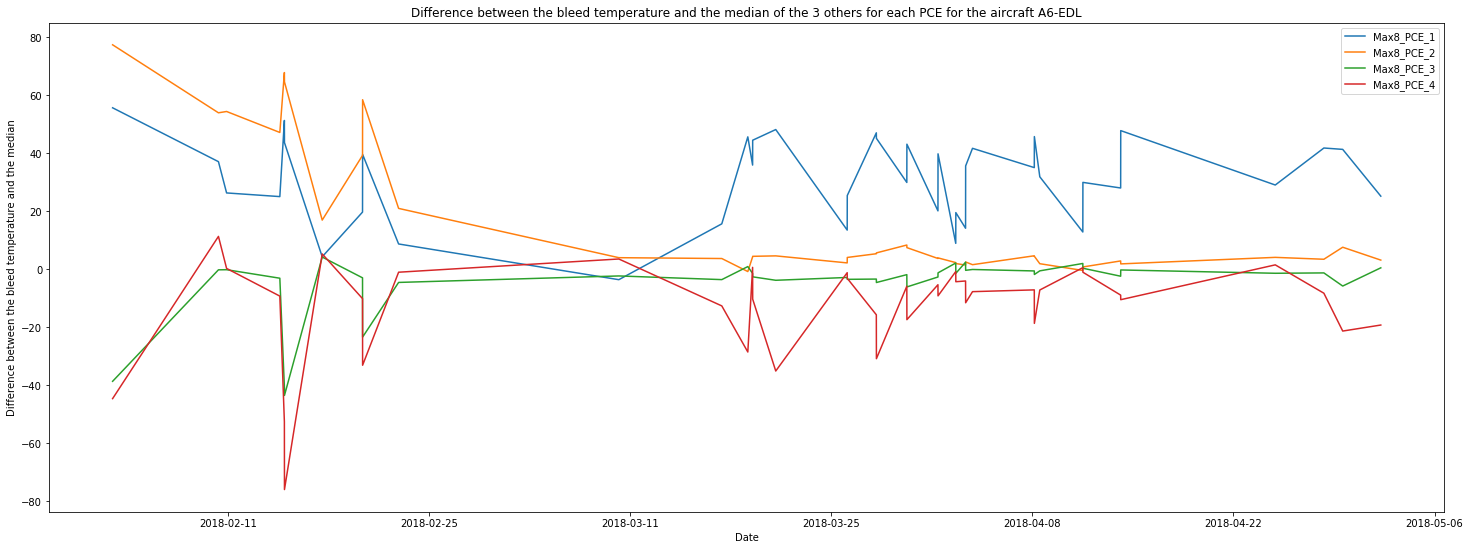

In [50]:
plt.rcParams["figure.figsize"] = [25,9]
plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_1'])
plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_2'])
plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_3'])
plt.plot(MaxBy8Uplinks['Date'],MaxBy8Uplinks['Max8_PCE_4'])
plt.legend()
plt.title("Difference between the bleed temperature and the median of the 3 others for each PCE for the aircraft "+aircraft)
plt.xlabel('Date');plt.ylabel('Difference between the bleed temperature and the median')
plt.show()

In [23]:
df = pandas.read_excel('../01_data/export_A380__TBR361J0_20180126-20180202.xlsx')
df = df[df['tailNb'] == 'A6-EOS']